# *Caso de Estudio Nhanes* #

El Estudio Nacional de Examen de Salud y Nutrición (National Health and Nutrition Examination Survey, NHANES) es un programa de encuestas diseñado para evaluar la salud y el estado nutricional de adultos y niños en los Estados Unidos. A través de entrevistas y exámenes físicos, NHANES recopila datos que ayudan a comprender las condiciones prevalentes en la población, como enfermedades crónicas, deficiencias nutricionales, y problemas de salud mental, incluyendo la depresión.

## *Etapa 1: Comprensión del Negocio*

El objetivo de este estudio es (rellenar)

### Inicio

In [1]:
%load_ext kedro.ipython
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import mstats
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [4]:
demografia = catalog.load("demografia")
insulina = catalog.load("insulina")
colesterol = catalog.load("colesterol")
depresion = catalog.load("depresion")
proteinaC = catalog.load("proteinaC")
perfilB = catalog.load("perfilBioquimico")
presion = catalog.load("presionArterial")
medidas = catalog.load("medidasCorporales")
scaler = StandardScaler()
minmax = MinMaxScaler()
pt = PowerTransformer(method='yeo-johnson')
pd.options.display.float_format = '{:.2f}'.format

[10/13/24 16:22:35] INFO     Loading data from demografia (ParquetDataset)...                   ]8;id=300077;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=875291;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from insulina (ParquetDataset)...                     ]8;id=702911;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=180800;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from colesterol (ParquetDataset)...                   ]8;id=660748;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=770353;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from depresion (ParquetDataset)...                    ]8;id=92581;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=540482;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from proteinaC (ParquetDataset)...                    ]8;id=499606;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=978593;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from perfilBioquimico (ParquetDataset)...             ]8;id=559000;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=382409;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from presionArterial (ParquetDataset)...              ]8;id=134537;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=21333;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from medidasCorporales (ParquetDataset)...            ]8;id=962393;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=145889;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

# Dataframes

In [9]:
consideracion = pd.DataFrame()
consideracion["ID"] = demografia["ID"]
consideracion["Edad"] = demografia["Edad en años al momento del examen"]
consideracion["Genero"] = demografia["Género"] #1 = hombre; 2= mujer
consideracion["Raza"] = demografia["Raza/Origen hispano con asiáticos no hispanos"] # 1 = mexico; 2 = otro hispano; 3 = Blanco; 4= negro; 6= asiatico; 7 = otro
consideracion["Educacion"] = demografia["Nivel educativo - Adultos 20+"] #ver nhanes
consideracion["EstadoCivil"] = demografia["Estado civil"]
consideracion["NivelPobreza"] = demografia["Relación de ingresos familiares con la pobreza"]

In [36]:
Q1 = insulina["Insulina (μU/mL)"].quantile(0.25)
Q3 = insulina["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = insulina[(insulina["Insulina (μU/mL)"] < lower_bound) | (insulina["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
consideracion_insulina_limpio = insulina[~((insulina["Insulina (μU/mL)"] < lower_bound) | (insulina["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

 El IQR es 10.3. El límite inferior es: -9.14, el superior es 32.06
310


In [37]:
escalado = scaler.fit_transform(consideracion_insulina_limpio[["Insulina (μU/mL)"]])
insulina_escalado = consideracion_insulina_limpio.copy()
insulina_escalado["Insulina (μU/mL)"]=escalado

In [38]:
Q1 = insulina_escalado["Insulina (μU/mL)"].quantile(0.25)
Q3 = insulina_escalado["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = insulina_escalado[(insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
limpieza_insulina = insulina_escalado[~((insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

 El IQR es 1.2941829291513374. El límite inferior es: -2.6984244447452377, el superior es 2.478307271860112
115


In [39]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
insulina_limpia = limpieza_insulina.copy()
insulina_limpia["Insulina (μU/mL)"] = knn_imputer.fit_transform(limpieza_insulina[["Insulina (μU/mL)"]])

In [40]:
insulina_limpia["Insulina (μU/mL)"] = pt.fit_transform(insulina_limpia[["Insulina (μU/mL)"]])

                    WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=264325;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=902230;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

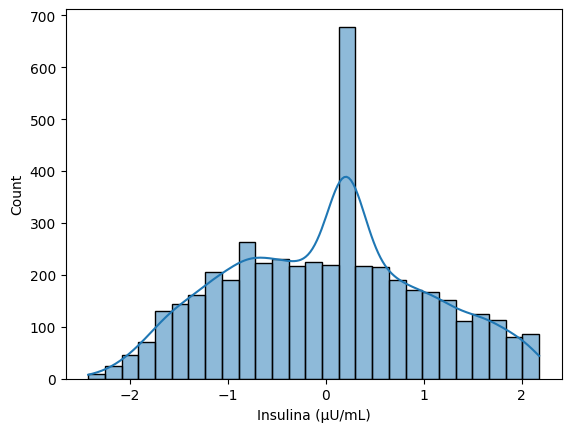

In [41]:
sns.histplot(data=insulina_limpia, x="Insulina (μU/mL)", kde=True)
plt.show()

In [42]:
Q1 = colesterol["Colesterol Total (mg/dL)"].quantile(0.25)
Q3 = colesterol["Colesterol Total (mg/dL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers_colesterol = colesterol[(colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (colesterol["Colesterol Total (mg/dL)"] > upper_bound)]

# Removing outliers
consideracion_colesterol_limpio = colesterol[~((colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (colesterol["Colesterol Total (mg/dL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers_colesterol)

print(num_outliers)

 El IQR es 52.0. El límite inferior es: 71.0, el superior es 279.0
177


In [43]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
colesterol_limpio = consideracion_colesterol_limpio.copy()
colesterol_limpio["Colesterol Total (mg/dL)"] = knn_imputer.fit_transform(colesterol_limpio[["Colesterol Total (mg/dL)"]])

[09/10/24 12:28:58] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=585349;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=9293;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

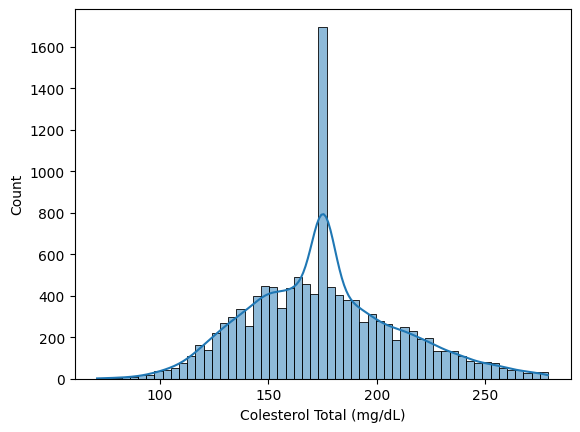

In [44]:
sns.histplot(data=colesterol_limpio, x="Colesterol Total (mg/dL)", kde=True)
plt.show()

In [45]:
colesterol_limpio["Colesterol Total (mg/dL)"] = pt.fit_transform(colesterol_limpio[["Colesterol Total (mg/dL)"]])

In [46]:
prueba = pd.DataFrame()
prueba["ID"] = consideracion["ID"]
prueba["Edad"] = consideracion["Edad"]
prueba["Raza"] = consideracion["Raza"]

In [47]:
merge_insulina = pd.merge(prueba, insulina_limpia, on='ID', how='inner')
merge_medidas = pd.merge(medidas, merge_insulina, on='ID', how='inner')
merge_presion = pd.merge(presion, merge_medidas, on='ID', how='inner')
final = pd.merge(merge_presion, colesterol_limpio, on='ID', how='inner')

In [48]:
final.columns[2:]


Index(['Tamaño del manguito codificado - oscilométrico',
       'Presión sistólica - 1ra lectura oscilométrica',
       'Presión diastólica - 1ra lectura oscilométrica',
       'Presión sistólica - 2da lectura oscilométrica',
       'Presión diastólica - 2da lectura oscilométrica',
       'Presión sistólica - 3ra lectura oscilométrica',
       'Presión diastólica - 3ra lectura oscilométrica',
       'Pulso - 1ra lectura oscilométrica',
       'Pulso - 2da lectura oscilométrica',
       'Pulso - 3ra lectura oscilométrica',
       'Código de estado del componente de medidas corporales', 'Peso (kg)',
       'Comentario sobre el peso', 'Longitud recumbente (cm)',
       'Comentario sobre la longitud recumbente',
       'Circunferencia de la cabeza (cm)',
       'Comentario sobre la circunferencia de la cabeza', 'Altura de pie (cm)',
       'Comentario sobre la altura de pie', 'Índice de masa corporal (kg/m²)',
       'Categoría de IMC - Niños/Jóvenes', 'Longitud del muslo (cm)',
       'C

[09/10/24 12:29:00] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=371824;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=824462;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\matrix.py:260: FutureWarning: Format strings passed to                           
                             MaskedConstant are ignored, but in future may error or produce                        
                             different behavior                                                                    
                               annotation = ("{:" + self.fmt + "}").format(val)                                    
                                                                                                                   

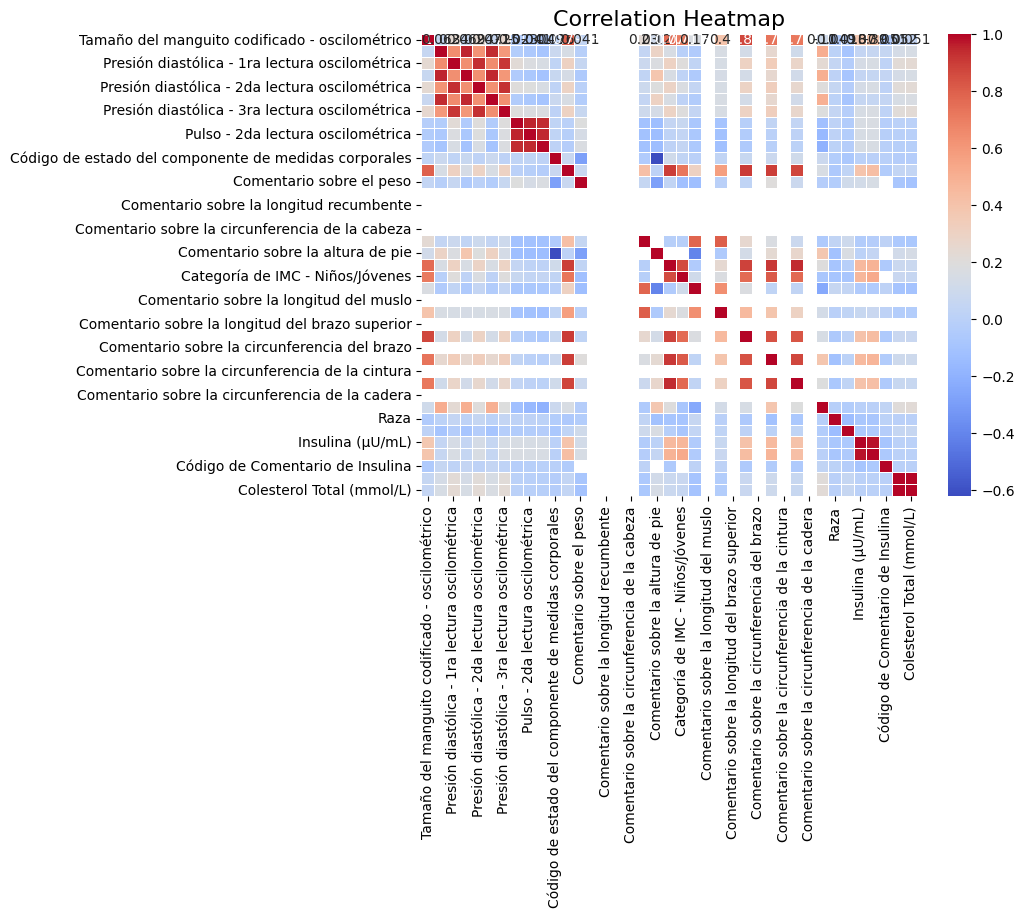

In [49]:
corr_matrix = final[final.columns[2:]].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [50]:

consideracion[consideracion["NivelPobreza"]<1]

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza
1     109264.00 13.00    2.00  1.00        NaN          NaN          0.83
6     109269.00  2.00    1.00  2.00        NaN          NaN          0.96
9     109272.00  0.00    1.00  1.00        NaN          NaN          0.73
10    109273.00 36.00    1.00  3.00       4.00         3.00          0.83
13    109276.00  0.00    1.00  4.00        NaN          NaN          0.00
...         ...   ...     ...   ...        ...          ...           ...
15524 124787.00 19.00    2.00  4.00        NaN          NaN          0.80
15529 124792.00 32.00    1.00  2.00       5.00         3.00          0.00
15535 124798.00 55.00    1.00  2.00       1.00         3.00          0.80
15543 124806.00  4.00    2.00  4.00        NaN          NaN          0.38
15556 124819.00  2.00    1.00  4.00        NaN          NaN          0.07

[3226 rows x 7 columns]

In [51]:
for columna in consideracion.columns:
    if consideracion[columna].isna().sum() != 0:
        print(f"Columna {columna} tiene {consideracion[columna].isna().sum()} NaN")

Columna Educacion tiene 6328 NaN
Columna EstadoCivil tiene 6328 NaN
Columna NivelPobreza tiene 2201 NaN


In [52]:
consideracion.loc[consideracion["Edad"] <= 13, "Educacion"] = consideracion.loc[consideracion["Edad"] <= 13, "Educacion"].fillna(1)
consideracion.loc[consideracion["Edad"] <= 19, "Educacion"] = consideracion.loc[consideracion["Edad"] <= 19, "Educacion"].fillna(2)
consideracion.loc[consideracion["Edad"] <= 18, "EstadoCivil"] = consideracion.loc[consideracion["Edad"] <= 18, "EstadoCivil"].fillna(3)

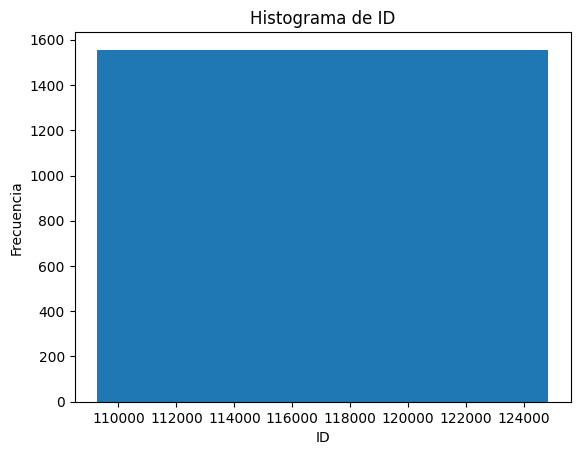

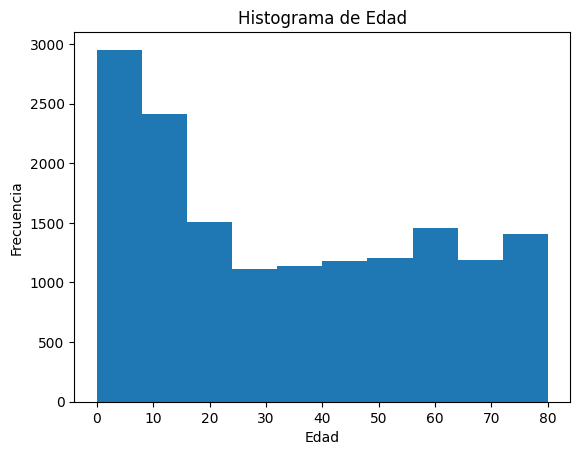

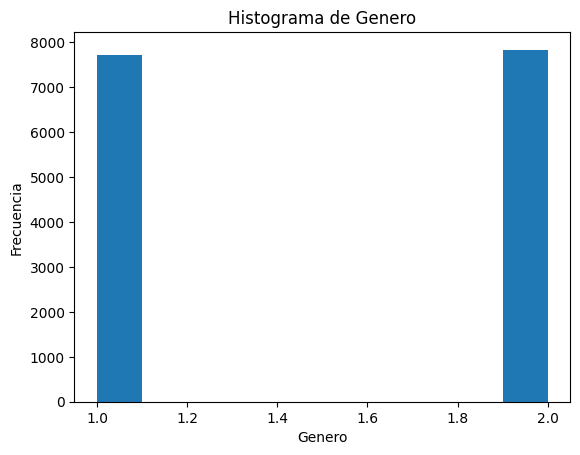

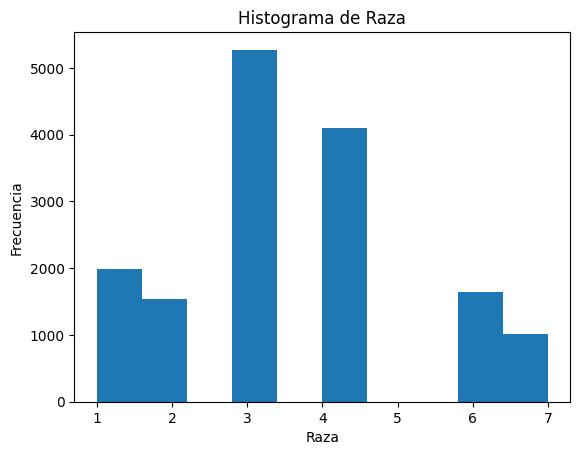

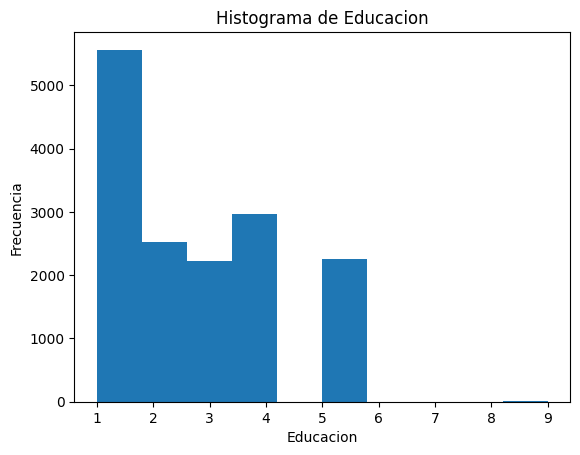

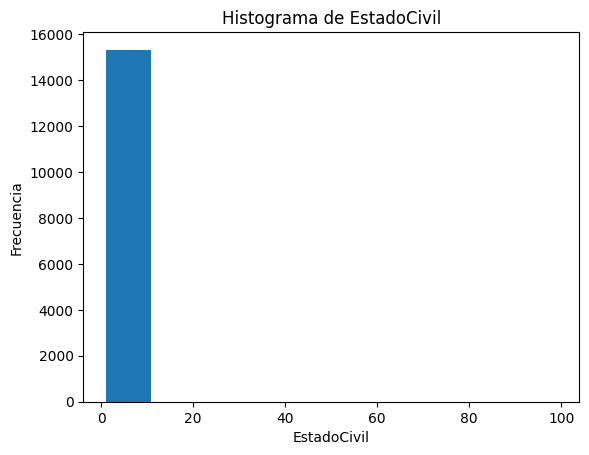

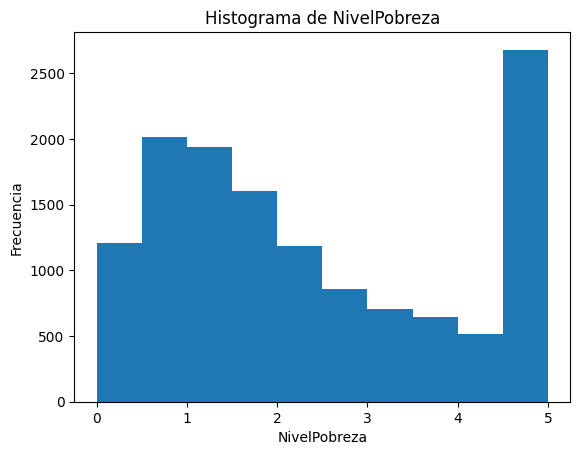

In [53]:
for col in consideracion.columns:
  plt.hist(consideracion[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [54]:
consideracion.isna().sum()


ID                 0
Edad               0
Genero             0
Raza               0
Educacion          0
EstadoCivil      227
NivelPobreza    2201
dtype: int64

In [55]:
consideracion = consideracion.loc[consideracion['NivelPobreza'] <5]

In [56]:
pobreza_escalado = scaler.fit_transform(consideracion[['NivelPobreza']])
pobreza_minmax = minmax.fit_transform(consideracion[['NivelPobreza']])
pobreza_pt = pt.fit_transform(consideracion[['NivelPobreza']])
pobreza_sqrt = np.sqrt(consideracion[['NivelPobreza']])
pobreza_boxcox, _ = stats.boxcox(consideracion["NivelPobreza"] + 1)
log_data = np.log1p(consideracion[['NivelPobreza']])

In [57]:
for pobre in [pobreza_boxcox,log_data,pobreza_escalado,pobreza_minmax,pobreza_pt,pobreza_sqrt]:
    df = pd.DataFrame(pobre)
    print(df.describe())

             0
count 11213.00
mean      1.03
std       0.50
min       0.00
25%       0.66
50%       1.02
75%       1.42
max       1.96
       NivelPobreza
count      11213.00
mean           0.97
std            0.45
min            0.00
25%            0.64
50%            0.97
75%            1.32
max            1.79
             0
count 11213.00
mean      0.00
std       1.00
min      -1.49
25%      -0.79
50%      -0.21
75%       0.65
max       2.39
             0
count 11213.00
mean      0.38
std       0.26
min       0.00
25%       0.18
50%       0.33
75%       0.55
max       1.00
             0
count 11213.00
mean      0.00
std       1.00
min      -2.08
25%      -0.74
50%      -0.02
75%       0.77
max       1.88
       NivelPobreza
count      11213.00
mean           1.29
std            0.50
min            0.00
25%            0.95
50%            1.28
75%            1.66
max            2.23


[09/10/24 12:29:03] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=953330;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=833835;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=795373;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=34851;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1075: FutureWarning: When grouping with a length-1                   
                             list-like, you will need to pass a length-1 tuple to get_group in a                   
                             future version of pandas. Pass `(name,)` instead of `name` to silence                 
                             this warning.                                                                         
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

[09/10/24 12:29:04] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=447210;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=584044;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1075: FutureWarning: When grouping with a length-1                   
                             list-like, you will need to pass a length-1 tuple to get_group in a                   
                             future version of pandas. Pass `(name,)` instead of `name` to silence                 
                             this warning.                                                                         
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

                    WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=966318;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=717287;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1075: FutureWarning: When grouping with a length-1                   
                             list-like, you will need to pass a length-1 tuple to get_group in a                   
                             future version of pandas. Pass `(name,)` instead of `name` to silence                 
                             this warning.                                                                         
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

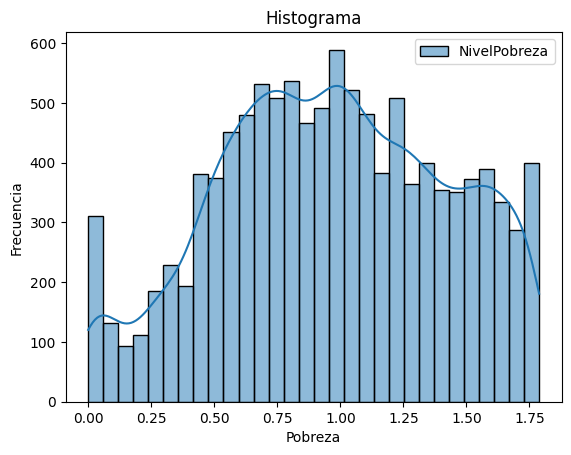

                    WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=839062;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=774798;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=383809;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=991539;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1075: FutureWarning: When grouping with a length-1                   
                             list-like, you will need to pass a length-1 tuple to get_group in a                   
                             future version of pandas. Pass `(name,)` instead of `name` to silence                 
                             this warning.                                                                         
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

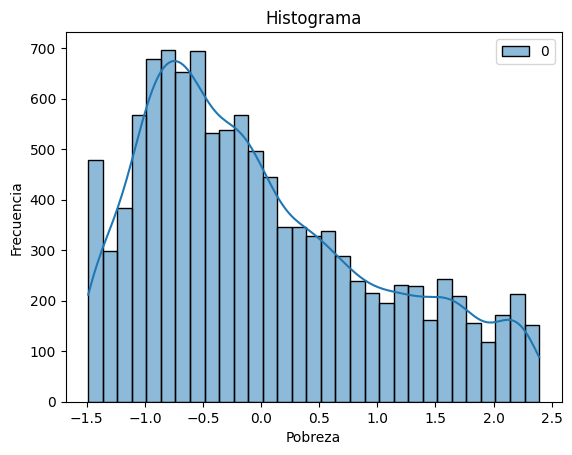

[09/10/24 12:29:05] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=620186;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=871206;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=866935;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=113391;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1075: FutureWarning: When grouping with a length-1                   
                             list-like, you will need to pass a length-1 tuple to get_group in a                   
                             future version of pandas. Pass `(name,)` instead of `name` to silence                 
                             this warning.                                                                         
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

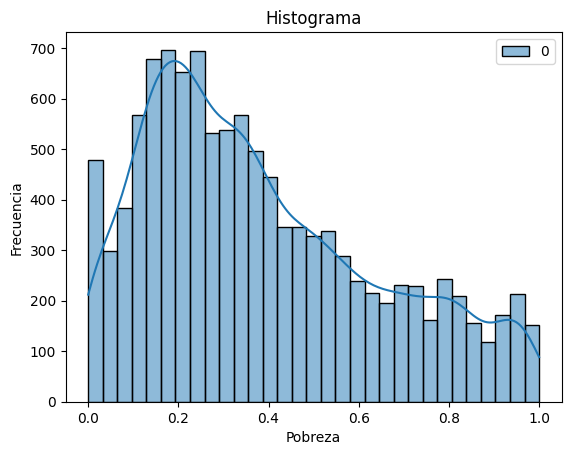

[09/10/24 12:29:06] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=543134;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=451777;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=630393;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=659837;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1075: FutureWarning: When grouping with a length-1                   
                             list-like, you will need to pass a length-1 tuple to get_group in a                   
                             future version of pandas. Pass `(name,)` instead of `name` to silence                 
                             this warning.                                                                         
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

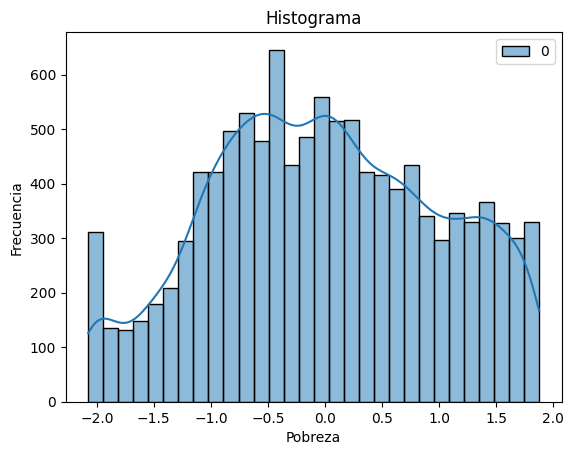

[09/10/24 12:29:07] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=120884;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=965362;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=21406;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=169;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1075: FutureWarning: When grouping with a length-1                   
                             list-like, you will need to pass a length-1 tuple to get_group in a                   
                             future version of pandas. Pass `(name,)` instead of `name` to silence                 
                             this warning.                                                                         
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

[09/10/24 12:29:08] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=189056;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=725018;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1075: FutureWarning: When grouping with a length-1                   
                             list-like, you will need to pass a length-1 tuple to get_group in a                   
                             future version of pandas. Pass `(name,)` instead of `name` to silence                 
                             this warning.                                                                         
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

                    WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=174267;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=390315;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1075: FutureWarning: When grouping with a length-1                   
                             list-like, you will need to pass a length-1 tuple to get_group in a                   
                             future version of pandas. Pass `(name,)` instead of `name` to silence                 
                             this warning.                                                                         
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

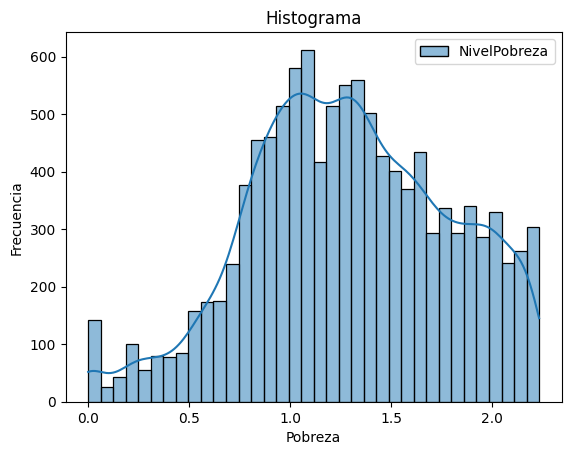

In [58]:
for pobre in [log_data,pobreza_escalado,pobreza_minmax,pobreza_pt,pobreza_sqrt]:
    sns.histplot(data=pobre, kde=True)
    plt.title(f'Histograma')
    plt.xlabel("Pobreza")
    plt.ylabel('Frecuencia')
    plt.show()

In [59]:
consideracion['NivelPobreza'] = pobreza_sqrt

In [60]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
consideracion['NivelPobreza'] = knn_imputer.fit_transform(pobreza_sqrt[['NivelPobreza']])
consideracion

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza
0     109263.00  2.00    1.00  6.00       1.00         3.00          2.16
1     109264.00 13.00    2.00  1.00       1.00         3.00          0.91
2     109265.00  2.00    1.00  3.00       1.00         3.00          1.75
5     109268.00 18.00    2.00  3.00       2.00         3.00          1.29
6     109269.00  2.00    1.00  2.00       1.00         3.00          0.98
...         ...   ...     ...   ...        ...          ...           ...
15554 124817.00 67.00    2.00  1.00       2.00         1.00          1.48
15555 124818.00 40.00    1.00  4.00       5.00         1.00          1.95
15556 124819.00  2.00    1.00  4.00       1.00         3.00          0.26
15557 124820.00  7.00    2.00  3.00       1.00         3.00          1.10
15558 124821.00 63.00    1.00  4.00       2.00         2.00          1.93

[11213 rows x 7 columns]

In [61]:
consideracion["NivelPobreza"].describe()


count   11213.00
mean        1.29
std         0.50
min         0.00
25%         0.95
50%         1.28
75%         1.66
max         2.23
Name: NivelPobreza, dtype: float64

In [62]:
consideracion.isna().sum()


ID                0
Edad              0
Genero            0
Raza              0
Educacion         0
EstadoCivil     173
NivelPobreza      0
dtype: int64

In [63]:
#consideracion = consideracion.dropna()

In [64]:
consideracion["Educacion"].isna().sum()

np.int64(0)

In [65]:
consideracion["NivelPobreza"].describe()


count   11213.00
mean        1.29
std         0.50
min         0.00
25%         0.95
50%         1.28
75%         1.66
max         2.23
Name: NivelPobreza, dtype: float64

# Combinación de dataset con Insulina

In [10]:
consideracion_insulina = pd.merge(consideracion, insulina, on='ID', how='inner')

In [67]:
consideracion_insulina.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3650.00 3650.00 3650.00 3650.00    3650.00      3582.00       3650.00   
mean  117187.07   43.93    1.52    3.45       3.10         1.87          1.33   
std     4467.37   20.82    0.50    1.62       1.24         0.88          0.48   
min   109264.00   12.00    1.00    1.00       1.00         1.00          0.00   
25%   113370.75   25.00    1.00    3.00       2.00         1.00          1.00   
50%   117331.50   44.00    2.00    3.00       3.00         2.00          1.31   
75%   121059.25   62.00    2.00    4.00       4.00         3.00          1.68   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
count                       3650.00           3307.00            3307.00   
mean                       48912.22             15.45              92.69   
std                        60974.78             23.11             138.67   
min                            0.00              0.71               4.26   
25%                        16798.02              6.49              38.94   
50%                        31798.15             10.38              62.28   
75%                        57227.95             17.15             102.90   
max                       741259.19            485.10            2910.60   

       Código de Comentario de Insulina  
count                           3307.00  
mean                               0.00  
std                                0.05  
min                                0.00  
25%                                0.00  
50%                                0.00  
75%                                0.00  
max                                1.00

In [11]:
Q1 = consideracion_insulina["Insulina (μU/mL)"].quantile(0.25)
Q3 = consideracion_insulina["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = consideracion_insulina[(consideracion_insulina["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
consideracion_insulina_limpio = consideracion_insulina[~((consideracion_insulina["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)


 El IQR es 10.3. El límite inferior es: -9.14, el superior es 32.06
310


In [69]:
Q1 = consideracion_insulina_limpio["Insulina (μU/mL)"].quantile(0.25)
Q3 = consideracion_insulina_limpio["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = consideracion_insulina_limpio[(consideracion_insulina_limpio["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina_limpio["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
insulina_limpio = consideracion_insulina_limpio[~((consideracion_insulina_limpio["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina_limpio["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

 El IQR es 8.952499999999999. El límite inferior es: -7.188749999999997, el superior es 28.621249999999996
91


In [12]:
consideracion_insulina_limpio.isna().sum()


ID                                    0
Edad                                  0
Genero                                0
Raza                                  0
Educacion                           786
EstadoCivil                         786
NivelPobreza                        665
Peso de Submuestra en Ayunas          0
Insulina (μU/mL)                    465
Insulina (pmol/L)                   465
Código de Comentario de Insulina    465
dtype: int64

In [71]:
insulina_limpio.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3332.00 3332.00 3332.00 3332.00    3332.00      3273.00       3332.00   
mean  117201.71   44.08    1.52    3.48       3.10         1.87          1.33   
std     4464.66   20.88    0.50    1.62       1.26         0.88          0.49   
min   109264.00   12.00    1.00    1.00       1.00         1.00          0.00   
25%   113395.75   25.00    1.00    3.00       2.00         1.00          1.00   
50%   117358.50   44.00    2.00    3.00       3.00         2.00          1.32   
75%   121054.00   62.00    2.00    4.00       4.00         3.00          1.69   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
count                       3332.00           2989.00            2989.00   
mean                       49067.66             10.94              65.66   
std                        61251.29              6.22              37.33   
min                            0.00              0.71               4.26   
25%                        16954.33              6.17              37.02   
50%                        31798.15              9.59              57.54   
75%                        57008.16             14.47              86.82   
max                       741259.19             28.51             171.06   

       Código de Comentario de Insulina  
count                           2989.00  
mean                               0.00  
std                                0.05  
min                                0.00  
25%                                0.00  
50%                                0.00  
75%                                0.00  
max                                1.00

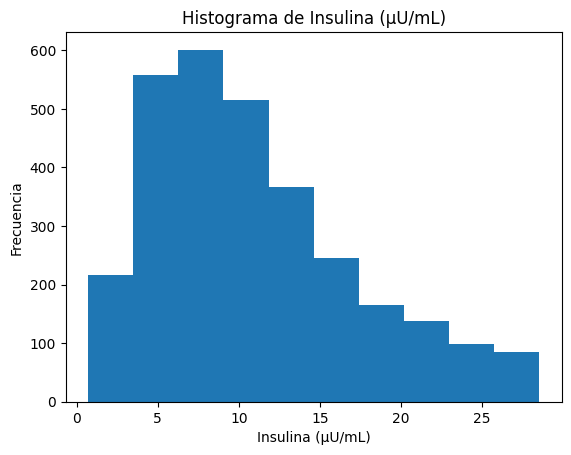

In [72]:
plt.hist(insulina_limpio["Insulina (μU/mL)"])
plt.title(f'Histograma de {"Insulina (μU/mL)"}')
plt.xlabel("Insulina (μU/mL)")
plt.ylabel('Frecuencia')
plt.show()

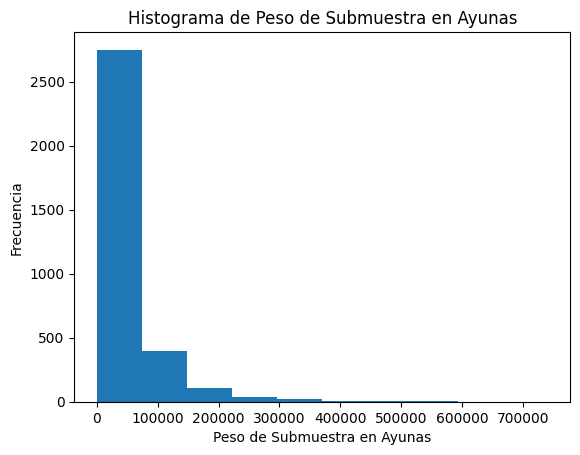

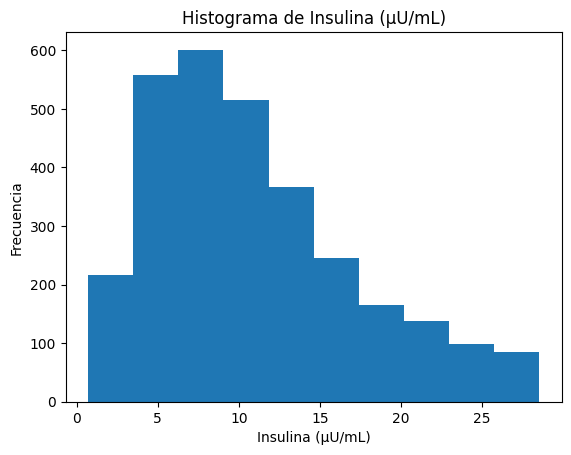

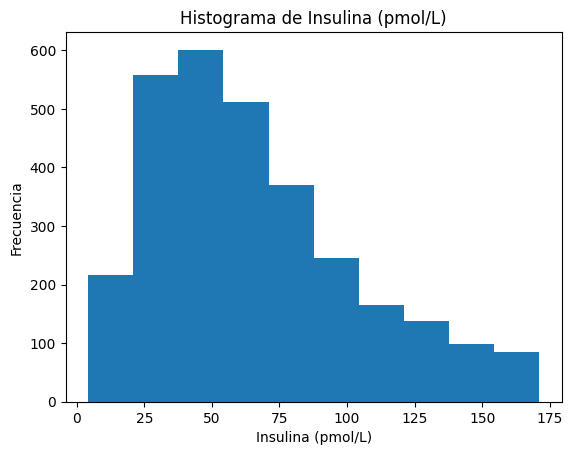

In [73]:
for col in insulina_limpio.columns[7:-1]:
  plt.hist(insulina_limpio[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [74]:
escalado = scaler.fit_transform(insulina_limpio[["Insulina (μU/mL)"]])
minmaxesc = minmax.fit_transform(insulina_limpio[["Insulina (μU/mL)"]])
powerTrans = pt.fit_transform(insulina_limpio[["Insulina (μU/mL)"]])

In [75]:
insulina_escalado = insulina_limpio.copy()
insulina_minmax = insulina_limpio.copy()
insulina_power = insulina_limpio.copy()
insulina_escalado["Insulina (μU/mL)"]=escalado
insulina_minmax["Insulina (μU/mL)"]=minmaxesc
insulina_power["Insulina (μU/mL)"]=powerTrans

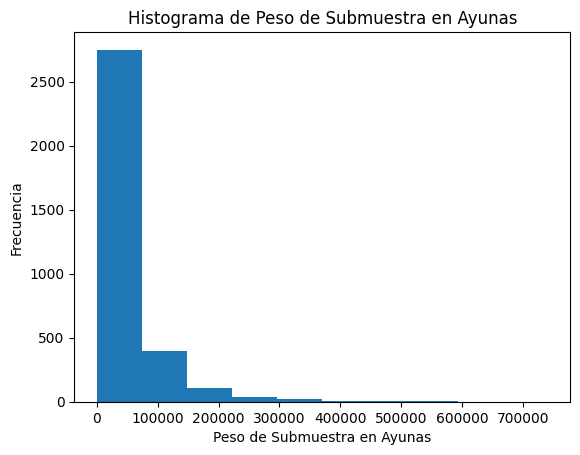

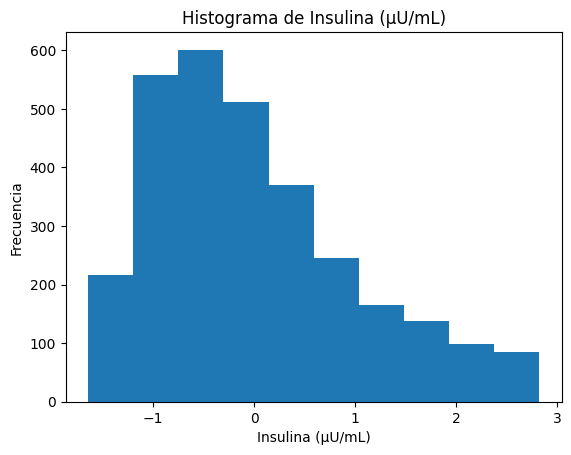

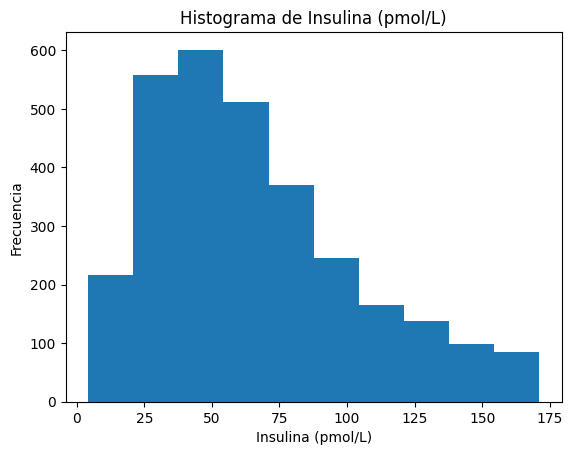

In [76]:
for col in insulina_escalado.columns[7:-1]:
  plt.hist(insulina_escalado[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

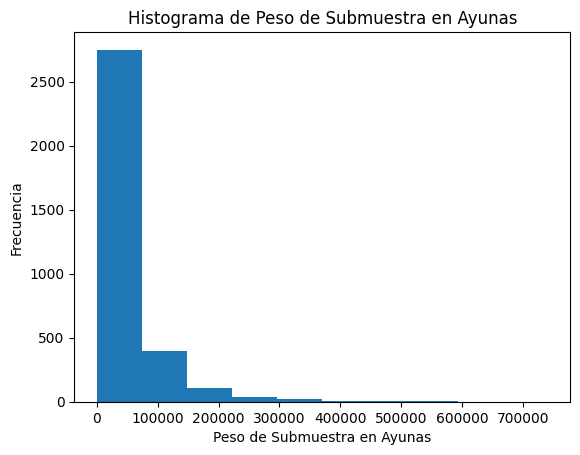

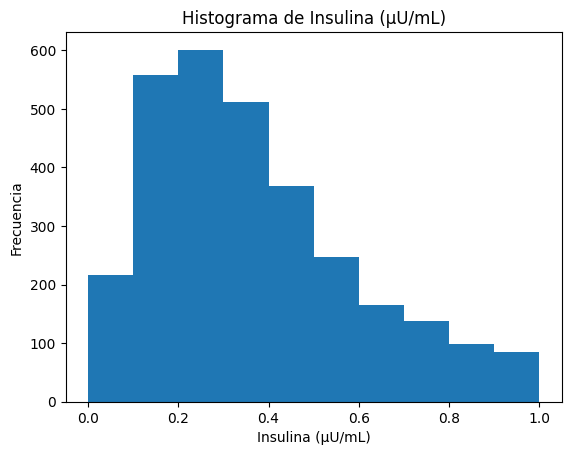

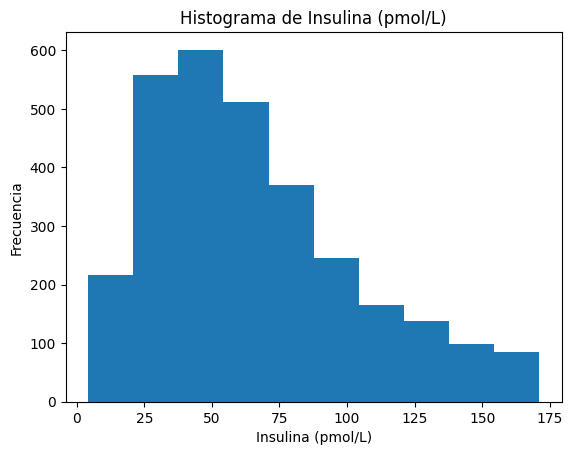

In [77]:
for col in insulina_minmax.columns[7:-1]:
  plt.hist(insulina_minmax[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [78]:
Q1 = insulina_escalado["Insulina (μU/mL)"].quantile(0.25)
Q3 = insulina_escalado["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = insulina_escalado[(insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
limpieza_insulina = insulina_escalado[~((insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

 El IQR es 1.3341734967127177. El límite inferior es: -2.7685061346628896, el superior es 2.5681878521879806
49


In [79]:
limp_ins = limpieza_insulina.copy()
limp_ins["Insulina (μU/mL)"] = pt.fit_transform(limp_ins[["Insulina (μU/mL)"]])

[09/10/24 12:29:11] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=944300;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=938190;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

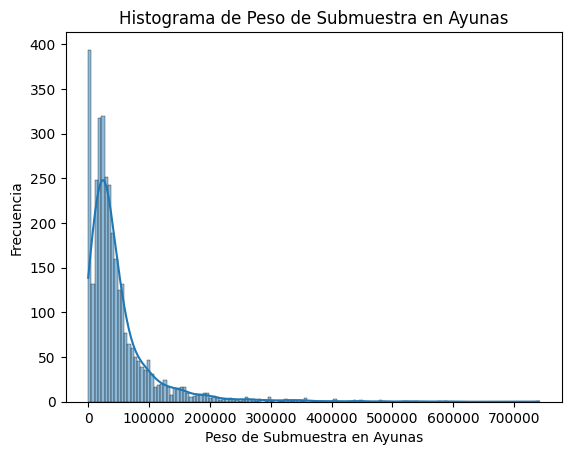

[09/10/24 12:29:12] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=791554;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=425159;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

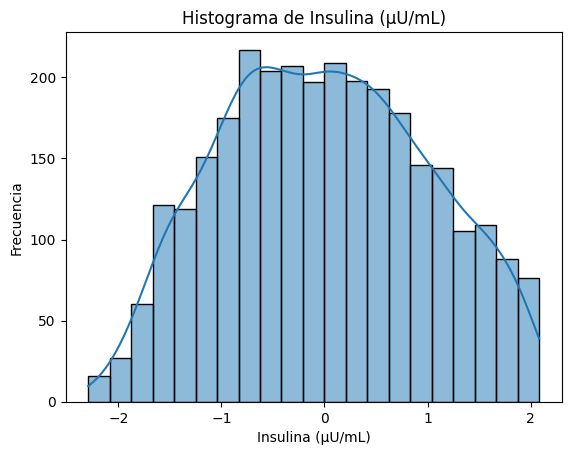

[09/10/24 12:29:13] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=209190;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=46263;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

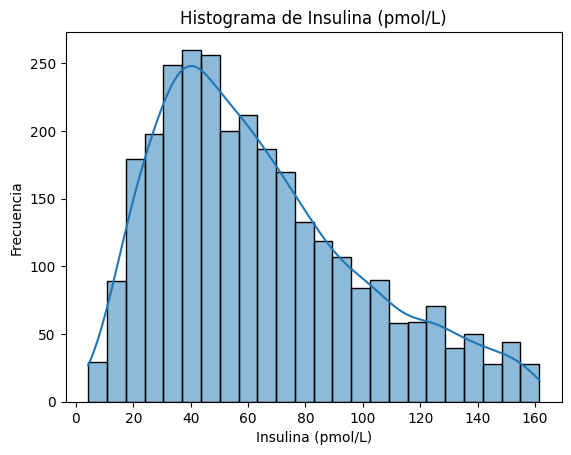

In [80]:
for col in insulina_power.columns[7:-1]:
  sns.histplot(data=limp_ins, x=col, kde=True)
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [81]:
limp_ins.isna().sum()


ID                                    0
Edad                                  0
Genero                                0
Raza                                  0
Educacion                             0
EstadoCivil                          59
NivelPobreza                          0
Peso de Submuestra en Ayunas          0
Insulina (μU/mL)                    343
Insulina (pmol/L)                   343
Código de Comentario de Insulina    343
dtype: int64

In [82]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
limp_ins["Insulina (μU/mL)"] = knn_imputer.fit_transform(limp_ins[["Insulina (μU/mL)"]])

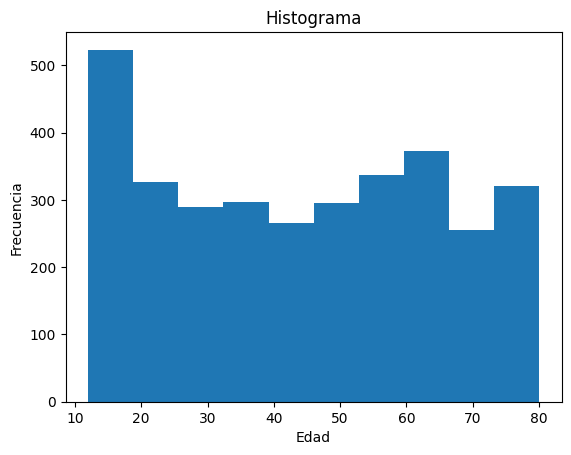

In [83]:
plt.hist(limp_ins["Edad"])
plt.title(f'Histograma')
plt.xlabel("Edad")
plt.ylabel('Frecuencia')
plt.show()

In [84]:

limp_ins["Edad"], lambda_opt = boxcox(limp_ins["Edad"] + 1)

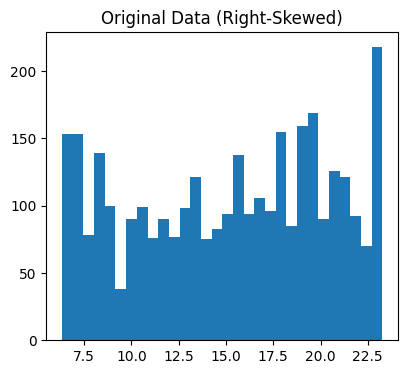

In [85]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(limp_ins["Edad"], bins=30)
plt.title('Original Data (Right-Skewed)')
plt.show()

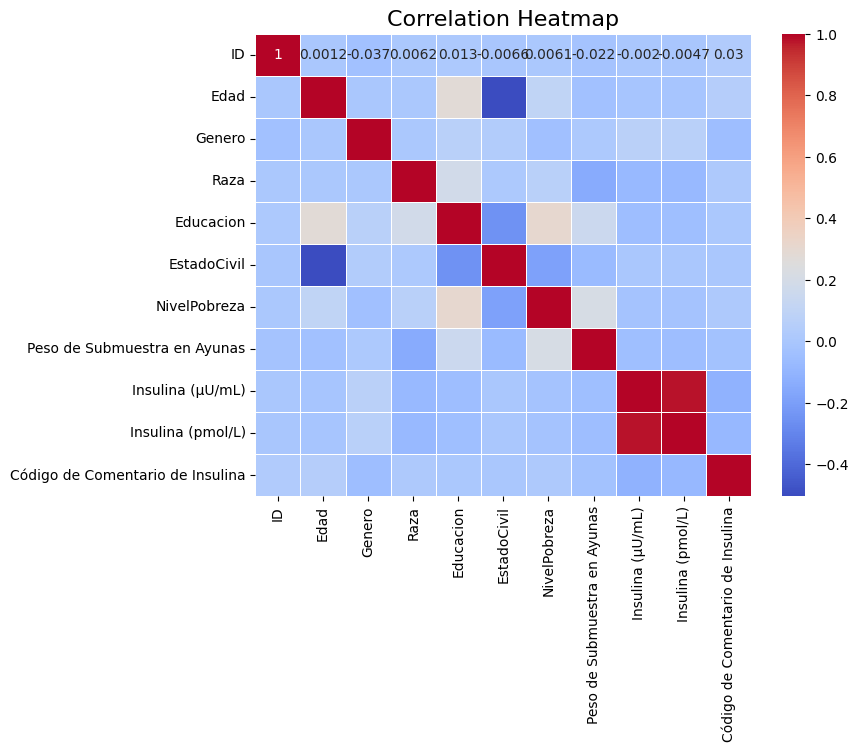

In [86]:
corr_matrix = limp_ins.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Conclusión: SIGUE SIN HABER RELACIÓN >:(

In [87]:
#insulina_nonna = consideracion_insulina.dropna()

# Combinación de Dataset con Colesterol

In [88]:
consideracion_colesterol = pd.merge(consideracion, colesterol, on='ID', how='inner')

In [89]:
consideracion_colesterol.head()

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0 109264.00 13.00    2.00  1.00       1.00         3.00          0.91   
1 109270.00 11.00    2.00  4.00       1.00         3.00          1.37   
2 109273.00 36.00    1.00  3.00       4.00         3.00          0.91   
3 109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
4 109275.00  6.00    1.00  3.00       1.00         3.00          1.93   

   Colesterol Total (mg/dL)  Colesterol Total (mmol/L)  
0                    166.00                       4.29  
1                    103.00                       2.66  
2                    164.00                       4.24  
3                    105.00                       2.72  
4                    167.00                       4.32

In [90]:
consideracion_colesterol.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   8850.00 8850.00 8850.00 8850.00    8850.00      8691.00       8850.00   
mean  117107.10   38.22    1.51    3.45       2.76         2.08          1.31   
std     4477.06   23.35    0.50    1.61       1.38         1.21          0.49   
min   109264.00    6.00    1.00    1.00       1.00         1.00          0.00   
25%   113263.50   16.00    1.00    3.00       1.00         1.00          0.97   
50%   117163.50   36.00    2.00    3.00       3.00         2.00          1.30   
75%   121016.75   59.00    2.00    4.00       4.00         3.00          1.67   
max   124821.00   80.00    2.00    7.00       9.00        77.00          2.23   

       Colesterol Total (mg/dL)  Colesterol Total (mmol/L)  
count                   7840.00                    7840.00  
mean                     176.14                       4.55  
std                       40.15                       1.04  
min                       73.00                       1.89  
25%                      148.00                       3.83  
50%                      171.00                       4.42  
75%                      200.00                       5.17  
max                      446.00                      11.53

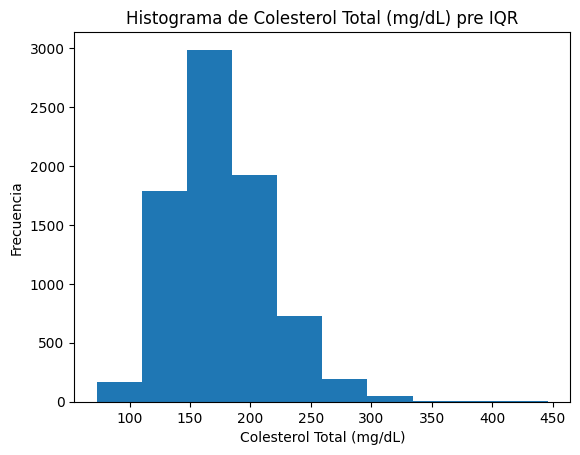

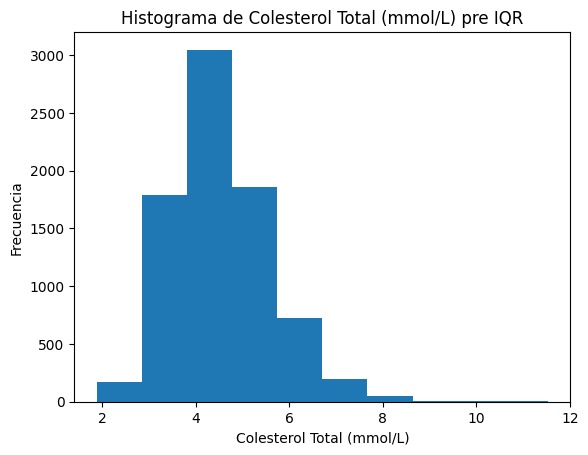

In [91]:
for col in consideracion_colesterol.columns[7:]:
  plt.hist(consideracion_colesterol[col])
  plt.title(f'Histograma de {col} pre IQR')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [92]:
Q1 = consideracion_colesterol["Colesterol Total (mg/dL)"].quantile(0.25)
Q3 = consideracion_colesterol["Colesterol Total (mg/dL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers_colesterol = consideracion_colesterol[(consideracion_colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (consideracion_colesterol["Colesterol Total (mg/dL)"] > upper_bound)]

# Removing outliers
consideracion_colesterol_limpio = consideracion_colesterol[~((consideracion_colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (consideracion_colesterol["Colesterol Total (mg/dL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers_colesterol)

print(num_outliers)

 El IQR es 52.0. El límite inferior es: 70.0, el superior es 278.0
133


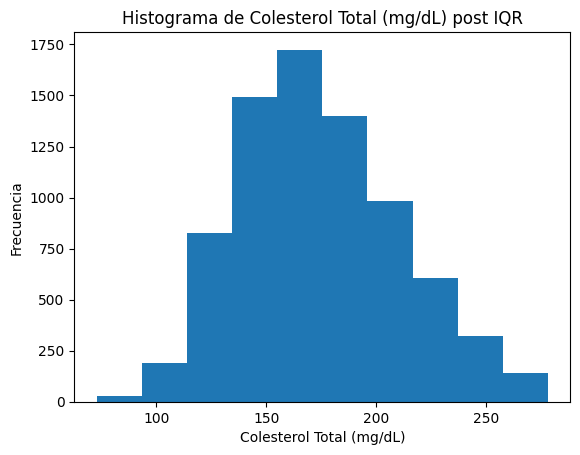

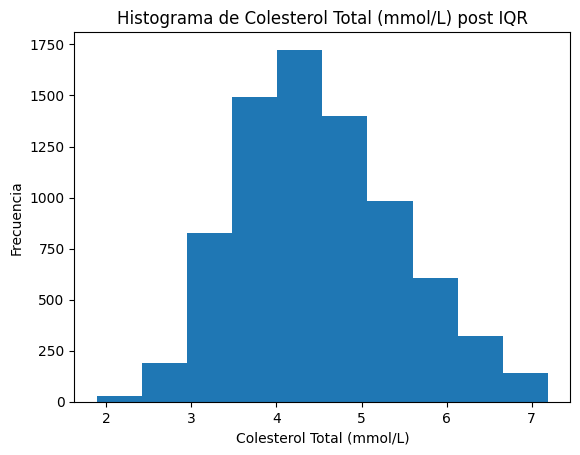

In [93]:
for col in consideracion_colesterol_limpio.columns[7:]:
  plt.hist(consideracion_colesterol_limpio[col])
  plt.title(f'Histograma de {col} post IQR')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

# Combinación de Dataset con Proteína C Spoiler: No pude lograr la distribución normal en la proteína :(

In [94]:
consideracion_proteinaC = pd.merge(consideracion, proteinaC, on='ID', how='inner')

In [95]:
consideracion_proteinaC.isna().sum()


ID                                                0
Edad                                              0
Genero                                            0
Raza                                              0
Educacion                                         0
EstadoCivil                                     159
NivelPobreza                                      0
Proteína C Reactiva (mg/L)                     1635
Código de Comentario de Proteína C Reactiva    1635
dtype: int64

In [96]:
consideracion_proteinaC.describe()

ID     Edad   Genero     Raza  Educacion  EstadoCivil  \
count  10086.00 10086.00 10086.00 10086.00   10086.00      9927.00   
mean  117117.73    33.88     1.51     3.45       2.54         2.20   
std     4483.25    24.77     0.50     1.61       1.41         1.17   
min   109263.00     1.00     1.00     1.00       1.00         1.00   
25%   113272.75    11.00     1.00     3.00       1.00         1.00   
50%   117187.50    29.00     2.00     3.00       2.00         3.00   
75%   121023.75    56.00     2.00     4.00       4.00         3.00   
max   124821.00    80.00     2.00     7.00       9.00        77.00   

       NivelPobreza  Proteína C Reactiva (mg/L)  \
count      10086.00                     8451.00   
mean           1.29                        3.50   
std            0.49                        7.75   
min            0.00                        0.11   
25%            0.95                        0.52   
50%            1.28                        1.35   
75%            1.66                        3.71   
max            2.23                      246.86   

       Código de Comentario de Proteína C Reactiva  
count                                      8451.00  
mean                                          0.04  
std                                           0.19  
min                                           0.00  
25%                                           0.00  
50%                                           0.00  
75%                                           0.00  
max                                           1.00

In [97]:
Q1 = consideracion_proteinaC["Proteína C Reactiva (mg/L)"].quantile(0.25)
Q3 = consideracion_proteinaC["Proteína C Reactiva (mg/L)"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 0.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

outliers_proteinac = consideracion_proteinaC[(consideracion_proteinaC["Proteína C Reactiva (mg/L)"] < lower_bound) | (consideracion_proteinaC["Proteína C Reactiva (mg/L)"] > upper_bound)]

proteinac_limpio = consideracion_proteinaC[~((consideracion_proteinaC["Proteína C Reactiva (mg/L)"] < lower_bound) | (consideracion_proteinaC["Proteína C Reactiva (mg/L)"] > upper_bound))]

num_outliers = len(outliers_proteinac)

print(num_outliers)

 El IQR es 3.185. El límite inferior es: -1.0725, el superior es 5.2975
1471


In [98]:
proteina_c = proteinac_limpio.copy()
proteina_c[['Proteína C Reactiva (mg/L)']] = knn_imputer.fit_transform(proteina_c[['Proteína C Reactiva (mg/L)']])

In [99]:
proteina_c.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   8615.00 8615.00 8615.00 8615.00    8615.00      8481.00       8615.00   
mean  117090.00   31.97    1.49    3.48       2.45         2.25          1.30   
std     4469.56   24.86    0.50    1.63       1.42         1.21          0.50   
min   109263.00    1.00    1.00    1.00       1.00         1.00          0.00   
25%   113275.50   10.00    1.00    3.00       1.00         1.00          0.95   
50%   117149.00   25.00    1.00    3.00       2.00         3.00          1.28   
75%   120965.00   54.00    2.00    4.00       4.00         3.00          1.67   
max   124821.00   80.00    2.00    7.00       9.00        77.00          2.23   

       Proteína C Reactiva (mg/L)  Código de Comentario de Proteína C Reactiva  
count                     8615.00                                      6980.00  
mean                         1.47                                         0.05  
std                          1.18                                         0.21  
min                          0.11                                         0.00  
25%                          0.53                                         0.00  
50%                          1.41                                         0.00  
75%                          1.81                                         0.00  
max                          5.29                                         1.00

In [100]:
pro_c = proteina_c.copy()
pro_c["Proteína C Reactiva (mg/L)"] = minmax.fit_transform(pro_c[["Proteína C Reactiva (mg/L)"]])

[09/10/24 12:29:17] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=897251;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=713127;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

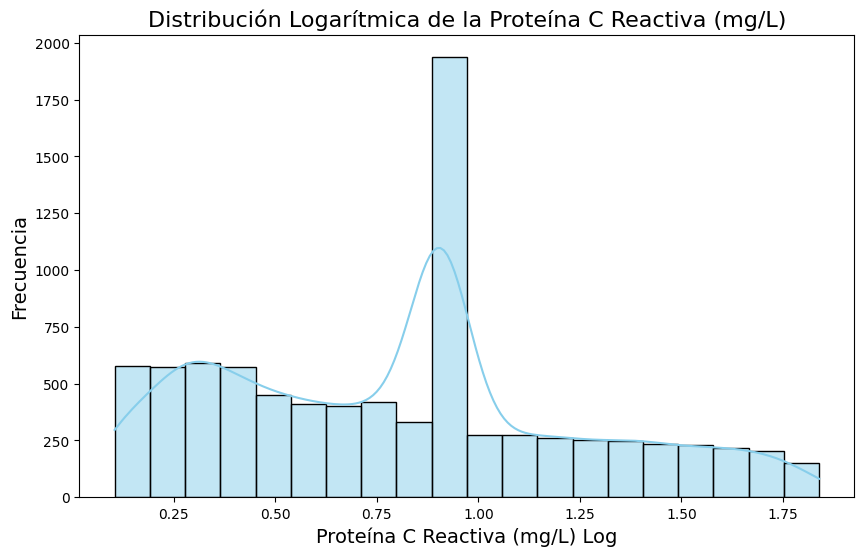

In [101]:
# Aplicar la transformación logarítmica
proteina_c['Proteína C Reactiva (mg/L) Log'] = np.log1p(proteina_c['Proteína C Reactiva (mg/L)'])

# Visualizar la distribución después de la transformación logarítmica
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) Log'].dropna(), bins=20, kde=True, color="skyblue")
plt.title('Distribución Logarítmica de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) Log', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

[09/10/24 12:29:18] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=282984;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=41217;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

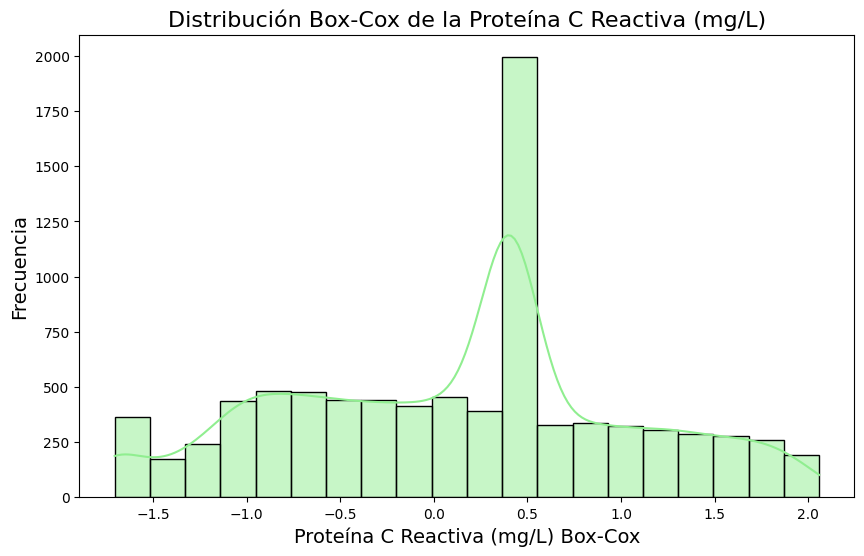

In [102]:
# Aplicar la transformación Box-Cox (requiere valores positivos)
proteina_c_positive = proteina_c[proteina_c['Proteína C Reactiva (mg/L)'] > 0]
proteina_c['Proteína C Reactiva (mg/L) Box-Cox'], _ = stats.boxcox(proteina_c_positive['Proteína C Reactiva (mg/L)'])

# Visualizar la distribución después de la transformación Box-Cox
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) Box-Cox'].dropna(), bins=20, kde=True, color="lightgreen")
plt.title('Distribución Box-Cox de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) Box-Cox', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

[09/10/24 12:29:19] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=342687;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=88762;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

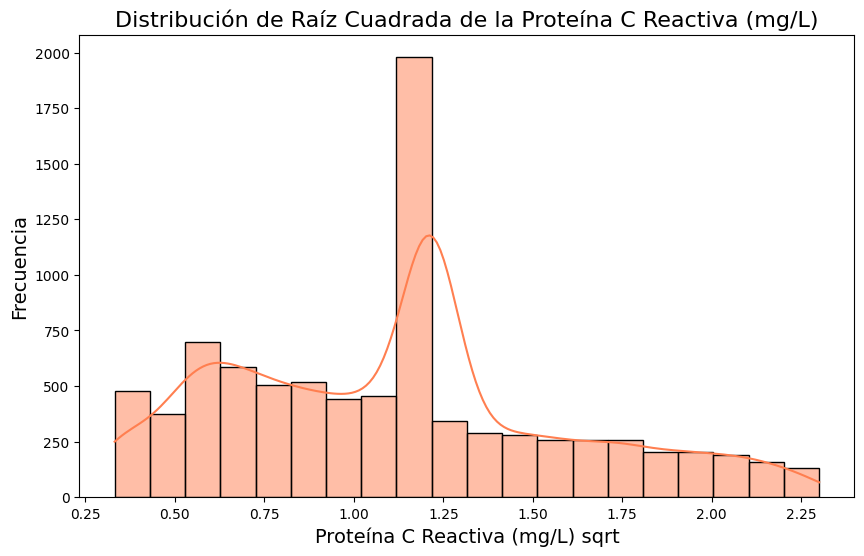

In [103]:
# Aplicar la transformación de raíz cuadrada
proteina_c['Proteína C Reactiva (mg/L) sqrt'] = np.sqrt(proteina_c['Proteína C Reactiva (mg/L)'])

# Visualizar la distribución después de la transformación de raíz cuadrada
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) sqrt'].dropna(), bins=20, kde=True, color="coral")
plt.title('Distribución de Raíz Cuadrada de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) sqrt', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

[09/10/24 12:29:20] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=930816;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=851009;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

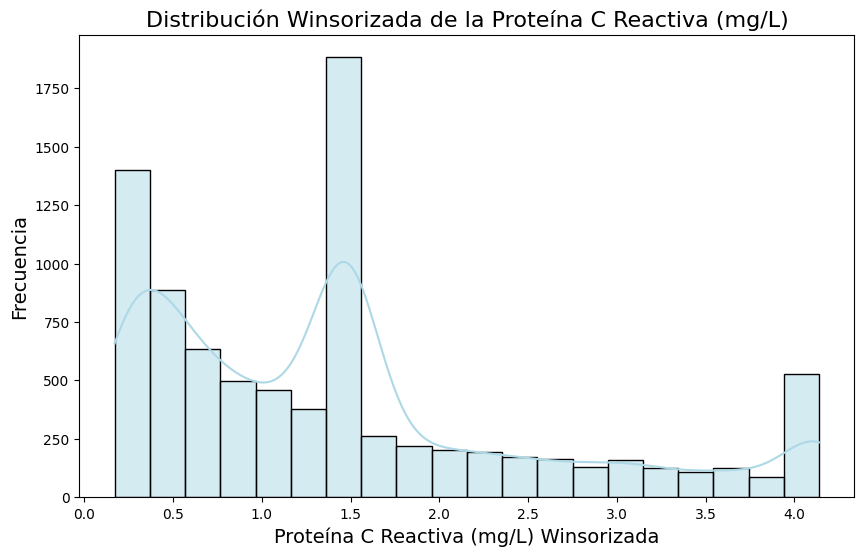

In [104]:
# Aplicar winsorización a los datos (cap los valores en el percentil 95)
proteina_c['Proteína C Reactiva (mg/L) Winsorizada'] = mstats.winsorize(proteina_c['Proteína C Reactiva (mg/L)'], limits=[0.05, 0.05])

# Visualizar la distribución después de la winsorización
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) Winsorizada'].dropna(), bins=20, kde=True, color="lightblue")
plt.title('Distribución Winsorizada de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) Winsorizada', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

# Combinación de Dataset con Depresión

In [105]:
consideracion_depresion = pd.merge(consideracion, depresion, on='ID', how='inner')

In [106]:
consideracion_depresion

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0    109273.00 36.00    1.00  3.00       4.00         3.00          0.91   
1    109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
2    109282.00 76.00    1.00  3.00       5.00         1.00          1.90   
3    109286.00 33.00    2.00  6.00       5.00         1.00          1.17   
4    109292.00 58.00    1.00  2.00       3.00         2.00          1.26   
...        ...   ...     ...   ...        ...          ...           ...   
6313 124810.00 56.00    2.00  4.00       4.00         3.00          1.39   
6314 124814.00 64.00    1.00  4.00       3.00         2.00          1.41   
6315 124817.00 67.00    2.00  1.00       2.00         1.00          1.48   
6316 124818.00 40.00    1.00  4.00       5.00         1.00          1.95   
6317 124821.00 63.00    1.00  4.00       2.00         2.00          1.93   

      Poco Interés en Hacer Cosas  Sentirse Deprimido o Sin Esperanza  \
0                            2.00                                2.00   
1                            0.00                                0.00   
2                            0.00                                1.00   
3                             NaN                                 NaN   
4                            0.00                                3.00   
...                           ...                                 ...   
6313                         0.00                                0.00   
6314                         0.00                                0.00   
6315                         1.00                                1.00   
6316                         0.00                                0.00   
6317                         3.00                                0.00   

      Problemas para Dormir  Cansancio o Poca Energía  \
0                      2.00                      2.00   
1                      0.00                      0.00   
2                      0.00                      1.00   
3                       NaN                       NaN   
4                      0.00                      2.00   
...                     ...                       ...   
6313                   0.00                      1.00   
6314                   0.00                      0.00   
6315                   1.00                      1.00   
6316                   0.00                      1.00   
6317                   0.00                      2.00   

      Poco Apetito o Comer en Exceso  Sentirse Mal Acerca de Uno Mismo  \
0                               2.00                              2.00   
1                               0.00                              0.00   
2                               0.00                              0.00   
3                                NaN                               NaN   
4                               0.00                              3.00   
...                              ...                               ...   
6313                            0.00                              0.00   
6314                            0.00                              0.00   
6315                            0.00                              0.00   
6316                            0.00                              0.00   
6317                            0.00                              0.00   

      Problemas de Concentración  Movimientos o Hablar Lento o Rápido  \
0                           2.00                                 1.00   
1                           0.00                                 0.00   
2                           0.00                                 3.00   
3                            NaN                                  NaN   
4                           0.00                                 0.00   
...                          ...                                  ...   
6313                        0.00                                 0.00   
6314                        0.00                                

In [107]:
consideracion_depresion.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   6318.00 6318.00 6318.00 6318.00    6318.00      6159.00       6318.00   
mean  117147.90   49.03    1.52    3.44       3.34         1.71          1.34   
std     4479.07   18.73    0.50    1.56       1.17         1.26          0.48   
min   109273.00   18.00    1.00    1.00       1.00         1.00          0.00   
25%   113321.25   33.00    1.00    3.00       3.00         1.00          1.00   
50%   117180.50   50.00    2.00    3.00       3.00         1.00          1.32   
75%   121072.50   64.00    2.00    4.00       4.00         2.00          1.70   
max   124821.00   80.00    2.00    7.00       9.00        77.00          2.23   

       Poco Interés en Hacer Cosas  Sentirse Deprimido o Sin Esperanza  \
count                      5870.00                             5869.00   
mean                          0.42                                0.40   
std                           0.81                                0.77   
min                           0.00                                0.00   
25%                           0.00                                0.00   
50%                           0.00                                0.00   
75%                           1.00                                1.00   
max                           9.00                                9.00   

       Problemas para Dormir  Cansancio o Poca Energía  \
count                5869.00                   5869.00   
mean                    0.70                      0.80   
std                     1.02                      0.98   
min                     0.00                      0.00   
25%                     0.00                      0.00   
50%                     0.00                      1.00   
75%                     1.00                      1.00   
max                     9.00                      9.00   

       Poco Apetito o Comer en Exceso  Sentirse Mal Acerca de Uno Mismo  \
count                         5869.00                           5868.00   
mean                             0.44                              0.28   
std                              0.85                              0.69   
min                              0.00                              0.00   
25%                              0.00                              0.00   
50%                              0.00                              0.00   
75%                              1.00                              0.00   
max                              9.00                              9.00   

       Problemas de Concentración  Movimientos o Hablar Lento o Rápido  \
count                     5868.00                              5868.00   
mean                         0.30                                 0.19   
std                          0.75                                 0.62   
min                          0.00                                 0.00   
25%                          0.00                                 0.00   
50%                          0.00                                 0.00   
75%                          0.00                                 0.00   
max                          9.00                                 9.00   

       Pensamientos de Muerte o Autolesión  \
count                              5866.00   
mean                                  0.06   
std                                   0.36   
min                                   0.00   
25%                                   0.00   
50%                                   0.00   
75%                                   0.00   
max                                   9.00   

       Dificultad que Estos Problemas Causan  
count                                4015.00  
mean                                    0.36  
std                                     0.66  
min                                     0.00  
25%                                     0.00  
50%                                     0.00  
75%   

In [108]:
def detectar_outliers_zscore(df, columna, umbral=3):
    z_scores = np.abs(stats.zscore(df[columna].dropna()))
    z_scores_series = pd.Series(z_scores, index=df[columna].dropna().index)
    outliers = df.loc[z_scores_series[z_scores_series > umbral].index]
    return outliers
    
outliers_zscore = detectar_outliers_zscore(depresion, 'Poco Interés en Hacer Cosas')
display(outliers_zscore)

ID  Poco Interés en Hacer Cosas  \
94   109459.00                         3.00   
131  109530.00                         3.00   
145  109551.00                         3.00   
190  109630.00                         3.00   
214  109673.00                         3.00   
...        ...                          ...   
8838 124615.00                         3.00   
8879 124690.00                         3.00   
8901 124726.00                         3.00   
8908 124737.00                         3.00   
8963 124821.00                         3.00   

      Sentirse Deprimido o Sin Esperanza  Problemas para Dormir  \
94                                  0.00                   2.00   
131                                 1.00                   1.00   
145                                 1.00                   1.00   
190                                 1.00                   0.00   
214                                 3.00                   3.00   
...                                  ...                    ...   
8838                                2.00                   3.00   
8879                                2.00                   1.00   
8901                                3.00                   3.00   
8908                                0.00                   1.00   
8963                                0.00                   0.00   

      Cansancio o Poca Energía  Poco Apetito o Comer en Exceso  \
94                        3.00                            3.00   
131                       1.00                            2.00   
145                       2.00                            0.00   
190                       3.00                            0.00   
214                       2.00                            2.00   
...                        ...                             ...   
8838                      3.00                            2.00   
8879                      3.00                            0.00   
8901                      3.00                            3.00   
8908                      2.00                            3.00   
8963                      2.00                            0.00   

      Sentirse Mal Acerca de Uno Mismo  Problemas de Concentración  \
94                                1.00                        1.00   
131                               0.00                        2.00   
145                               3.00                        2.00   
190                               0.00                        0.00   
214                               3.00                        3.00   
...                                ...                         ...   
8838                              1.00                        3.00   
8879                              0.00                        0.00   
8901                              3.00                        2.00   
8908                              0.00                        1.00   
8963                              0.00                        0.00   

      Movimientos o Hablar Lento o Rápido  \
94                                   1.00   
131                                  0.00   
145                                  2.00   
190                                  1.00   
214                                  3.00   
...                                   ...   
8838                                 3.00   
8879                                 0.00   
8901                                 0.00   
8908                                 0.00   
8963                                 0.00   

      Pensamientos de Muerte o Autolesión  \
94                                   0.00   
131                                  0.00   
145                                  0.00   
190                                  0.00   
214                                  0.00   
...                                   ...   
8838                                 0.00   
8879                                 0.00   
8901                                 3.00   
8908             

[09/10/24 12:29:21] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=959216;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=463570;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

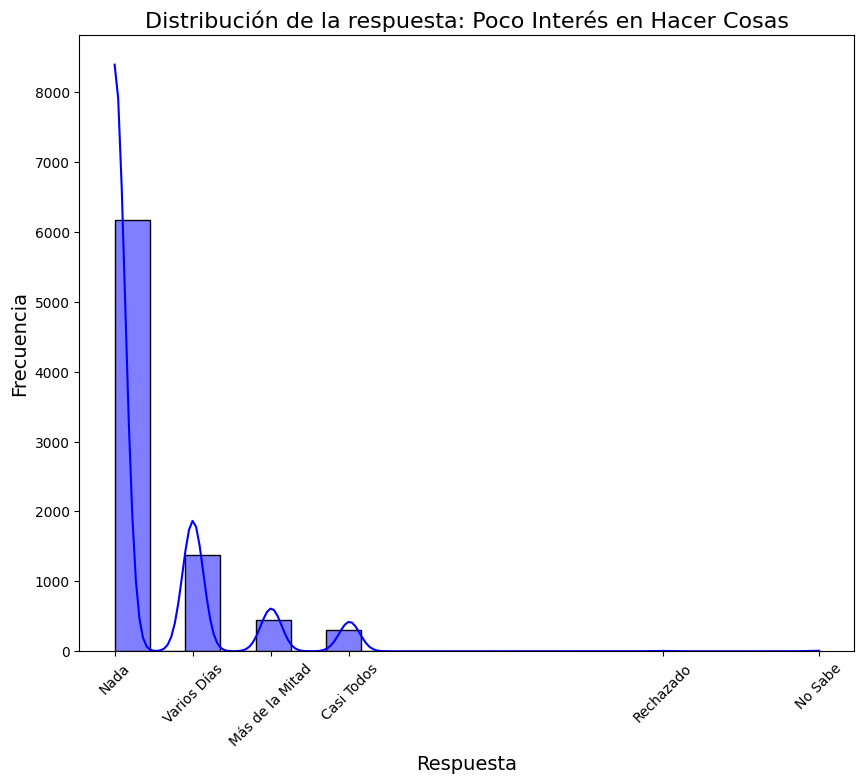

In [109]:
# Histograma de la columna 'Poca Interés en Hacer Cosas'
plt.figure(figsize=(10, 8))
sns.histplot(depresion['Poco Interés en Hacer Cosas'].dropna(), bins=20, kde=True, color="blue")
plt.title('Distribución de la respuesta: Poco Interés en Hacer Cosas', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(ticks=[0, 1, 2, 3, 7, 9], labels=['Nada', 'Varios Días', 'Más de la Mitad', 'Casi Todos', 'Rechazado', 'No Sabe'])
plt.xticks(rotation=45)  # Rota las etiquetas del eje X 45 grados
plt.show()

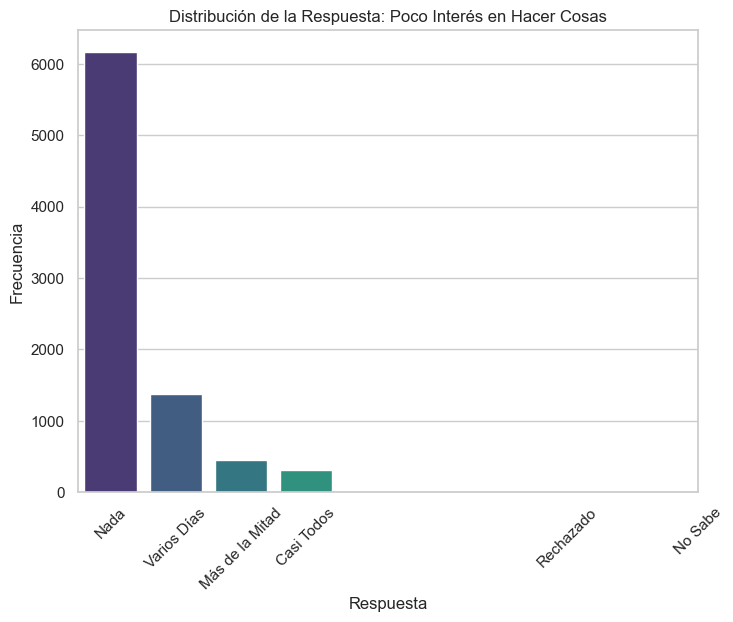

In [110]:
sns.set(style="whitegrid")

# Pregunta 1: Distribución para 'Poca Interés en Hacer Cosas' (DPQ010)
plt.figure(figsize=(8, 6))
sns.countplot(x='Poco Interés en Hacer Cosas', data=depresion, palette="viridis")
plt.title('Distribución de la Respuesta: Poco Interés en Hacer Cosas')
plt.xlabel('Respuesta')
plt.ylabel('Frecuencia')
plt.xticks(ticks=[0, 1, 2, 3, 7, 9], labels=['Nada', 'Varios Días', 'Más de la Mitad', 'Casi Todos', 'Rechazado', 'No Sabe'])
plt.xticks(rotation=45)  # Rota las etiquetas del eje X 45 grados
plt.show()

[09/10/24 12:29:23] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=831004;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=365400;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

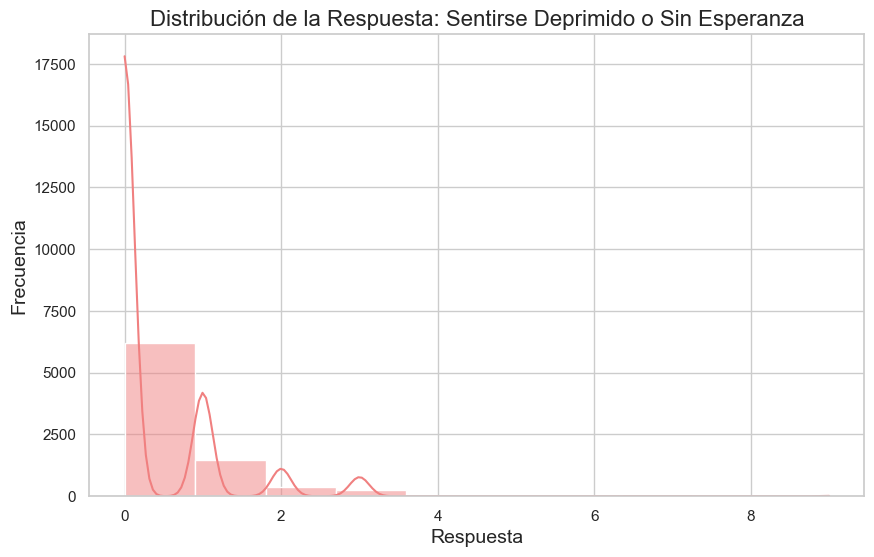

In [111]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Sentirse Deprimido o Sin Esperanza'].dropna(), bins=10, kde=True, color="lightcoral")
plt.title('Distribución de la Respuesta: Sentirse Deprimido o Sin Esperanza', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

                    WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=698310;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=487726;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

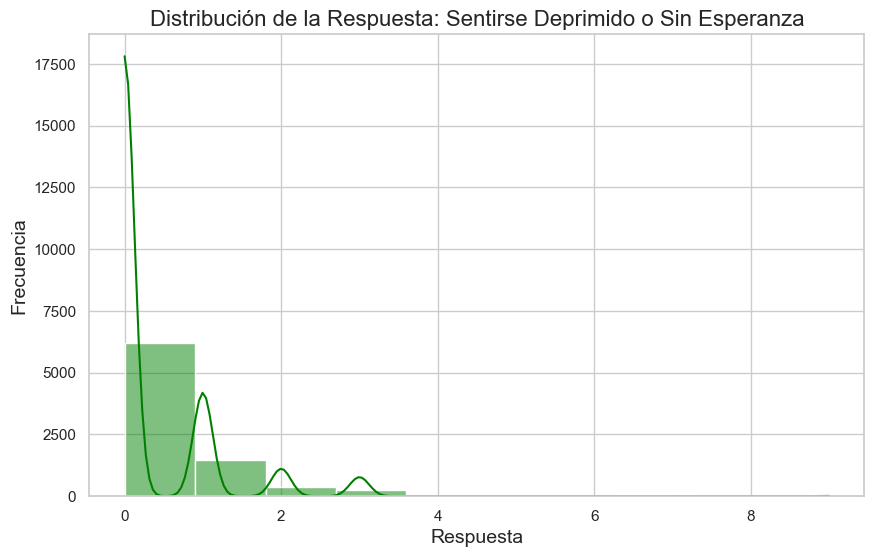

In [112]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Sentirse Deprimido o Sin Esperanza'].dropna(), bins=10, kde=True, color="green")
plt.title('Distribución de la Respuesta: Sentirse Deprimido o Sin Esperanza', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

[09/10/24 12:29:24] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=936282;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=560063;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

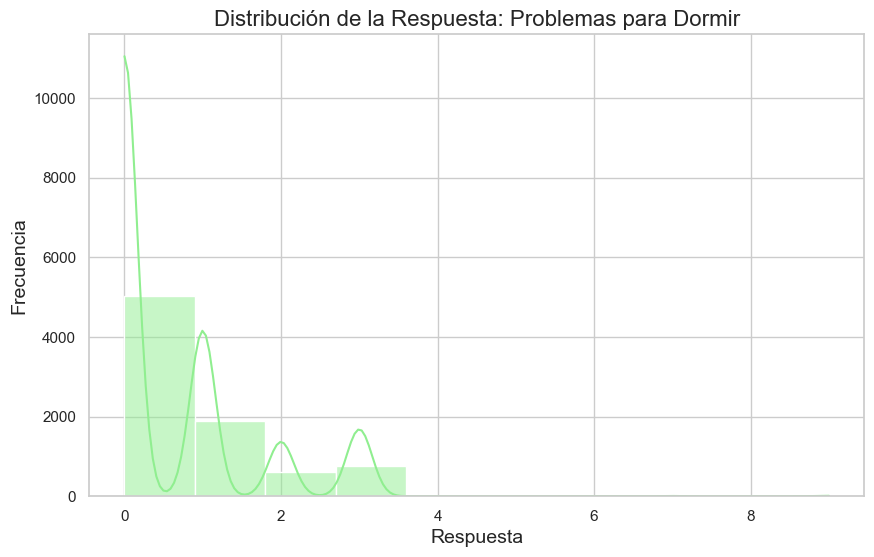

In [113]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Problemas para Dormir'].dropna(), bins=10, kde=True, color="lightgreen")
plt.title('Distribución de la Respuesta: Problemas para Dormir', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

[09/10/24 12:29:25] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=277764;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=256179;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

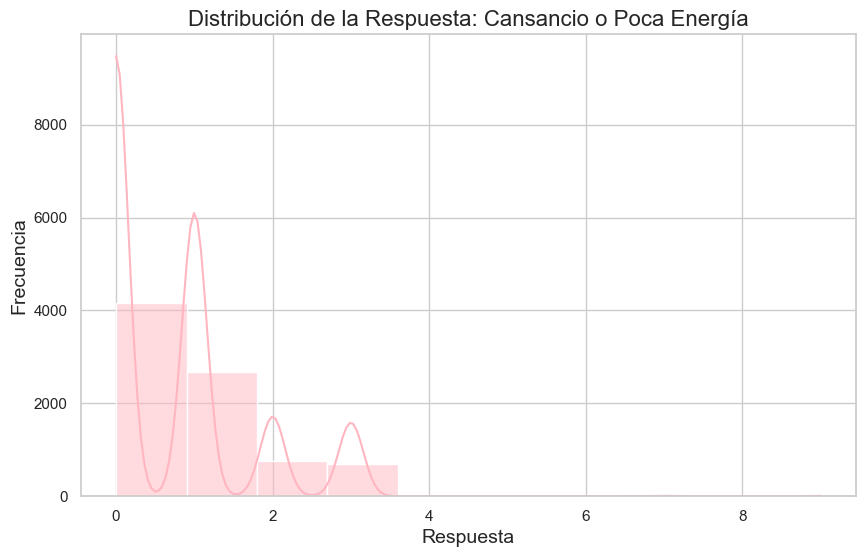

In [114]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Cansancio o Poca Energía'].dropna(), bins=10, kde=True, color="lightpink")
plt.title('Distribución de la Respuesta: Cansancio o Poca Energía', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

[09/10/24 12:29:26] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=305646;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=215622;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

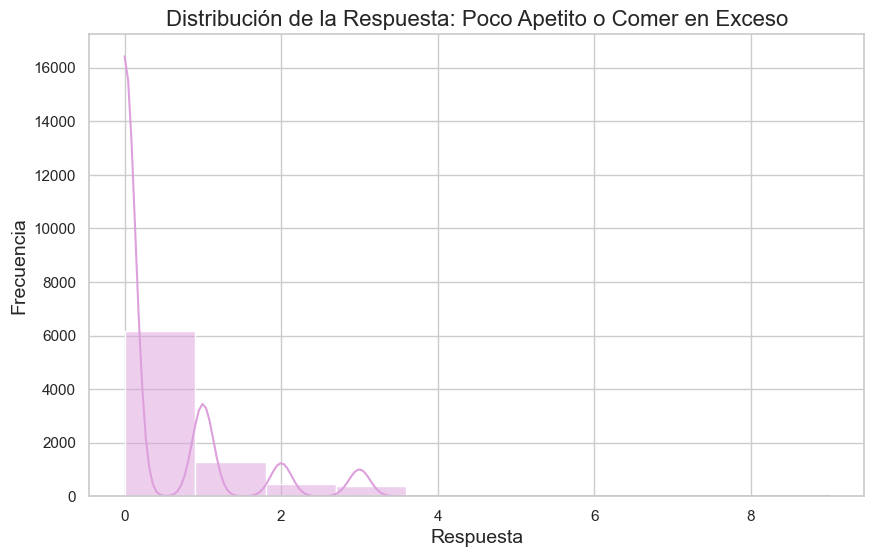

In [115]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Poco Apetito o Comer en Exceso'].dropna(), bins=10, kde=True, color="plum")
plt.title('Distribución de la Respuesta: Poco Apetito o Comer en Exceso', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

                    WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=279004;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=219754;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

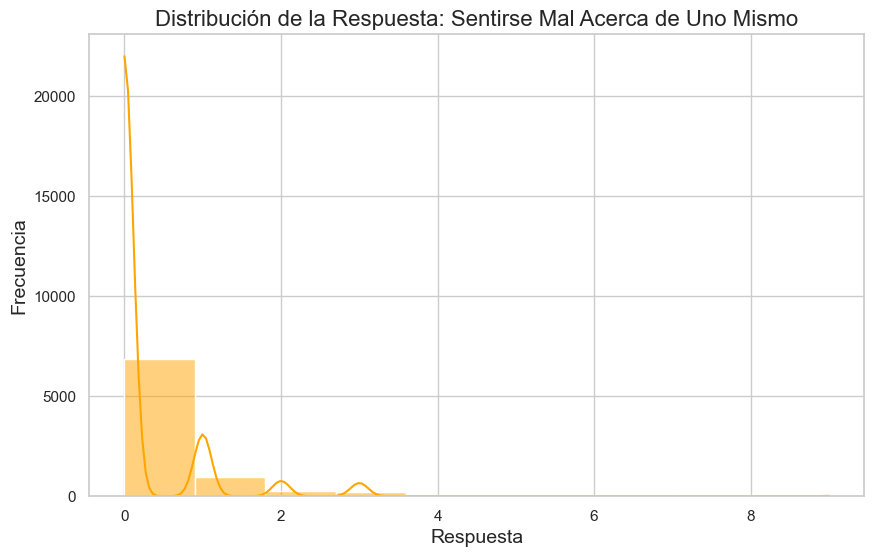

In [116]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Sentirse Mal Acerca de Uno Mismo'].dropna(), bins=10, kde=True, color="orange")
plt.title('Distribución de la Respuesta: Sentirse Mal Acerca de Uno Mismo', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

[09/10/24 12:29:27] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=948170;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=335746;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

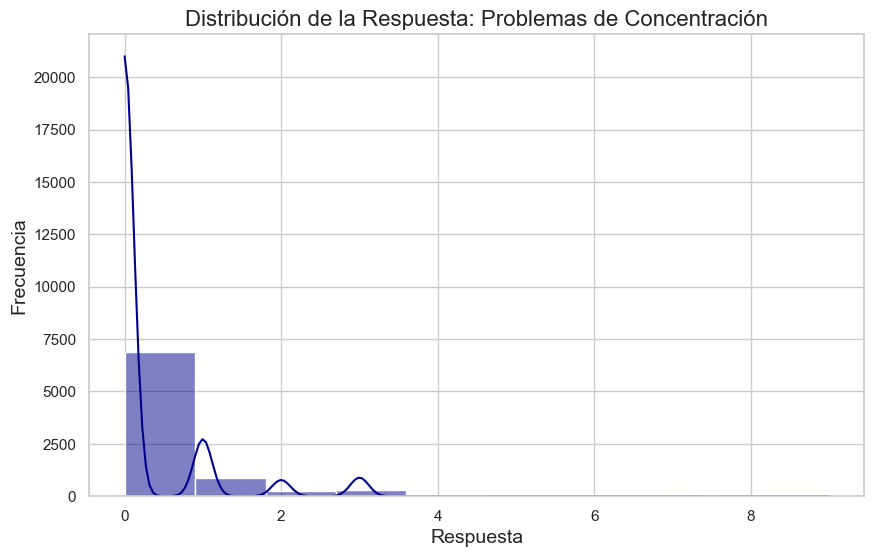

In [117]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Problemas de Concentración'].dropna(), bins=10, kde=True, color="darkblue")
plt.title('Distribución de la Respuesta: Problemas de Concentración', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

[09/10/24 12:29:28] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=750688;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=464590;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

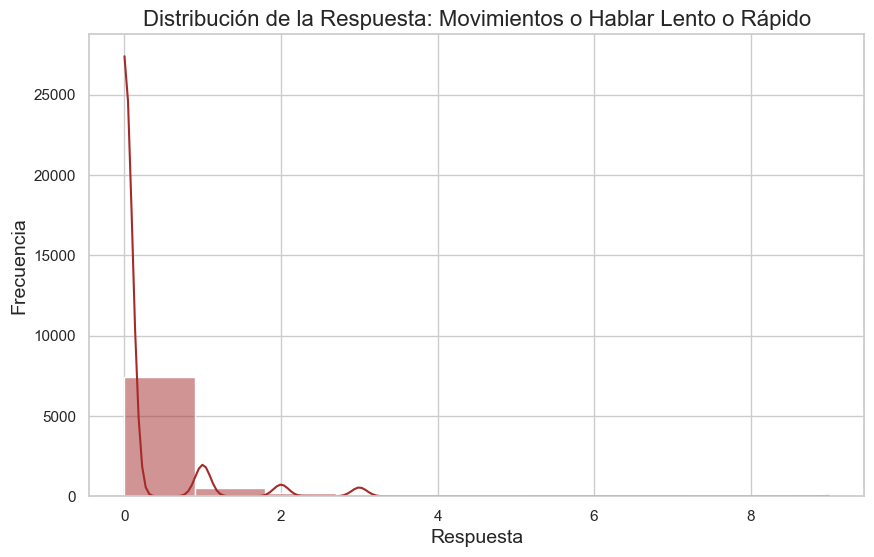

In [118]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Movimientos o Hablar Lento o Rápido'].dropna(), bins=10, kde=True, color="brown")
plt.title('Distribución de la Respuesta: Movimientos o Hablar Lento o Rápido', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

[09/10/24 12:29:29] WARNING  C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\sea ]8;id=762694;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=436252;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             born\_oldcore.py:1119: FutureWarning: use_inf_as_na option is                         
                             deprecated and will be removed in a future version. Convert inf values                
                             to NaN before operating instead.                                                      
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

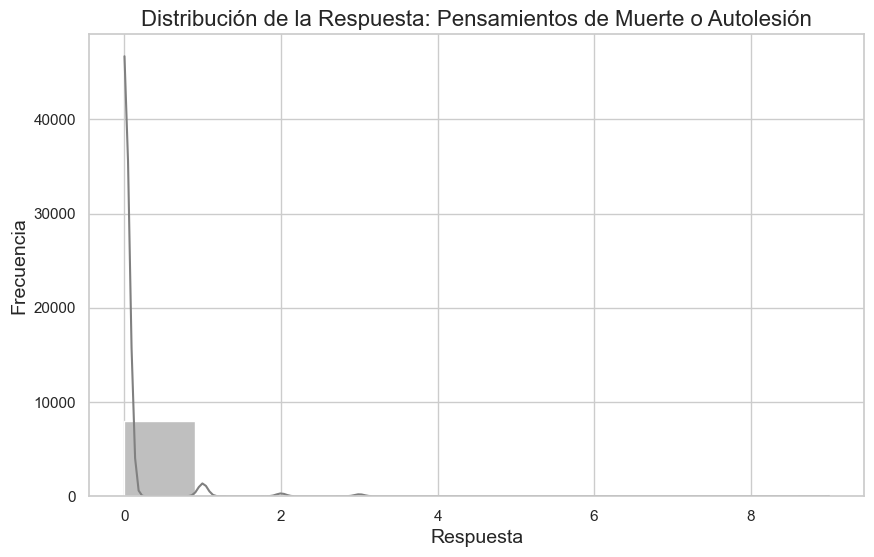

In [119]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Pensamientos de Muerte o Autolesión'].dropna(), bins=10, kde=True, color="grey")
plt.title('Distribución de la Respuesta: Pensamientos de Muerte o Autolesión', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [120]:
df= pd.merge(consideracion, insulina, on='ID', how='inner')

In [121]:
df.head()

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0 109264.00 13.00    2.00  1.00       1.00         3.00          0.91   
1 109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
2 109277.00 12.00    2.00  1.00       1.00         3.00          1.16   
3 109282.00 76.00    1.00  3.00       5.00         1.00          1.90   
4 109286.00 33.00    2.00  6.00       5.00         1.00          1.17   

   Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
0                      27533.17              6.05              36.30   
1                      16281.76             13.52              81.12   
2                      32230.05              6.44              38.64   
3                      79007.10              7.49              44.94   
4                          0.00             16.46              98.76   

   Código de Comentario de Insulina  
0                              0.00  
1                              0.00  
2                              0.00  
3                              0.00  
4                              0.00

In [122]:
df.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3650.00 3650.00 3650.00 3650.00    3650.00      3582.00       3650.00   
mean  117187.07   43.93    1.52    3.45       3.10         1.87          1.33   
std     4467.37   20.82    0.50    1.62       1.24         0.88          0.48   
min   109264.00   12.00    1.00    1.00       1.00         1.00          0.00   
25%   113370.75   25.00    1.00    3.00       2.00         1.00          1.00   
50%   117331.50   44.00    2.00    3.00       3.00         2.00          1.31   
75%   121059.25   62.00    2.00    4.00       4.00         3.00          1.68   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
count                       3650.00           3307.00            3307.00   
mean                       48912.22             15.45              92.69   
std                        60974.78             23.11             138.67   
min                            0.00              0.71               4.26   
25%                        16798.02              6.49              38.94   
50%                        31798.15             10.38              62.28   
75%                        57227.95             17.15             102.90   
max                       741259.19            485.10            2910.60   

       Código de Comentario de Insulina  
count                           3307.00  
mean                               0.00  
std                                0.05  
min                                0.00  
25%                                0.00  
50%                                0.00  
75%                                0.00  
max                                1.00

In [123]:
df2= pd.merge(df, colesterol, on='ID', how='inner')

In [124]:
df2.head()

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0 109264.00 13.00    2.00  1.00       1.00         3.00          0.91   
1 109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
2 109277.00 12.00    2.00  1.00       1.00         3.00          1.16   
3 109282.00 76.00    1.00  3.00       5.00         1.00          1.90   
4 109286.00 33.00    2.00  6.00       5.00         1.00          1.17   

   Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
0                      27533.17              6.05              36.30   
1                      16281.76             13.52              81.12   
2                      32230.05              6.44              38.64   
3                      79007.10              7.49              44.94   
4                          0.00             16.46              98.76   

   Código de Comentario de Insulina  Colesterol Total (mg/dL)  \
0                              0.00                    166.00   
1                              0.00                    105.00   
2                              0.00                    129.00   
3                              0.00                    233.00   
4                              0.00                    236.00   

   Colesterol Total (mmol/L)  
0                       4.29  
1                       2.72  
2                       3.34  
3                       6.03  
4                       6.10

In [125]:
df2.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3650.00 3650.00 3650.00 3650.00    3650.00      3582.00       3650.00   
mean  117187.07   43.93    1.52    3.45       3.10         1.87          1.33   
std     4467.37   20.82    0.50    1.62       1.24         0.88          0.48   
min   109264.00   12.00    1.00    1.00       1.00         1.00          0.00   
25%   113370.75   25.00    1.00    3.00       2.00         1.00          1.00   
50%   117331.50   44.00    2.00    3.00       3.00         2.00          1.31   
75%   121059.25   62.00    2.00    4.00       4.00         3.00          1.68   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
count                       3650.00           3307.00            3307.00   
mean                       48912.22             15.45              92.69   
std                        60974.78             23.11             138.67   
min                            0.00              0.71               4.26   
25%                        16798.02              6.49              38.94   
50%                        31798.15             10.38              62.28   
75%                        57227.95             17.15             102.90   
max                       741259.19            485.10            2910.60   

       Código de Comentario de Insulina  Colesterol Total (mg/dL)  \
count                           3307.00                   3336.00   
mean                               0.00                    178.22   
std                                0.05                     40.87   
min                                0.00                     73.00   
25%                                0.00                    150.00   
50%                                0.00                    173.00   
75%                                0.00                    202.00   
max                                1.00                    446.00   

       Colesterol Total (mmol/L)  
count                    3336.00  
mean                        4.61  
std                         1.06  
min                         1.89  
25%                         3.88  
50%                         4.47  
75%                         5.22  
max                        11.53

In [126]:
df3= pd.merge(df2, proteinaC, on='ID', how='inner')

In [127]:
df3

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0    109264.00 13.00    2.00  1.00       1.00         3.00          0.91   
1    109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
2    109277.00 12.00    2.00  1.00       1.00         3.00          1.16   
3    109282.00 76.00    1.00  3.00       5.00         1.00          1.90   
4    109286.00 33.00    2.00  6.00       5.00         1.00          1.17   
...        ...   ...     ...   ...        ...          ...           ...   
3645 124799.00 80.00    2.00  3.00       3.00         2.00          1.29   
3646 124803.00 46.00    2.00  1.00       4.00         2.00          1.17   
3647 124810.00 56.00    2.00  4.00       4.00         3.00          1.39   
3648 124814.00 64.00    1.00  4.00       3.00         2.00          1.41   
3649 124821.00 63.00    1.00  4.00       2.00         2.00          1.93   

      Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
0                         27533.17              6.05              36.30   
1                         16281.76             13.52              81.12   
2                         32230.05              6.44              38.64   
3                         79007.10              7.49              44.94   
4                             0.00             16.46              98.76   
...                            ...               ...                ...   
3645                      67466.96              4.33              25.98   
3646                      51646.77             16.97             101.82   
3647                      15125.62             20.12             120.72   
3648                       9339.90              7.27              43.62   
3649                      10704.47              7.75              46.50   

      Código de Comentario de Insulina  Colesterol Total (mg/dL)  \
0                                 0.00                    166.00   
1                                 0.00                    105.00   
2                                 0.00                    129.00   
3                                 0.00                    233.00   
4                                 0.00                    236.00   
...                                ...                       ...   
3645                              0.00                    183.00   
3646                              0.00                    159.00   
3647                              0.00                    211.00   
3648                              0.00                    225.00   
3649                              0.00                    155.00   

      Colesterol Total (mmol/L)  Proteína C Reactiva (mg/L)  \
0                          4.29                        0.11   
1                          2.72                        1.60   
2                          3.34                        2.46   
3                          6.03                        3.11   
4                          6.10                        3.72   
...                         ...                         ...   
3645                       4.73                        1.80   
3646                       4.11                        1.23   
3647                       5.46                        8.60   
3648                       5.82                        9.00   
3649                       4.01                        0.51   

      Código de Comentario de Proteína C Reactiva  
0                                            1.00  
1                                            0.00  
2                                            0.00  
3                                            0.00  
4                                            0.00  
...                                           ...  
3645                                         0.00  
3646                                         0.00  
3647                                         0.00  
3648                                         0.00  
3649                                         0.00  


In [128]:
df3.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3650.00 3650.00 3650.00 3650.00    3650.00      3582.00       3650.00   
mean  117187.07   43.93    1.52    3.45       3.10         1.87          1.33   
std     4467.37   20.82    0.50    1.62       1.24         0.88          0.48   
min   109264.00   12.00    1.00    1.00       1.00         1.00          0.00   
25%   113370.75   25.00    1.00    3.00       2.00         1.00          1.00   
50%   117331.50   44.00    2.00    3.00       3.00         2.00          1.31   
75%   121059.25   62.00    2.00    4.00       4.00         3.00          1.68   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  \
count                       3650.00           3307.00            3307.00   
mean                       48912.22             15.45              92.69   
std                        60974.78             23.11             138.67   
min                            0.00              0.71               4.26   
25%                        16798.02              6.49              38.94   
50%                        31798.15             10.38              62.28   
75%                        57227.95             17.15             102.90   
max                       741259.19            485.10            2910.60   

       Código de Comentario de Insulina  Colesterol Total (mg/dL)  \
count                           3307.00                   3336.00   
mean                               0.00                    178.22   
std                                0.05                     40.87   
min                                0.00                     73.00   
25%                                0.00                    150.00   
50%                                0.00                    173.00   
75%                                0.00                    202.00   
max                                1.00                    446.00   

       Colesterol Total (mmol/L)  Proteína C Reactiva (mg/L)  \
count                    3336.00                     3311.00   
mean                        4.61                        3.96   
std                         1.06                        7.17   
min                         1.89                        0.11   
25%                         3.88                        0.75   
50%                         4.47                        1.84   
75%                         5.22                        4.29   
max                        11.53                      109.81   

       Código de Comentario de Proteína C Reactiva  
count                                      3311.00  
mean                                          0.02  
std                                           0.13  
min                                           0.00  
25%                                           0.00  
50%                                           0.00  
75%                                           0.00  
max                                           1.00

In [129]:
df4 = pd.merge(df3, depresion, on='ID', how='inner')

In [130]:
df4.head()

ID  Edad  Genero  Raza  Educacion  EstadoCivil  NivelPobreza  \
0 109274.00 68.00    1.00  7.00       4.00         3.00          1.10   
1 109282.00 76.00    1.00  3.00       5.00         1.00          1.90   
2 109286.00 33.00    2.00  6.00       5.00         1.00          1.17   
3 109292.00 58.00    1.00  2.00       3.00         2.00          1.26   
4 109307.00 47.00    1.00  6.00       1.00         1.00          1.17   

   Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  ...  \
0                      16281.76             13.52              81.12  ...   
1                      79007.10              7.49              44.94  ...   
2                          0.00             16.46              98.76  ...   
3                          0.00             21.40             128.40  ...   
4                      43092.07              8.23              49.38  ...   

   Poco Interés en Hacer Cosas  Sentirse Deprimido o Sin Esperanza  \
0                         0.00                                0.00   
1                         0.00                                1.00   
2                          NaN                                 NaN   
3                         0.00                                3.00   
4                         0.00                                0.00   

   Problemas para Dormir  Cansancio o Poca Energía  \
0                   0.00                      0.00   
1                   0.00                      1.00   
2                    NaN                       NaN   
3                   0.00                      2.00   
4                   0.00                      0.00   

   Poco Apetito o Comer en Exceso  Sentirse Mal Acerca de Uno Mismo  \
0                            0.00                              0.00   
1                            0.00                              0.00   
2                             NaN                               NaN   
3                            0.00                              3.00   
4                            0.00                              0.00   

   Problemas de Concentración  Movimientos o Hablar Lento o Rápido  \
0                        0.00                                 0.00   
1                        0.00                                 3.00   
2                         NaN                                  NaN   
3                        0.00                                 0.00   
4                        0.00                                 0.00   

   Pensamientos de Muerte o Autolesión  Dificultad que Estos Problemas Causan  
0                                 0.00                                    NaN  
1                                 0.00                                   0.00  
2                                  NaN                                    NaN  
3                                 0.00                                   0.00  
4                                 0.00                                    NaN  

[5 rows x 25 columns]

In [131]:
df4.describe()

ID    Edad  Genero    Raza  Educacion  EstadoCivil  NivelPobreza  \
count   3136.00 3136.00 3136.00 3136.00    3136.00      3068.00       3136.00   
mean  117189.45   48.76    1.53    3.45       3.33         1.68          1.34   
std     4495.17   18.39    0.50    1.60       1.17         0.81          0.48   
min   109274.00   18.00    1.00    1.00       1.00         1.00          0.00   
25%   113363.75   33.00    1.00    3.00       2.00         1.00          1.01   
50%   117307.50   49.00    2.00    3.00       3.00         1.00          1.33   
75%   121105.75   63.00    2.00    4.00       4.00         2.00          1.70   
max   124821.00   80.00    2.00    7.00       5.00         3.00          2.23   

       Peso de Submuestra en Ayunas  Insulina (μU/mL)  Insulina (pmol/L)  ...  \
count                       3136.00           2875.00            2875.00  ...   
mean                       50593.51             15.46              92.79  ...   
std                        63042.04             24.34             146.02  ...   
min                            0.00              0.71               4.26  ...   
25%                        17293.98              6.31              37.89  ...   
50%                        32270.87             10.23              61.38  ...   
75%                        58887.91             17.08             102.48  ...   
max                       741259.19            485.10            2910.60  ...   

       Poco Interés en Hacer Cosas  Sentirse Deprimido o Sin Esperanza  \
count                      2923.00                             2922.00   
mean                          0.42                                0.41   
std                           0.80                                0.78   
min                           0.00                                0.00   
25%                           0.00                                0.00   
50%                           0.00                                0.00   
75%                           1.00                                1.00   
max                           9.00                                9.00   

       Problemas para Dormir  Cansancio o Poca Energía  \
count                2922.00                   2922.00   
mean                    0.71                      0.81   
std                     1.02                      0.95   
min                     0.00                      0.00   
25%                     0.00                      0.00   
50%                     0.00                      1.00   
75%                     1.00                      1.00   
max                     9.00                      9.00   

       Poco Apetito o Comer en Exceso  Sentirse Mal Acerca de Uno Mismo  \
count                         2922.00                           2922.00   
mean                             0.45                              0.28   
std                              0.86                              0.70   
min                              0.00                              0.00   
25%                              0.00                              0.00   
50%                              0.00                              0.00   
75%                              1.00                              0.00   
max                              9.00                              9.00   

       Problemas de Concentración  Movimientos o Hablar Lento o Rápido  \
count                     2922.00                              2922.00   
mean                         0.30                                 0.19   
std                          0.73                                 0.61   
min                          0.00                                 0.00   
25%                          0.00                                 0.00   
50%                          0.00                                 0.00   
75%                          0.00                                 0.00   
max                          9.00                                 9.00   

       Pensamientos 

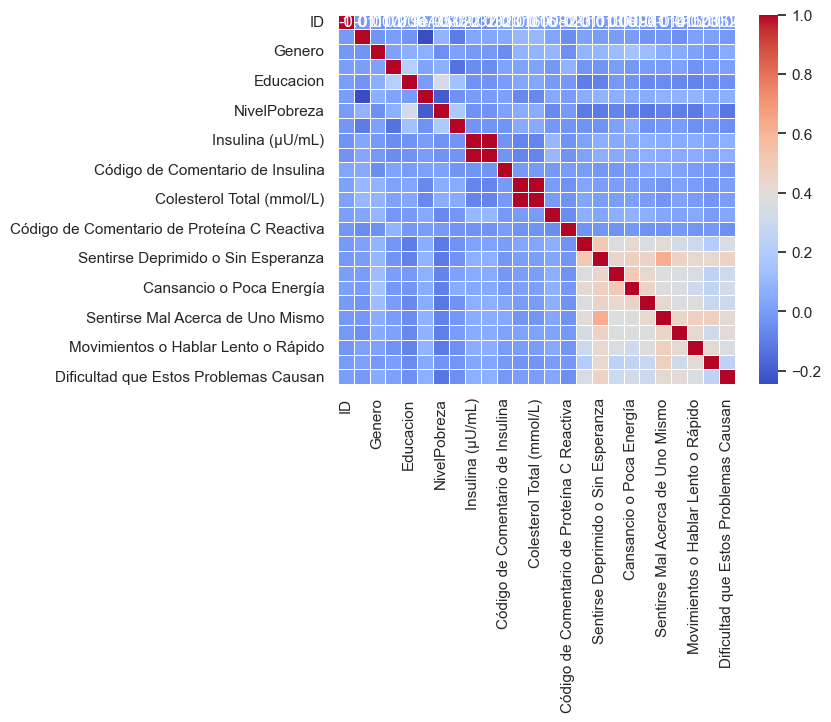

In [132]:
from sklearn.preprocessing import StandardScaler

# Estandarizar las variables
scaler = StandardScaler()
df4_scaled = pd.DataFrame(scaler.fit_transform(df4), columns=df4.columns)

# Recalcular la matriz de correlación
correlation_matrix = df4_scaled.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()



In [133]:
perfilB.head()

ID  Alanina Aminotransferasa (ALT) (U/L)  \
0 109264.00                                  8.00   
1 109266.00                                 15.00   
2 109271.00                                  8.00   
3 109273.00                                 35.00   
4 109274.00                                 19.00   

   Código de comentario de ALT  Albúmina, suero refrigerado (g/dL)  \
0                         0.00                                4.30   
1                         0.00                                3.80   
2                         0.00                                3.80   
3                         0.00                                4.60   
4                         0.00                                4.00   

   Albúmina, suero refrigerado (g/L)  Fosfatasa Alcalina (ALP) (U/L)  \
0                              43.00                          172.00   
1                              38.00                           74.00   
2                              38.00                           88.00   
3                              46.00                           70.00   
4                              40.00                           49.00   

   Aspartato Aminotransferasa (AST) (U/L)  Bicarbonato (mmol/L)  \
0                                   18.00                 26.00   
1                                   14.00                 25.00   
2                                   14.00                 30.00   
3                                   27.00                 27.00   
4                                   20.00                 28.00   

   Nitrógeno Ureico en Sangre (mg/dL)  Nitrógeno Ureico en Sangre (mmol/L)  \
0                                9.00                                 3.21   
1                                8.00                                 2.86   
2                                8.00                                 2.86   
3                               11.00                                 3.93   
4                               11.00                                 3.93   

   ...  Calcio Total (mg/dL)  Calcio Total (mmol/L)  \
0  ...                  9.40                   2.35   
1  ...                  8.80                   2.20   
2  ...                  8.90                   2.23   
3  ...                  9.70                   2.42   
4  ...                  9.10                   2.27   

   Colesterol Total, suero refrigerado (mg/dL)  \
0                                       170.00   
1                                       199.00   
2                                       148.00   
3                                       168.00   
4                                       105.00   

   Colesterol Total, suero refrigerado (mmol/L)  Proteína Total (g/dL)  \
0                                          4.40                   6.90   
1                                          5.15                   6.80   
2                                          3.83                   7.30   
3                                          4.34                   7.40   
4                                          2.71                   6.80   

   Proteína Total (g/L)  Triglicéridos, suero refrigerado (mg/dL)  \
0                 69.00                                     54.00   
1                 68.00                                     86.00   
2                 73.00                                    101.00   
3                 74.00                                    178.00   
4                 68.00                                    151.00   

   Triglicéridos, suero refrigerado (mmol/L)  Ácido Úrico (mg/dL)  \
0                                       0.61                 3.50   
1                                       0.97                 4.90   
2                                       1.14                 5.00   
3                                       2.01                 5.20   
4                                       1.71                 5.10   

   Ácido Úrico (umol/L)  
0                208.20  
1    

In [134]:
perfilB.describe()

ID  Alanina Aminotransferasa (ALT) (U/L)  \
count  10409.00                               9473.00   
mean  117094.51                                 21.27   
std     4500.41                                 18.26   
min   109264.00                                  2.00   
25%   113190.00                                 12.00   
50%   117114.00                                 17.00   
75%   120999.00                                 24.00   
max   124822.00                                682.00   

       Código de comentario de ALT  Albúmina, suero refrigerado (g/dL)  \
count                      9473.00                             9477.00   
mean                          0.00                                4.08   
std                           0.01                                0.35   
min                           0.00                                2.10   
25%                           0.00                                3.90   
50%                           0.00                                4.10   
75%                           0.00                                4.30   
max                           1.00                                5.40   

       Albúmina, suero refrigerado (g/L)  Fosfatasa Alcalina (ALP) (U/L)  \
count                            9477.00                         9474.00   
mean                               40.84                           89.26   
std                                 3.53                           51.38   
min                                21.00                           16.00   
25%                                39.00                           63.00   
50%                                41.00                           77.00   
75%                                43.00                           96.00   
max                                54.00                          638.00   

       Aspartato Aminotransferasa (AST) (U/L)  Bicarbonato (mmol/L)  \
count                                 9435.00               9473.00   
mean                                    21.58                 25.36   
std                                     13.97                  2.41   
min                                      6.00                 14.00   
25%                                     16.00                 24.00   
50%                                     19.00                 25.00   
75%                                     23.00                 27.00   
max                                    489.00                 38.00   

       Nitrógeno Ureico en Sangre (mg/dL)  \
count                             9473.00   
mean                                14.48   
std                                  5.89   
min                                  2.00   
25%                                 11.00   
50%                                 14.00   
75%                                 17.00   
max                                 79.00   

       Nitrógeno Ureico en Sangre (mmol/L)  ...  Calcio Total (mg/dL)  \
count                              9473.00  ...               9473.00   
mean                                  5.17  ...                  9.31   
std                                   2.10  ...                  0.38   
min                                   0.71  ...                  6.40   
25%                                   3.93  ...                  9.10   
50%                                   5.00  ...                  9.30   
75%                                   6.07  ...                  9.50   
max                                  28.20  ...                 12.30   

       Calcio Total (mmol/L)  Colesterol Total, suero refrigerado (mg/dL)  \
count                9473.00                                      9475.00   
mean                    2.33                                       180.75   
std                     0.09                                        41.07   
min                     1.60                                        72.00   
25%                     2.27                              

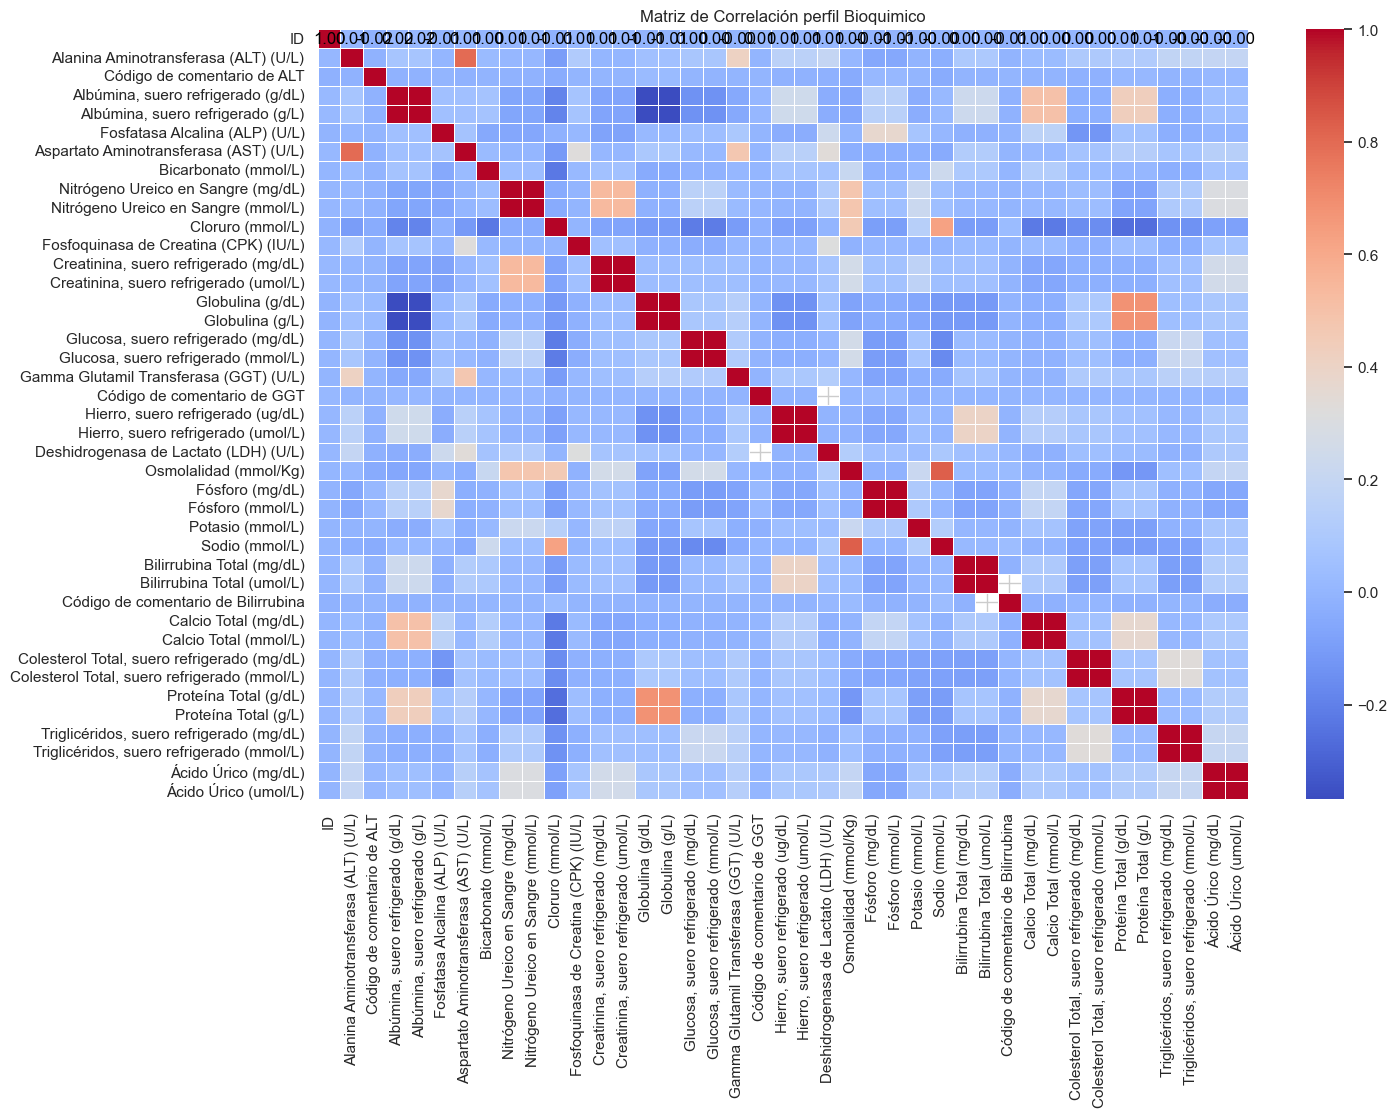

                                                ID  \
ID                                            1.00   
Alanina Aminotransferasa (ALT) (U/L)          0.01   
Código de comentario de ALT                  -0.02   
Albúmina, suero refrigerado (g/dL)            0.02   
Albúmina, suero refrigerado (g/L)             0.02   
Fosfatasa Alcalina (ALP) (U/L)               -0.01   
Aspartato Aminotransferasa (AST) (U/L)        0.01   
Bicarbonato (mmol/L)                          0.00   
Nitrógeno Ureico en Sangre (mg/dL)            0.01   
Nitrógeno Ureico en Sangre (mmol/L)           0.01   
Cloruro (mmol/L)                             -0.01   
Fosfoquinasa de Creatina (CPK) (IU/L)         0.01   
Creatinina, suero refrigerado (mg/dL)         0.01   
Creatinina, suero refrigerado (umol/L)        0.01   
Globulina (g/dL)                             -0.01   
Globulina (g/L)                              -0.01   
Glucosa, suero refrigerado (mg/dL)            0.00   
Glucosa, suero refrigerado (

In [135]:
df_combined_numeric = perfilB.select_dtypes(include=[np.number])
correlation_matrix = correlation_matrix.fillna(0)

# Recalcula la matriz de correlación
correlation_matrix = perfilB.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", annot_kws={"color": "black"})
plt.title('Matriz de Correlación perfil Bioquimico')
plt.show()
print(correlation_matrix)

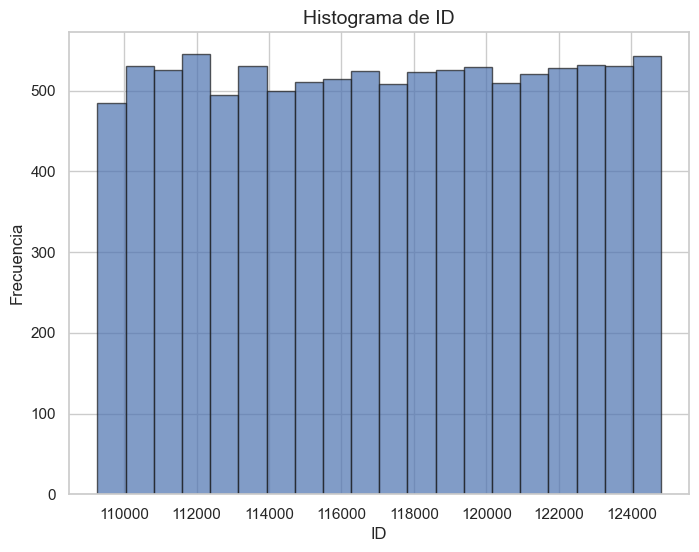

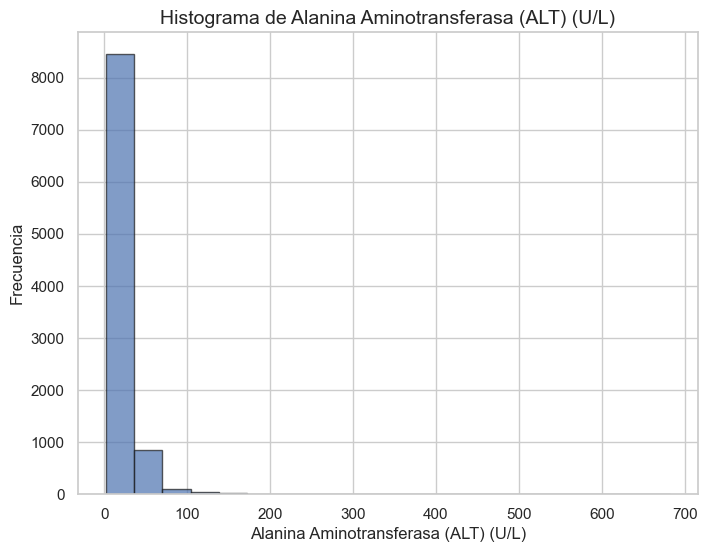

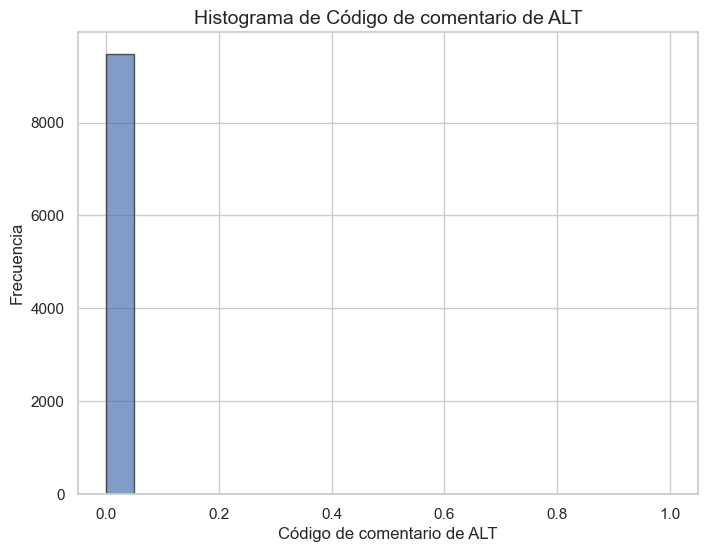

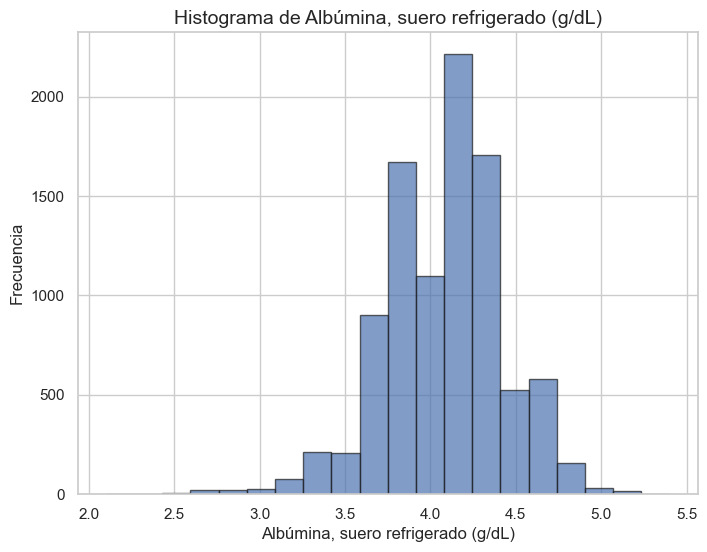

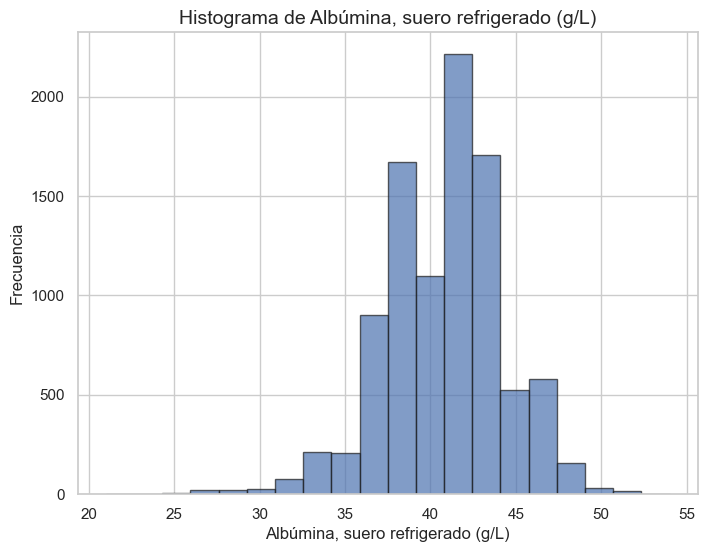

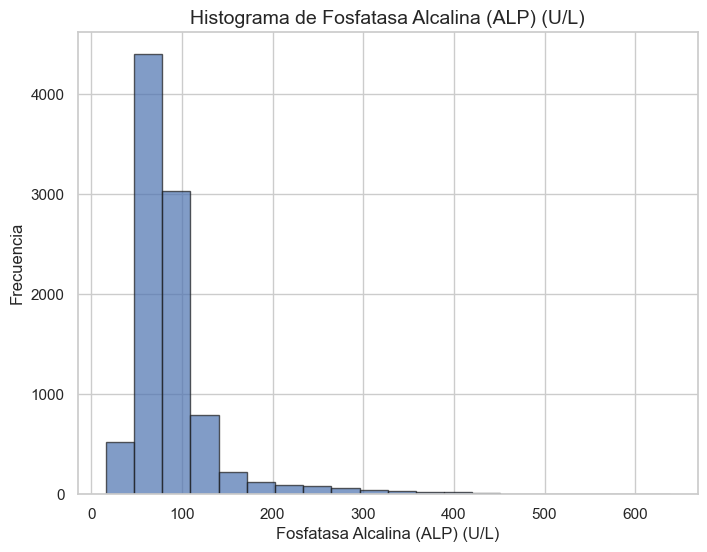

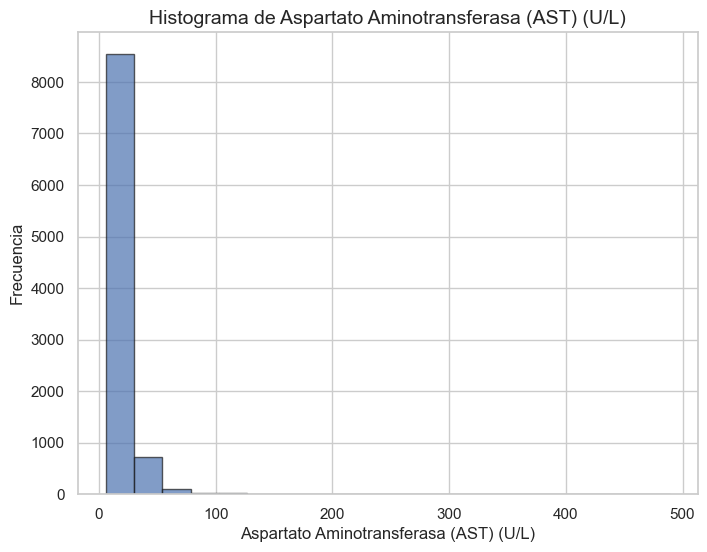

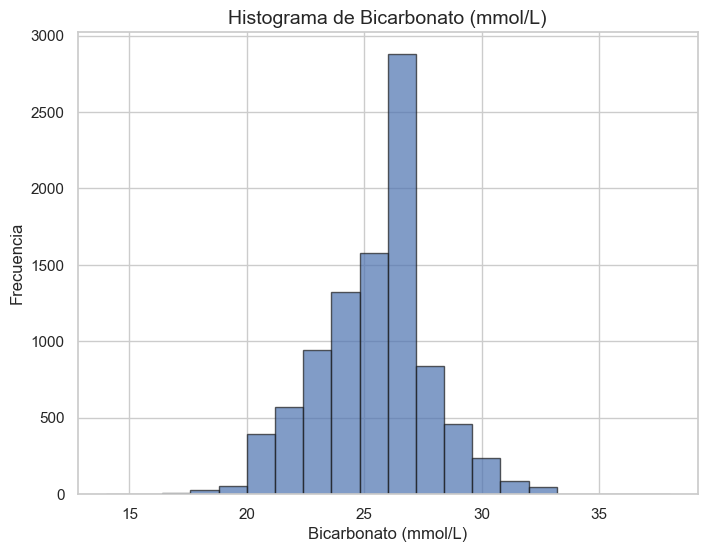

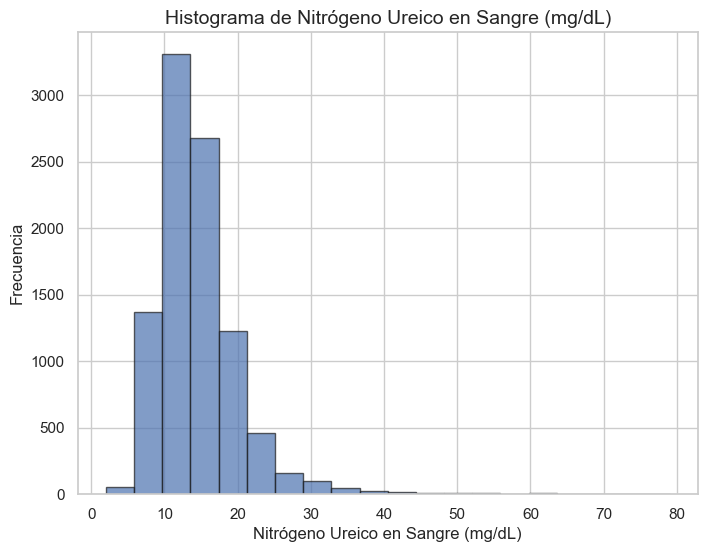

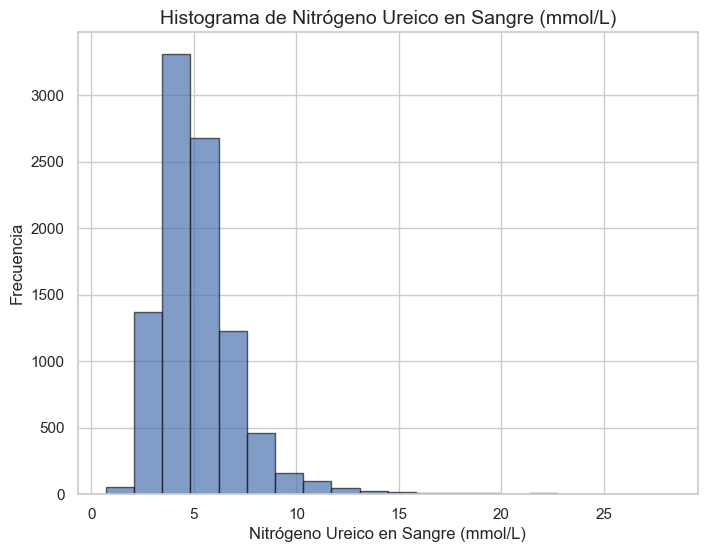

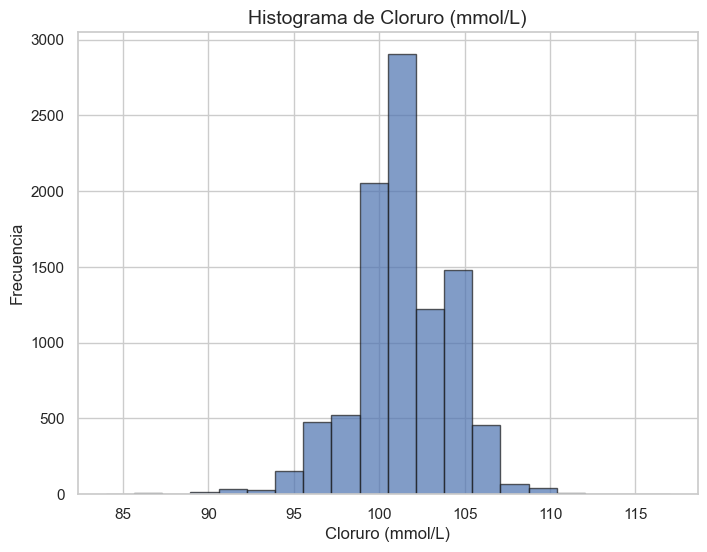

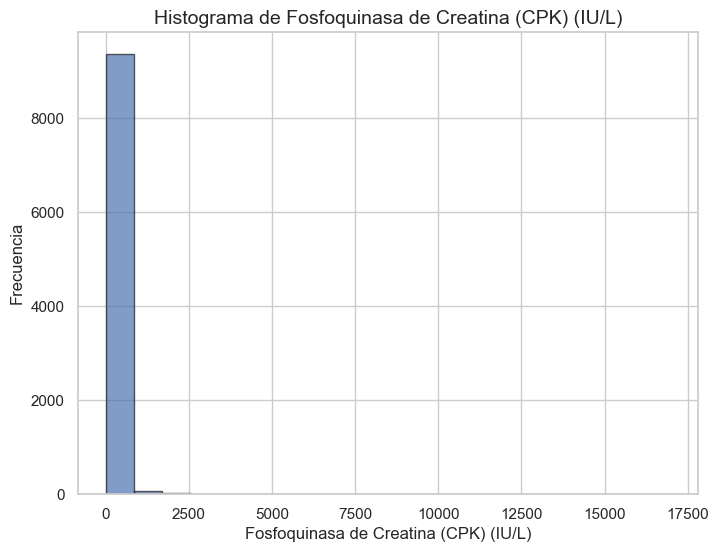

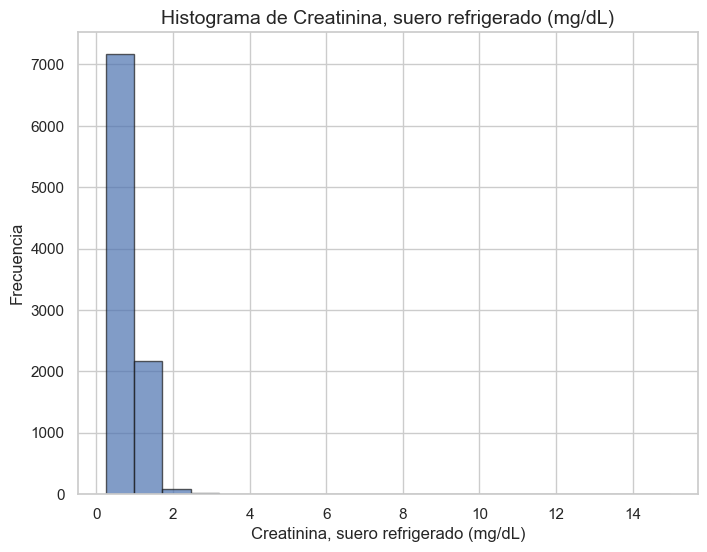

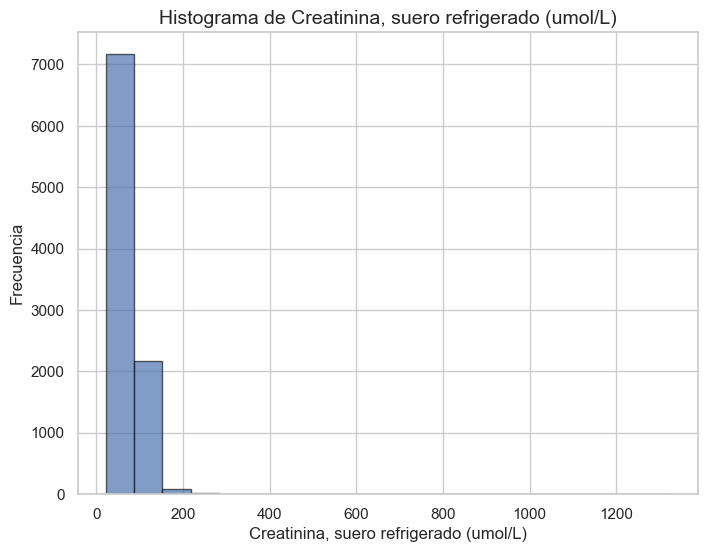

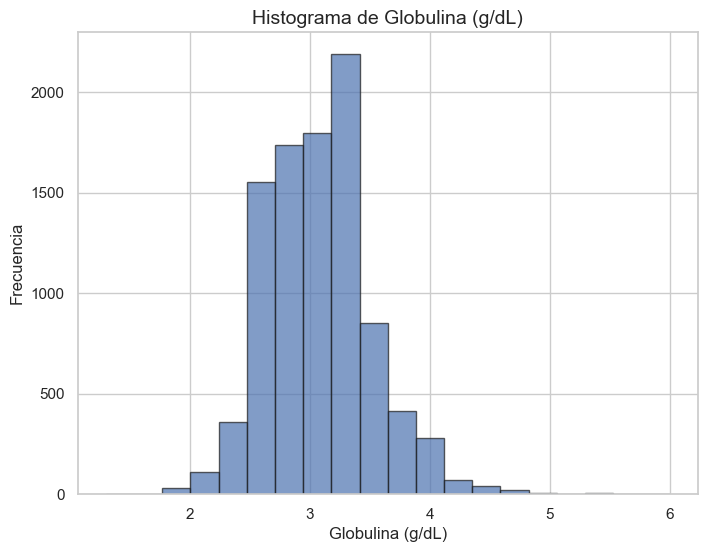

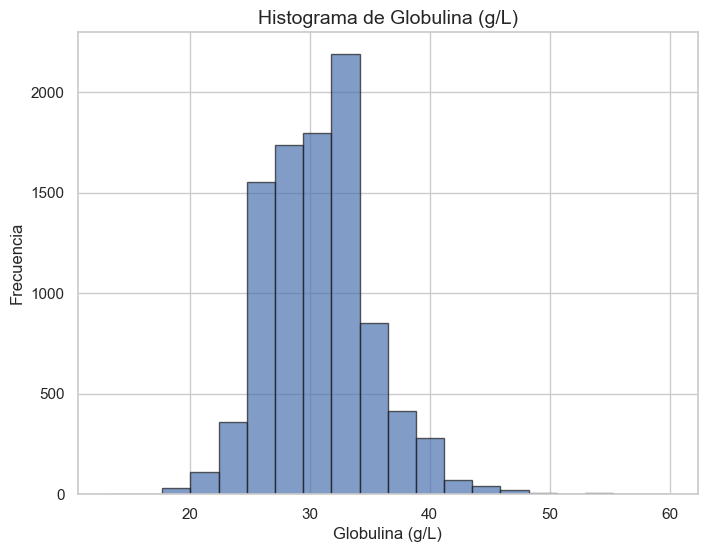

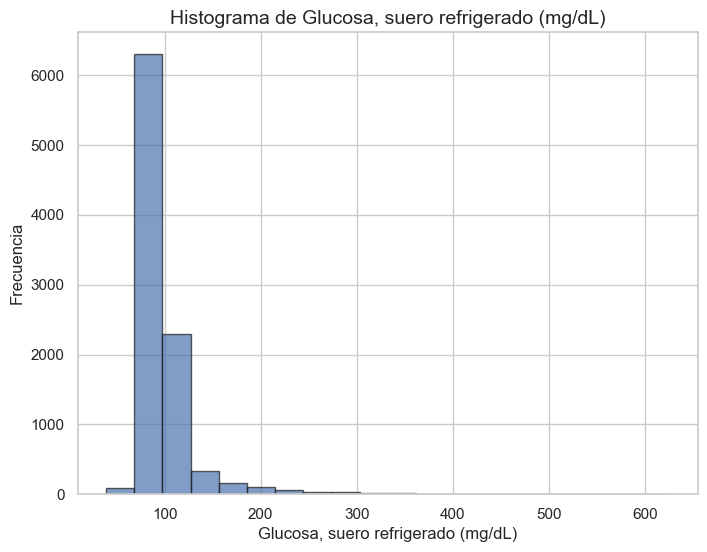

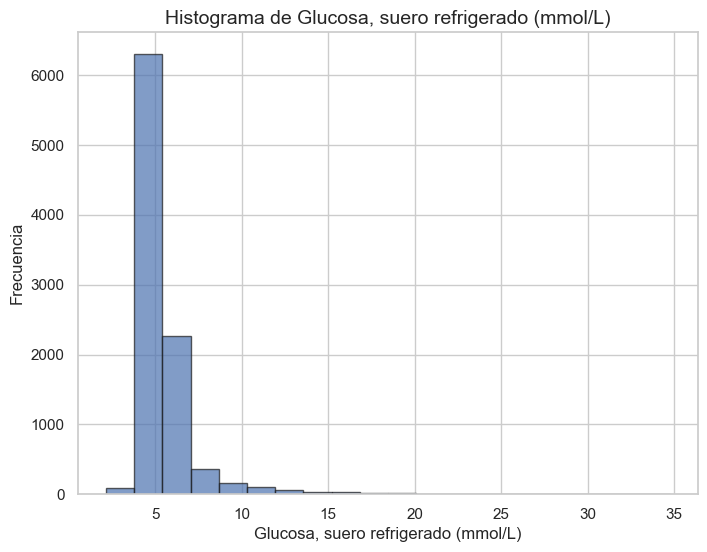

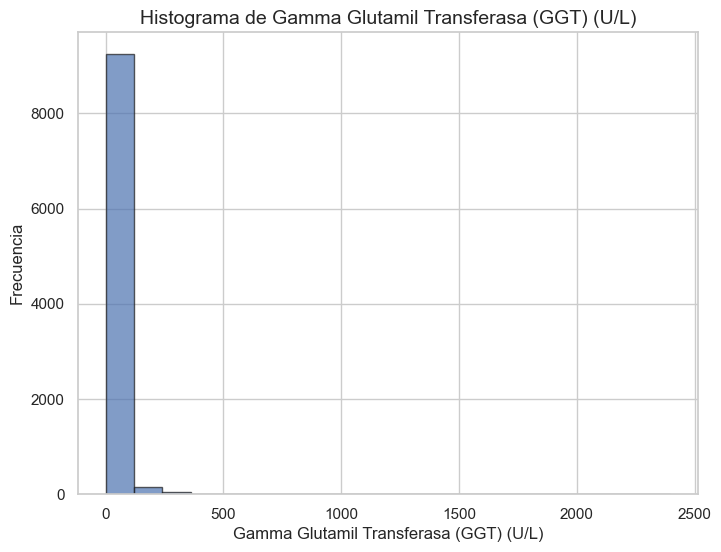

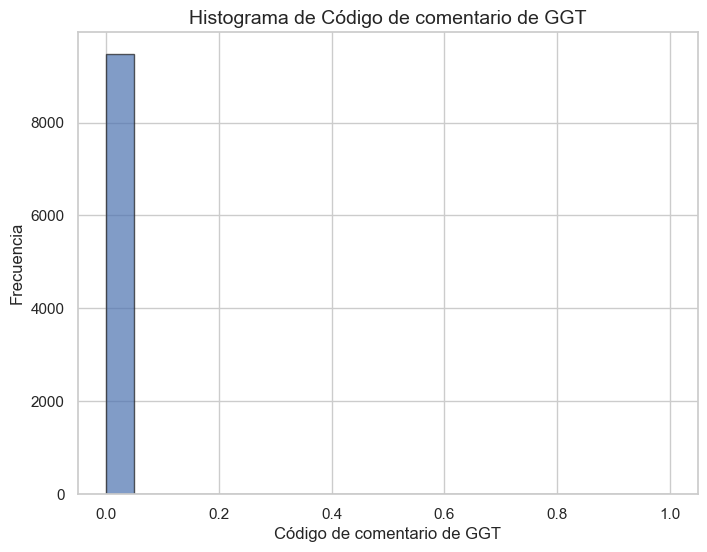

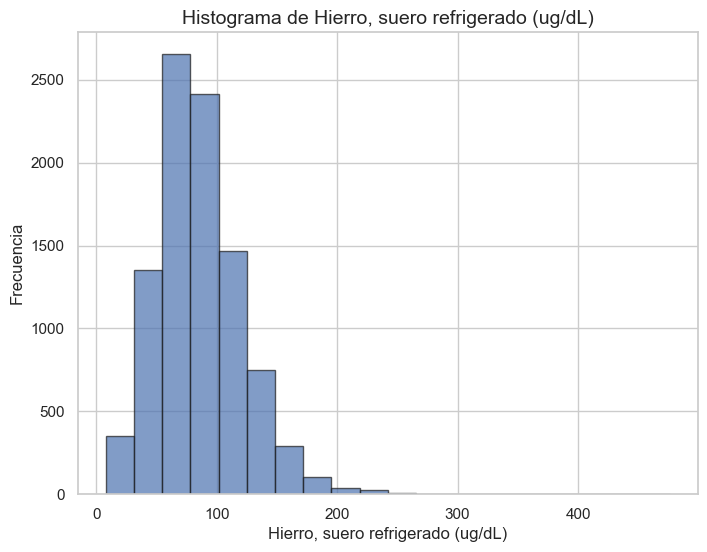

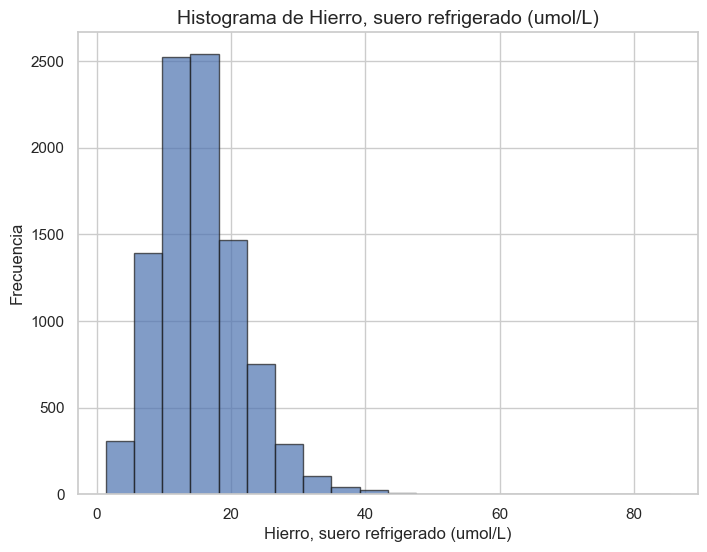

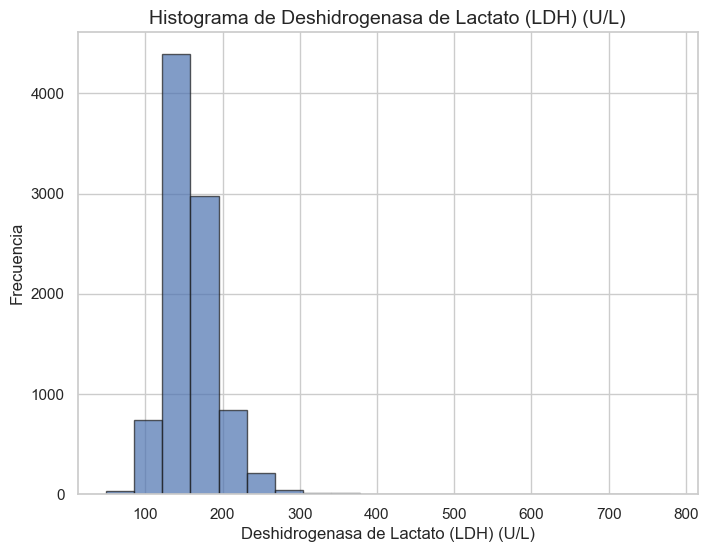

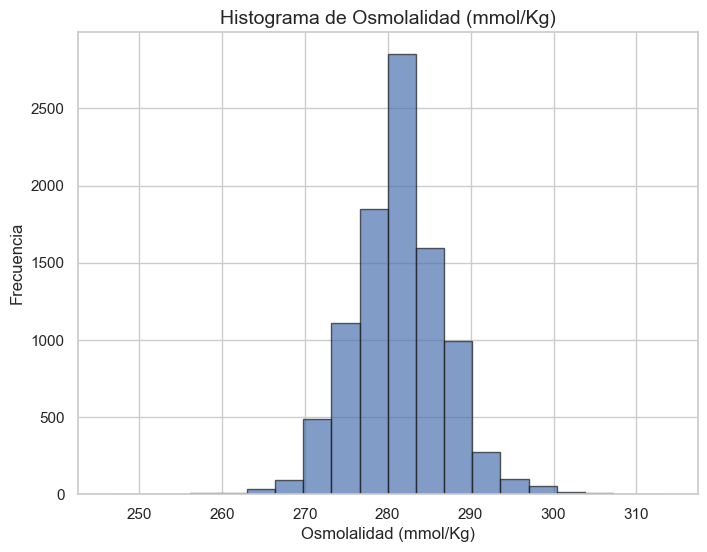

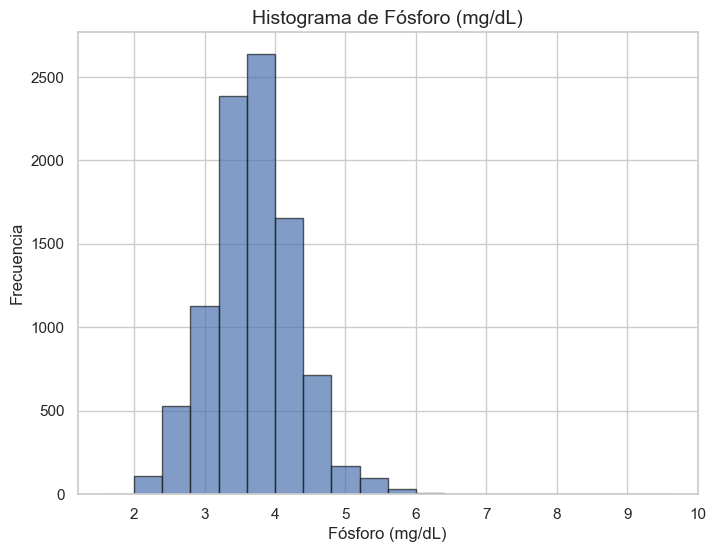

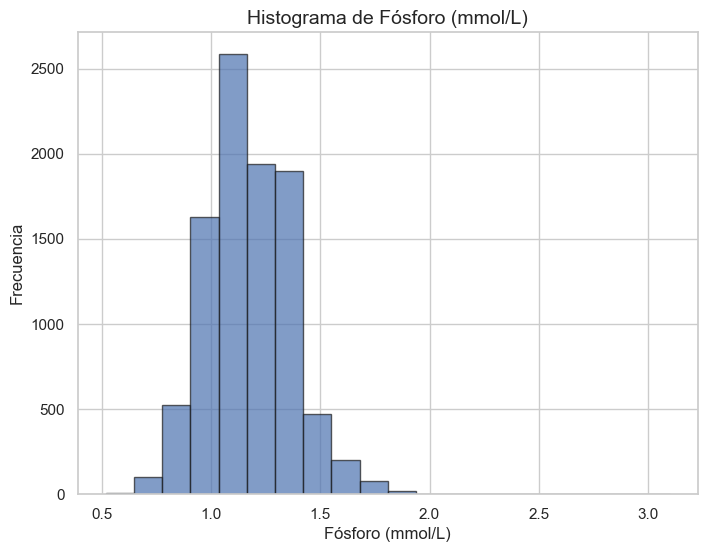

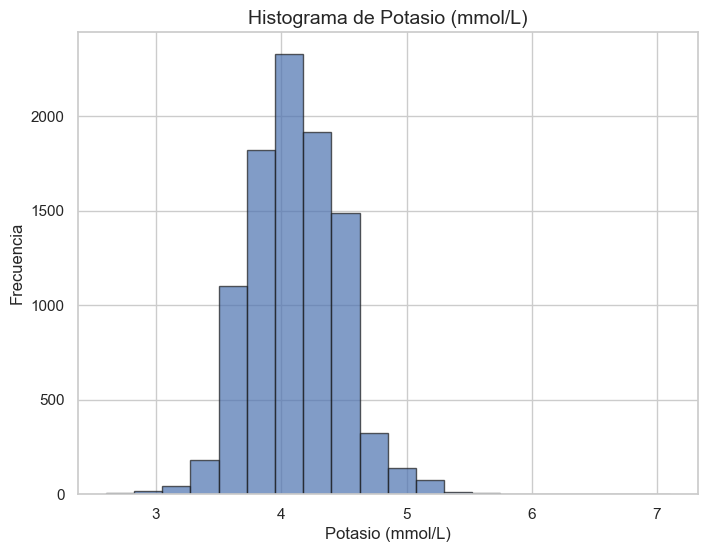

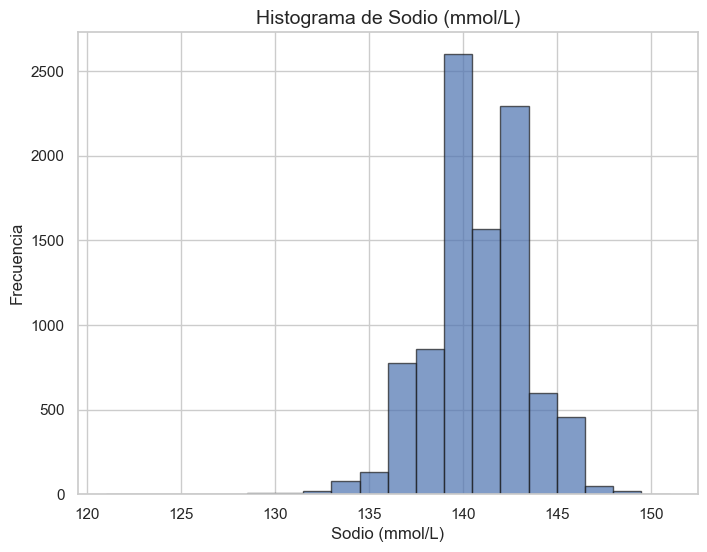

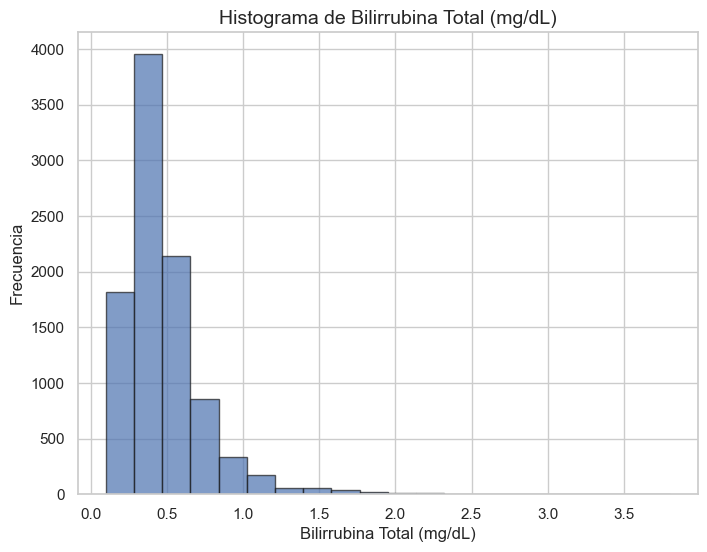

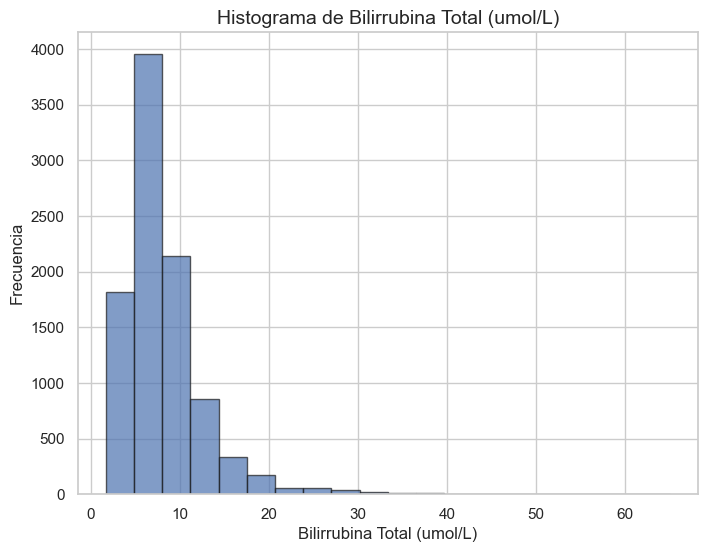

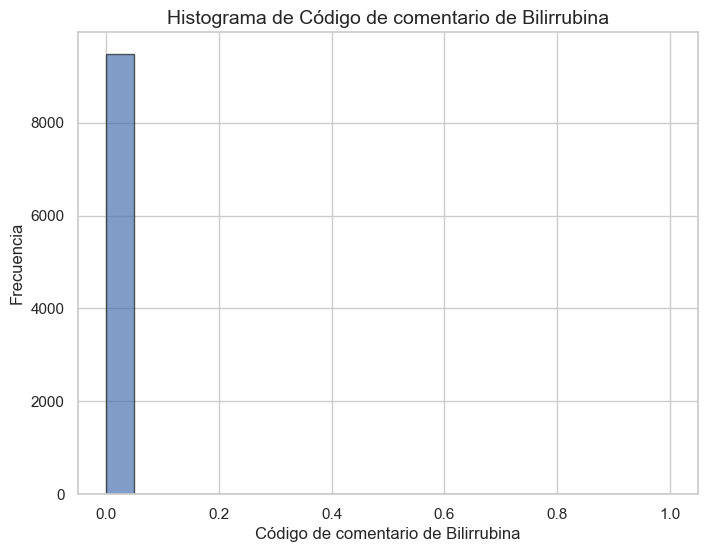

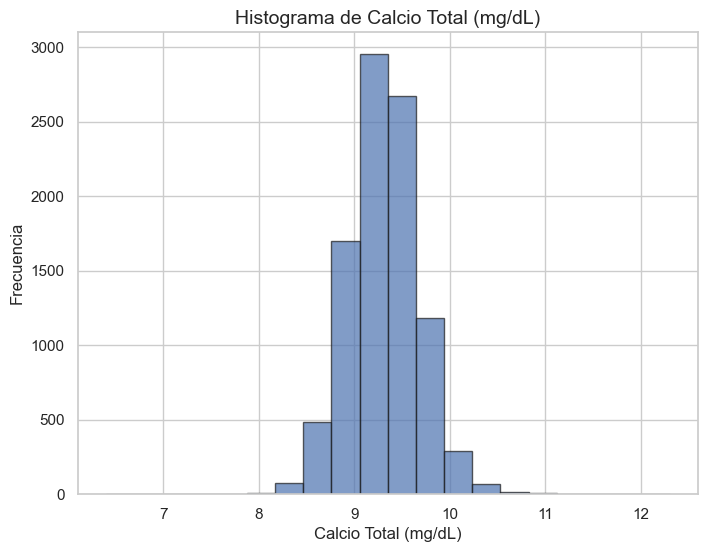

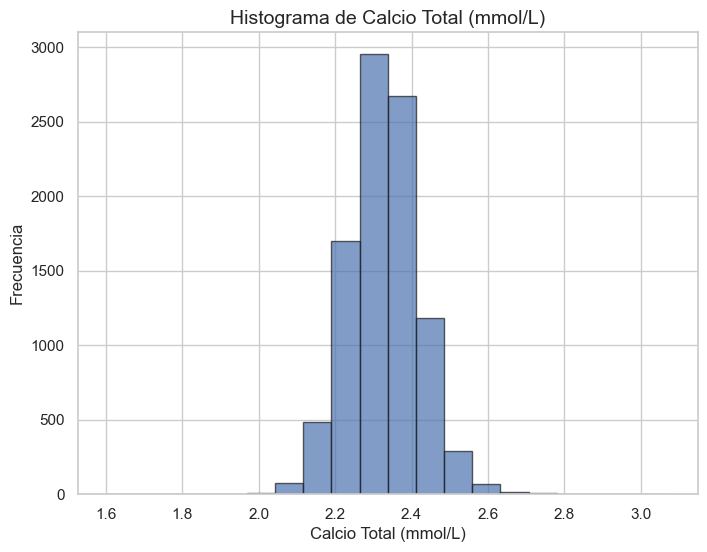

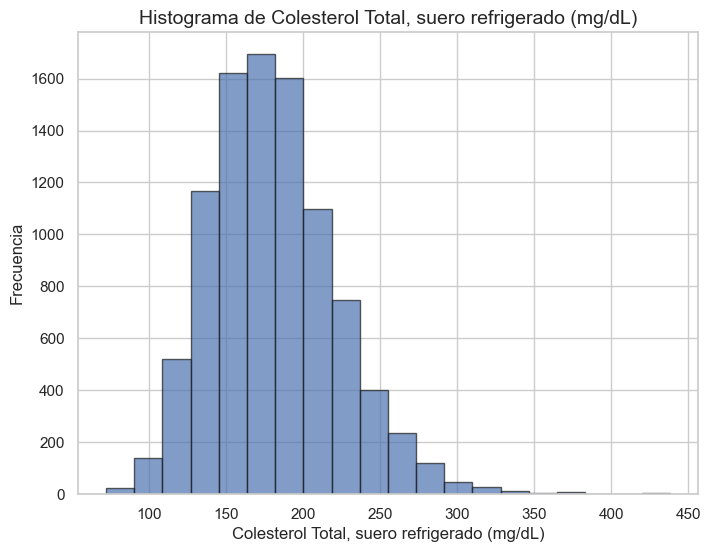

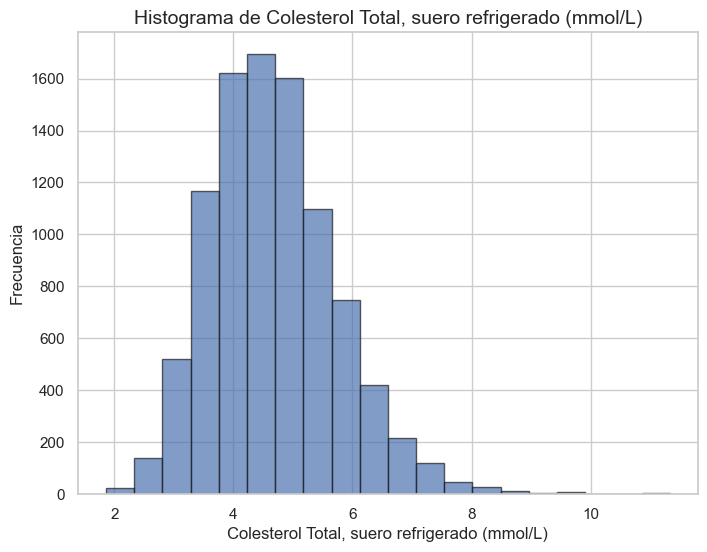

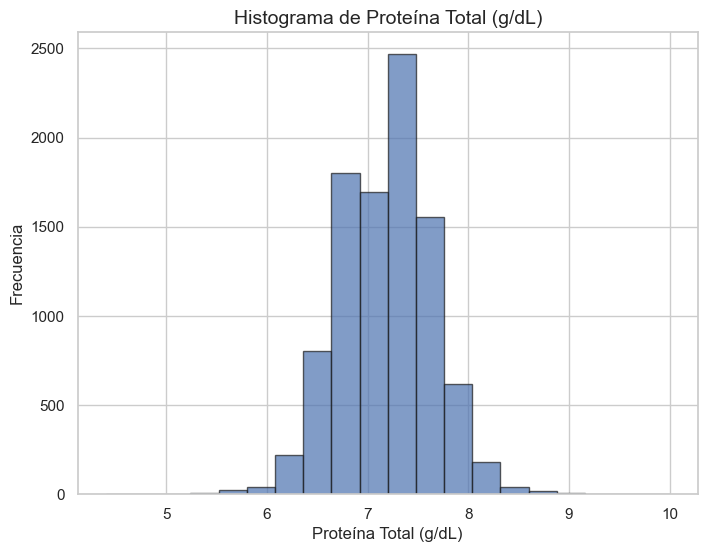

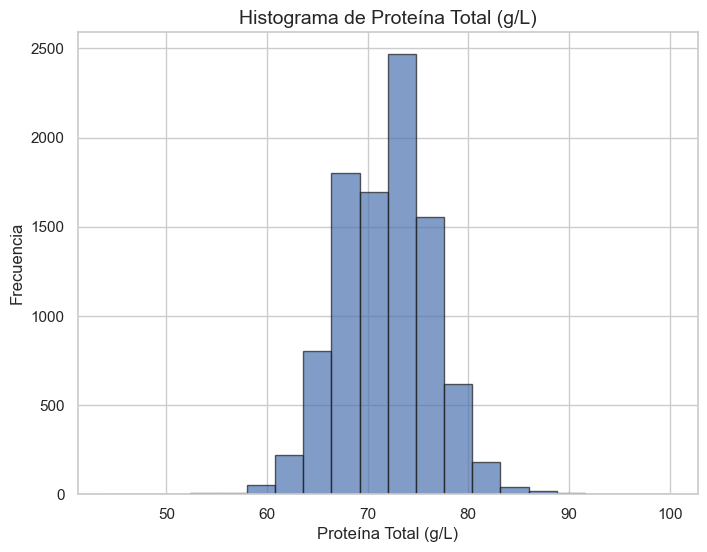

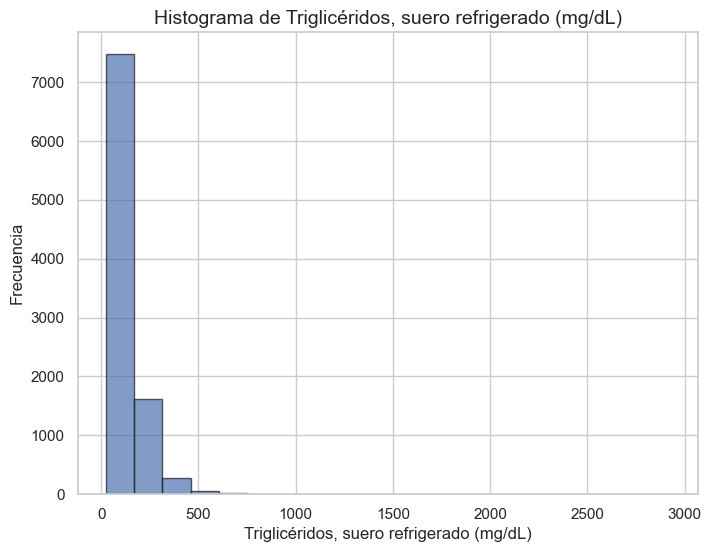

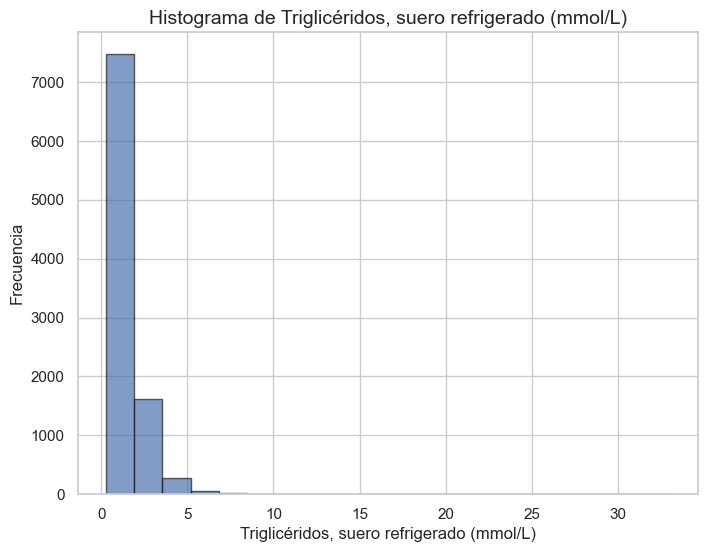

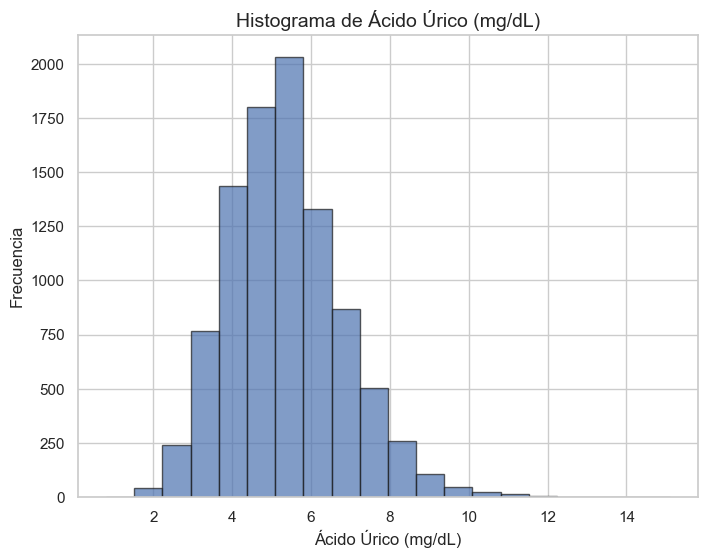

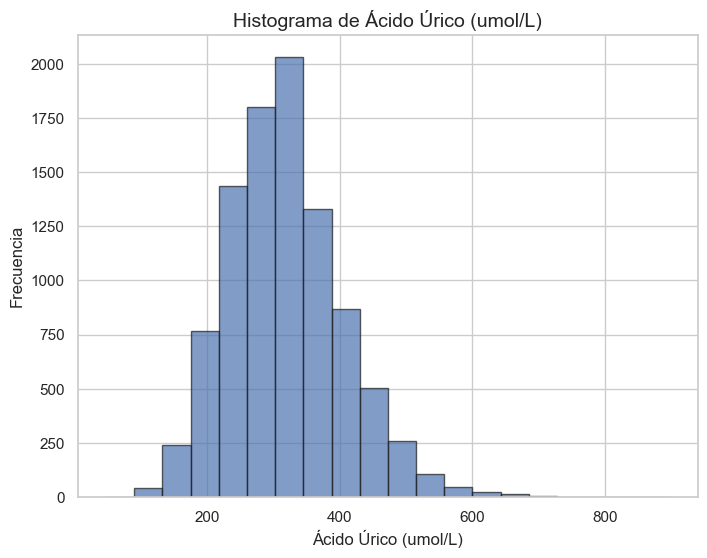

In [136]:
perfilB_numeric = perfilB.select_dtypes(include=[np.number])

for column in perfilB_numeric.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(perfilB_numeric[column].dropna(), bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Histograma de {column}', fontsize=14)
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

# Pruebas: parte 2

In [5]:
demografia.isna().sum()


ID                                                                  0
Ciclo de liberación de datos                                        0
Estado de entrevista/examen                                         0
Género                                                              0
Edad en años al momento del examen                                  0
Edad en meses al momento del examen - 0 a 24 meses              14573
Raza/Origen hispano                                                 0
Raza/Origen hispano con asiáticos no hispanos                       0
Período de seis meses                                            1260
País de nacimiento                                                  0
Tiempo en los EE.UU.                                            12532
Nivel educativo - Adultos 20+                                    6328
Estado civil                                                     6328
Estado de embarazo en el examen                                 13686
Idioma de la entrev


(
    array([1207., 2019., 1942., 1607., 3385.,  856.,  703.,  645.,  515.,
       2681.]),
    array([5.39760535e-79, 5.00000000e-01, 1.00000000e+00, 1.50000000e+00,
       2.00000000e+00, 2.50000000e+00, 3.00000000e+00, 3.50000000e+00,
       4.00000000e+00, 4.50000000e+00, 5.00000000e+00]),
    <BarContainer object of 10 artists>
)

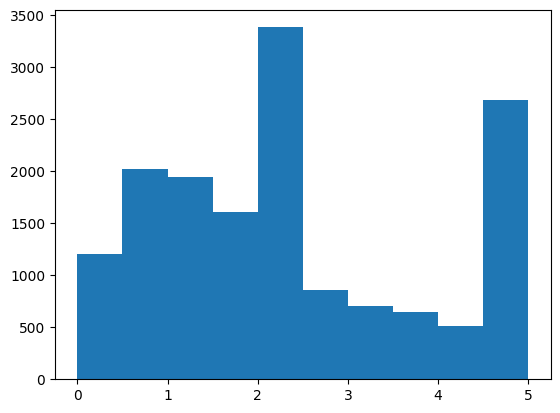

In [7]:
plt.hist(demografia['Relación de ingresos familiares con la pobreza'])

In [26]:
knn_imputer = KNNImputer(n_neighbors=10, weights='uniform')
demografia_imp = pd.DataFrame(knn_imputer.fit_transform(demografia), columns=demografia.columns)


(
    array([1207., 2055., 2152., 2097., 1796., 1373.,  924.,  719.,  549.,
       2688.]),
    array([5.39760535e-79, 5.00000000e-01, 1.00000000e+00, 1.50000000e+00,
       2.00000000e+00, 2.50000000e+00, 3.00000000e+00, 3.50000000e+00,
       4.00000000e+00, 4.50000000e+00, 5.00000000e+00]),
    <BarContainer object of 10 artists>
)

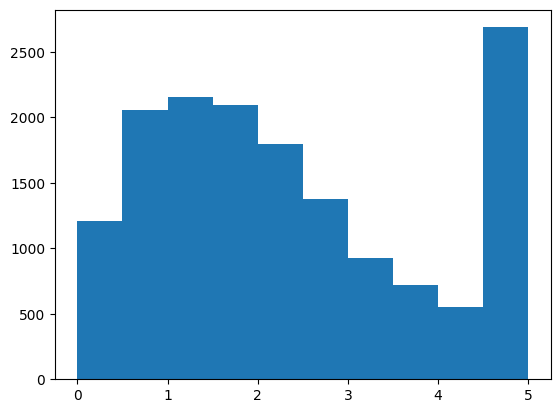

In [52]:
plt.hist(demografia_imp[['Relación de ingresos familiares con la pobreza']])


(
    array([1207., 2055., 2152., 2097., 1796., 1373.,  924.,  719.,  549.,
       2688.]),
    array([5.39760535e-79, 5.00000000e-01, 1.00000000e+00, 1.50000000e+00,
       2.00000000e+00, 2.50000000e+00, 3.00000000e+00, 3.50000000e+00,
       4.00000000e+00, 4.50000000e+00, 5.00000000e+00]),
    <BarContainer object of 10 artists>
)

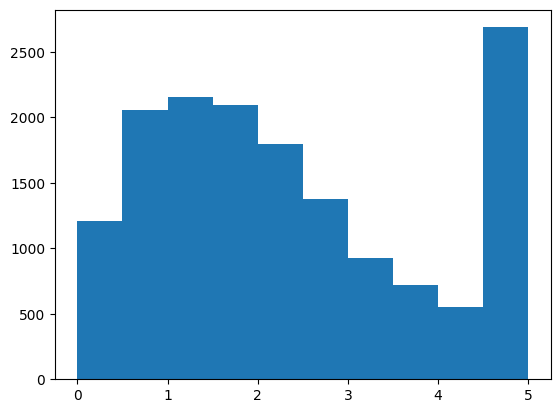

In [61]:
plt.hist(demografia_imp[['Relación de ingresos familiares con la pobreza']])

In [24]:
demografia_imp.isna().sum()


ID                                                              0
Ciclo de liberación de datos                                    0
Estado de entrevista/examen                                     0
Género                                                          0
Edad en años al momento del examen                              0
Edad en meses al momento del examen - 0 a 24 meses              0
Raza/Origen hispano                                             0
Raza/Origen hispano con asiáticos no hispanos                   0
Período de seis meses                                           0
País de nacimiento                                              0
Tiempo en los EE.UU.                                            0
Nivel educativo - Adultos 20+                                   0
Estado civil                                                    0
Estado de embarazo en el examen                                 0
Idioma de la entrevista del participante                        0
¿Se utili

In [152]:
demografia.columns


Index(['ID', 'Ciclo de liberación de datos', 'Estado de entrevista/examen',
       'Género', 'Edad en años al momento del examen',
       'Edad en meses al momento del examen - 0 a 24 meses',
       'Raza/Origen hispano', 'Raza/Origen hispano con asiáticos no hispanos',
       'Período de seis meses', 'País de nacimiento', 'Tiempo en los EE.UU.',
       'Nivel educativo - Adultos 20+', 'Estado civil',
       'Estado de embarazo en el examen',
       'Idioma de la entrevista del participante',
       '¿Se utilizó un apoderado en la entrevista del participante?',
       '¿Se utilizó un intérprete en la entrevista del participante?',
       'Idioma de la entrevista familiar',
       '¿Se utilizó un apoderado en la entrevista familiar?',
       '¿Se utilizó un intérprete en la entrevista familiar?',
       'Idioma de la entrevista MEC',
       '¿Se utilizó un apoderado en la entrevista MEC?',
       '¿Se utilizó un intérprete en la entrevista MEC?',
       'Idioma de la entrevista ACASI',

In [18]:

demografia_imp.loc[demografia_imp['Edad en años al momento del examen']<=5] = 1
demografia_imp.loc[(demografia_imp['Edad en años al momento del examen']>1) & (demografia_imp['Edad en años al momento del examen']<=15)] = 2
demografia_imp.loc[(demografia_imp['Edad en años al momento del examen']>2) & (demografia_imp['Edad en años al momento del examen']<=45)] = 3
demografia_imp.loc[(demografia_imp['Edad en años al momento del examen']>3) & (demografia_imp['Edad en años al momento del examen']<=65)] = 4
demografia_imp.loc[demografia_imp['Edad en años al momento del examen']>5] = 5

demografia_imp['Edad en años al momento del examen']


0       1.00
1       2.00
2       1.00
3       3.00
4       3.00
        ... 
15555   3.00
15556   1.00
15557   2.00
15558   4.00
15559   5.00
Name: Edad en años al momento del examen, Length: 15560, dtype: float64

In [51]:
demo = demografia_imp[['ID']]
demo

ID
0     109263.00
1     109264.00
2     109265.00
3     109266.00
4     109267.00
...         ...
15555 124818.00
15556 124819.00
15557 124820.00
15558 124821.00
15559 124822.00

[15560 rows x 1 columns]

In [43]:
pobreza = demografia_imp[['Relación de ingresos familiares con la pobreza']]
pobreza.loc[pobreza['Relación de ingresos familiares con la pobreza']<=0.8] = 99
pobreza.loc[(pobreza['Relación de ingresos familiares con la pobreza']>0.8) & (pobreza['Relación de ingresos familiares con la pobreza']<=1.5)] = 100
pobreza.loc[(pobreza['Relación de ingresos familiares con la pobreza']>1.5) & (pobreza['Relación de ingresos familiares con la pobreza']<=3)] = 101
pobreza.loc[(pobreza['Relación de ingresos familiares con la pobreza']>3) & (pobreza['Relación de ingresos familiares con la pobreza']<=4.9)] = 102
pobreza.loc[(pobreza['Relación de ingresos familiares con la pobreza']>4.9) & (pobreza['Relación de ingresos familiares con la pobreza']<98)] = 103
pobreza.loc[pobreza['Relación de ingresos familiares con la pobreza']==99] = 1
pobreza.loc[pobreza['Relación de ingresos familiares con la pobreza']==100] = 2
pobreza.loc[pobreza['Relación de ingresos familiares con la pobreza']==101] = 3
pobreza.loc[pobreza['Relación de ingresos familiares con la pobreza']==102] = 4
pobreza.loc[pobreza['Relación de ingresos familiares con la pobreza']==103] = 5

[10/07/24 11:56:41] WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_14384\1153022611.py:2:     ]8;id=434239;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=298313;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               pobreza.loc[pobreza['Relación de ingresos familiares con la                         
                             pobreza']<=0.8] = 99                                                                  
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_14384\1153022611.py:3:     ]8;id=779681;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=528084;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               pobreza.loc[(pobreza['Relación de ingresos familiares con la                        
                             pobreza']>0.8) & (pobreza['Relación de ingresos familiares con la                     
                             pobreza']<=1.5)] = 100                                                                
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_14384\1153022611.py:4:     ]8;id=744418;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=639669;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               pobreza.loc[(pobreza['Relación de ingresos familiares con la                        
                             pobreza']>1.5) & (pobreza['Relación de ingresos familiares con la                     
                             pobreza']<=3)] = 101                                                                  
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_14384\1153022611.py:5:     ]8;id=941672;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=553444;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               pobreza.loc[(pobreza['Relación de ingresos familiares con la                        
                             pobreza']>3) & (pobreza['Relación de ingresos familiares con la                       
                             pobreza']<=4.9)] = 102                                                                
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_14384\1153022611.py:6:     ]8;id=112804;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=682446;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               pobreza.loc[(pobreza['Relación de ingresos familiares con la                        
                             pobreza']>4.9) & (pobreza['Relación de ingresos familiares con la                     
                             pobreza']<98)] = 103                                                                  
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_14384\1153022611.py:7:     ]8;id=610878;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=245514;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               pobreza.loc[pobreza['Relación de ingresos familiares con la                         
                             pobreza']==99] = 1                                                                    
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_14384\1153022611.py:8:     ]8;id=290707;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=474350;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               pobreza.loc[pobreza['Relación de ingresos familiares con la                         
                             pobreza']==100] = 2                                                                   
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_14384\1153022611.py:9:     ]8;id=959461;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=28523;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               pobreza.loc[pobreza['Relación de ingresos familiares con la                         
                             pobreza']==101] = 3                                                                   
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_14384\1153022611.py:10:    ]8;id=426969;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=224960;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               pobreza.loc[pobreza['Relación de ingresos familiares con la                         
                             pobreza']==102] = 4                                                                   
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_14384\1153022611.py:11:    ]8;id=316809;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=574971;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               pobreza.loc[pobreza['Relación de ingresos familiares con la                         
                             pobreza']==103] = 5                                                                   
                                                                                                                   

In [44]:
pobreza.describe()

Relación de ingresos familiares con la pobreza
count                                        15560.00
mean                                             2.95
std                                              1.25
min                                              1.00
25%                                              2.00
50%                                              3.00
75%                                              4.00
max                                              5.00

In [6]:
demografia_imp['Relación de ingresos familiares con la pobreza'].describe()


count   15560.00
mean        3.35
std         0.90
min         2.00
25%         3.00
50%         3.00
75%         4.00
max         5.00
Name: Relación de ingresos familiares con la pobreza, dtype: float64


(
    array([2342.,    0.,    0., 7667.,    0.,    0., 3295.,    0.,    0.,
       2256.]),
    array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
    <BarContainer object of 10 artists>
)

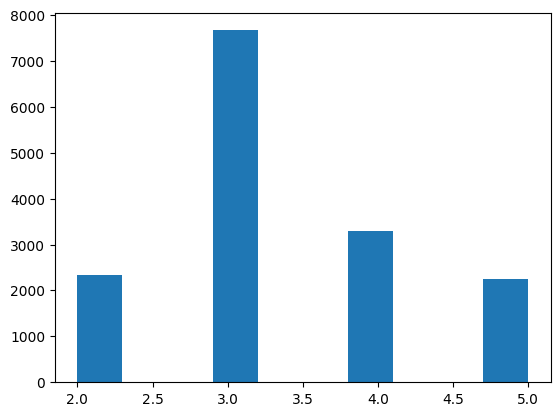

In [7]:
plt.hist(demografia_imp['Relación de ingresos familiares con la pobreza'])

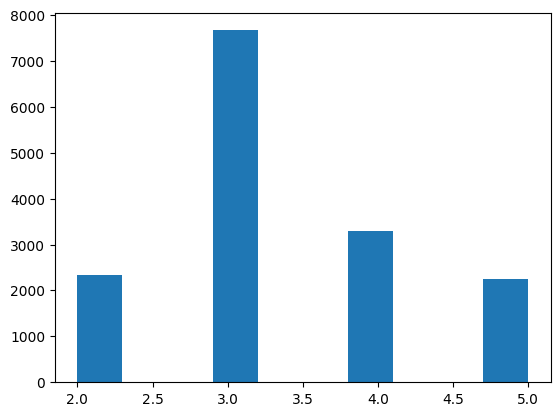

In [8]:
plt.hist(demografia_imp['Edad en años al momento del examen'])
plt.show()

In [142]:
demografia['Edad en años al momento del examen'] = agrupacion

In [143]:
demografia

ID  Ciclo de liberación de datos  Estado de entrevista/examen  \
0     109263.00                         66.00                         2.00   
1     109264.00                         66.00                         2.00   
2     109265.00                         66.00                         2.00   
3     109266.00                         66.00                         2.00   
4     109267.00                         66.00                         1.00   
...         ...                           ...                          ...   
15555 124818.00                         66.00                         2.00   
15556 124819.00                         66.00                         2.00   
15557 124820.00                         66.00                         2.00   
15558 124821.00                         66.00                         2.00   
15559 124822.00                         66.00                         2.00   

       Género  Edad en años al momento del examen  \
0        1.00                                1.00   
1        2.00                                2.00   
2        1.00                                1.00   
3        2.00                                3.00   
4        2.00                                3.00   
...       ...                                 ...   
15555    1.00                                3.00   
15556    1.00                                1.00   
15557    2.00                                2.00   
15558    1.00                                4.00   
15559    1.00                                5.00   

       Edad en meses al momento del examen - 0 a 24 meses  \
0                                                    NaN    
1                                                    NaN    
2                                                    NaN    
3                                                    NaN    
4                                                    NaN    
...                                                  ...    
15555                                                NaN    
15556                                                NaN    
15557                                                NaN    
15558                                                NaN    
15559                                                NaN    

       Raza/Origen hispano  Raza/Origen hispano con asiáticos no hispanos  \
0                     5.00                                           6.00   
1                     1.00                                           1.00   
2                     3.00                                           3.00   
3                     5.00                                           6.00   
4                     2.00                                           2.00   
...                    ...                                            ...   
15555                 4.00                                           4.00   
15556                 4.00                                           4.00   
15557                 3.00                                           3.00   
15558                 4.00                                           4.00   
15559                 2.00                                           2.00   

       Período de seis meses  País de nacimiento  ...  \
0                       2.00                1.00  ...   
1                       2.00                1.00  ...   
2                       2.00                1.00  ...   
3                       2.00                2.00  ...   
4                        NaN                2.00  ...   
...                      ...                 ...  ...   
15555                   1.00                1.00  ...   
15556                   2.00                1.00  ...   
15557                   2.00                1.00  ...   
15558                   1.00                1.00  ...   
15559                   2.00                2.00  ...   

       ¿Se utilizó un intérprete en la entrevista familiar?  \
0                                

In [150]:
insulina_colesterol = pd.DataFrame()
insulina_colesterol['ID'] = demografia['ID'] 
insulina_colesterol['Edad'] = demografia['Edad en años al momento del examen']
insulina_colesterol = pd.merge(insulina_colesterol, insulina, on='ID', how='inner')
insulina_colesterol = pd.merge(insulina_colesterol, colesterol, on='ID', how='inner')
insulina_colesterol = insulina_colesterol.drop('Código de Comentario de Insulina', axis=1)

In [ ]:
correlacion = insulina_colesterol.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

# AER

In [60]:
def demografia_edad(demografia_imp:pd.DataFrame)->pd.DataFrame:
    datos = demografia_imp[['Edad en años al momento del examen']]
    datos.loc[datos['Edad en años al momento del examen']<=5] = 0
    datos.loc[(datos['Edad en años al momento del examen']>0) & (datos['Edad en años al momento del examen']<=15)] = 1
    datos.loc[(datos['Edad en años al momento del examen']>1) & (datos['Edad en años al momento del examen']<=45)] = 2
    datos.loc[(datos['Edad en años al momento del examen']>2) & (datos['Edad en años al momento del examen']<=65)] = 3
    datos.loc[datos['Edad en años al momento del examen']>3] = 4
    return datos

def demografia_pobreza(demografia_imp:pd.DataFrame)->pd.DataFrame:
    datos = demografia_imp[['Relación de ingresos familiares con la pobreza']]
    datos.loc[datos['Relación de ingresos familiares con la pobreza']<=0.8] = 90
    datos.loc[(datos['Relación de ingresos familiares con la pobreza']>0.8) & (datos['Relación de ingresos familiares con la pobreza']<=1.5)] = 91
    datos.loc[(datos['Relación de ingresos familiares con la pobreza']>1.5) & (datos['Relación de ingresos familiares con la pobreza']<=3)] = 92
    datos.loc[(datos['Relación de ingresos familiares con la pobreza']>3) & (datos['Relación de ingresos familiares con la pobreza']<=4.9)] = 93
    datos.loc[(datos['Relación de ingresos familiares con la pobreza']>4.9) & (datos['Relación de ingresos familiares con la pobreza']<80)] = 94
    return datos

def demografia_completa(demografia:pd.DataFrame)->pd.DataFrame:
    knn_imputer = KNNImputer(n_neighbors=10, weights='uniform')
    demografia_imp = pd.DataFrame(knn_imputer.fit_transform(demografia), columns=demografia.columns)
    pobreza = demografia_pobreza(demografia_imp)
    edad = demografia_edad(demografia_imp)
    demon = pd.DataFrame()
    demon['ID'] = demografia[['ID']]
    demon['Nivel Pobreza'] = pobreza
    demon['Edad'] = edad
    return demon

In [61]:
dem = catalog.load("demografia")
#knn_imputer = KNNImputer(n_neighbors=10, weights='uniform')
#demografia_imp = pd.DataFrame(knn_imputer.fit_transform(dem), columns=dem.columns)

[10/08/24 12:24:44] INFO     Loading data from demografia (ParquetDataset)...                   ]8;id=187612;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=252450;file://C:\Users\crist\OneDrive\Desktop\kedro-main\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

In [10]:
dem['ID']


0        109263.0
1        109264.0
2        109265.0
3        109266.0
4        109267.0
           ...   
15555    124818.0
15556    124819.0
15557    124820.0
15558    124821.0
15559    124822.0
Name: ID, Length: 15560, dtype: float64

In [54]:
pobreza = demografia_pobreza(dem)
pobreza_imp = demografia_pobreza(demografia_imp)
pobreza.describe()


Relación de ingresos familiares con la pobreza
count                                    13359.000000
mean                                        91.936223
std                                          1.328104
min                                         90.000000
25%                                         91.000000
50%                                         92.000000
75%                                         93.000000
max                                         94.000000

In [55]:
pobreza_imp.describe()

Relación de ingresos familiares con la pobreza
count                                    15560.000000
mean                                        91.950450
std                                          1.246804
min                                         90.000000
25%                                         91.000000
50%                                         92.000000
75%                                         93.000000
max                                         94.000000

In [62]:
demodemo = demografia_completa(dem)
demodemo.describe()

[10/08/24 12:25:34] WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_15576\1945758582.py:12:    ]8;id=188249;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=644538;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               datos.loc[datos['Relación de ingresos familiares con la                             
                             pobreza']<=0.8] = 90                                                                  
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_15576\1945758582.py:13:    ]8;id=867756;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=568526;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               datos.loc[(datos['Relación de ingresos familiares con la                            
                             pobreza']>0.8) & (datos['Relación de ingresos familiares con la                       
                             pobreza']<=1.5)] = 91                                                                 
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_15576\1945758582.py:14:    ]8;id=348660;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=638336;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               datos.loc[(datos['Relación de ingresos familiares con la                            
                             pobreza']>1.5) & (datos['Relación de ingresos familiares con la                       
                             pobreza']<=3)] = 92                                                                   
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_15576\1945758582.py:15:    ]8;id=571554;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=720690;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               datos.loc[(datos['Relación de ingresos familiares con la                            
                             pobreza']>3) & (datos['Relación de ingresos familiares con la                         
                             pobreza']<=4.9)] = 93                                                                 
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_15576\1945758582.py:16:    ]8;id=85485;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=871028;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               datos.loc[(datos['Relación de ingresos familiares con la                            
                             pobreza']>4.9) & (datos['Relación de ingresos familiares con la                       
                             pobreza']<80)] = 94                                                                   
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_15576\1945758582.py:3:     ]8;id=771303;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=536568;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               datos.loc[datos['Edad en años al momento del examen']<=5] = 0                       
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_15576\1945758582.py:4:     ]8;id=326767;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=556487;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               datos.loc[(datos['Edad en años al momento del examen']>0) &                         
                             (datos['Edad en años al momento del examen']<=15)] = 1                                
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_15576\1945758582.py:5:     ]8;id=585689;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=913810;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               datos.loc[(datos['Edad en años al momento del examen']>1) &                         
                             (datos['Edad en años al momento del examen']<=45)] = 2                                
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_15576\1945758582.py:6:     ]8;id=432783;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=910852;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               datos.loc[(datos['Edad en años al momento del examen']>2) &                         
                             (datos['Edad en años al momento del examen']<=65)] = 3                                
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_15576\1945758582.py:7:     ]8;id=34517;file://C:\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=201576;file://C:\Python312\Lib\warnings.py#110\110]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               datos.loc[datos['Edad en años al momento del examen']>3] = 4                        
                                                                                                                   

ID  Nivel Pobreza          Edad
count   15560.00000   15560.000000  15560.000000
mean   117042.50000      91.950450      2.006427
std      4491.92943       1.246804      1.260201
min    109263.00000      90.000000      0.000000
25%    113152.75000      91.000000      1.000000
50%    117042.50000      92.000000      2.000000
75%    120932.25000      93.000000      3.000000
max    124822.00000      94.000000      4.000000

In [43]:
demodemo[demodemo['Nivel Pobreza']==3]

ID    Edad  Nivel Pobreza
count    2256.000000  2256.0         2256.0
mean   117012.004876     4.0            3.0
std      4401.536578     0.0            0.0
min    109274.000000     4.0            3.0
25%    113309.500000     4.0            3.0
50%    116975.500000     4.0            3.0
75%    120744.000000     4.0            3.0
max    124822.000000     4.0            3.0


(
    array([2342.,    0.,    0., 3023.,    0.,    0., 7939.,    0.,    0.,
       2256.]),
    array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
    <BarContainer object of 10 artists>
)

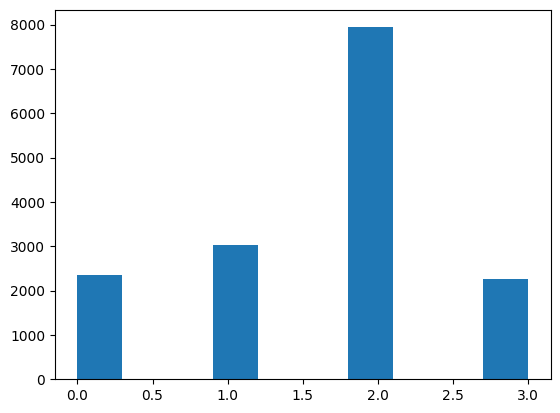

In [44]:
plt.hist(demodemo['Nivel Pobreza'])

# Finalmente

In [2]:
clean = catalog.load("demografia_clean")
clean

[10/13/24 16:22:19] INFO     Loading data from demografia_clean (ParquetDataset)...             ]8;id=963869;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=212565;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

ID  Nivel Pobreza  Edad  Sexo
0      109263.0            3.0   0.0   1.0
1      109264.0            1.0   1.0   2.0
2      109265.0            3.0   0.0   1.0
3      109266.0            4.0   2.0   2.0
4      109267.0            4.0   2.0   2.0
...         ...            ...   ...   ...
15555  124818.0            3.0   2.0   1.0
15556  124819.0            0.0   0.0   1.0
15557  124820.0            1.0   1.0   2.0
15558  124821.0            3.0   3.0   1.0
15559  124822.0            2.0   4.0   1.0

[15560 rows x 4 columns]

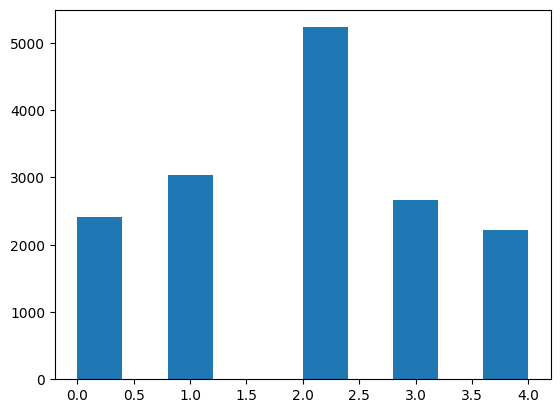

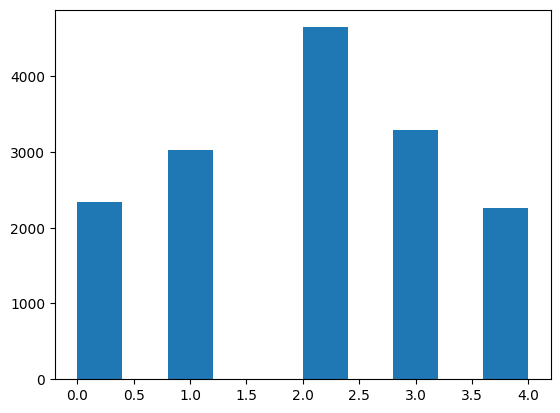

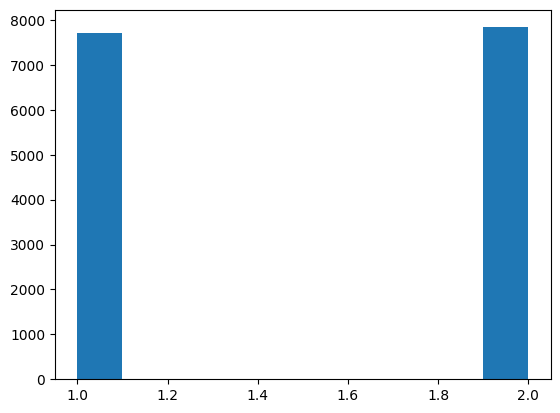

In [3]:
for columna in clean.columns[1:]:
    plt.hist(clean[columna])
    plt.show()

In [21]:
consideracion_insulina.describe()

ID  Nivel Pobreza    Edad    Sexo  Peso de Submuestra en Ayunas  \
count   5090.00        5090.00 5090.00 5090.00                       5090.00   
mean  117177.33           2.02    2.62    1.52                      53883.96   
std     4487.34           1.22    0.90    0.50                      68538.13   
min   109264.00           0.00    1.00    1.00                          0.00   
25%   113303.50           1.00    2.00    1.00                      17305.97   
50%   117265.50           2.00    3.00    2.00                      32845.10   
75%   121046.50           3.00    3.00    2.00                      62135.88   
max   124822.00           4.00    4.00    2.00                     741259.19   

       Insulina (μU/mL)  Insulina (pmol/L)  Código de Comentario de Insulina  
count           4625.00            4625.00                           4625.00  
mean              14.98              89.85                              0.00  
std               22.85             137.07                              0.04  
min                0.71               4.26                              0.00  
25%                6.31              37.86                              0.00  
50%               10.18              61.08                              0.00  
75%               16.61              99.66                              0.00  
max              512.50            3075.00                              1.00

In [29]:
scaler = StandardScaler()
pt = PowerTransformer(method='yeo-johnson')
consideracion_insulina = pd.merge(clean, insulina, on='ID', how='inner')
insulina_muestra = pd.DataFrame()
insulina_muestra['ID'] = consideracion_insulina['ID']
insulina_muestra['Edad'] = consideracion_insulina['Edad']
insulina_muestra['Sexo'] = consideracion_insulina['Sexo']
insulina_muestra['Nivel Pobreza'] = consideracion_insulina['Nivel Pobreza']
insulina_muestra['Nivel Insulina'] = consideracion_insulina['Insulina (μU/mL)']
knn_imputer = KNNImputer(n_neighbors=10, weights='uniform')
insulina_imp = pd.DataFrame(knn_imputer.fit_transform(insulina_muestra), columns=insulina_muestra.columns)
Q1 = insulina_imp["Nivel Insulina"].quantile(0.25)
Q3 = insulina_imp["Nivel Insulina"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
limpio = insulina_imp[~((insulina_imp["Nivel Insulina"] < lower_bound) | (insulina_imp["Nivel Insulina"] > upper_bound))]
limpio["Nivel Insulina"] = scaler.fit_transform(limpio[["Nivel Insulina"]])
limpio["Nivel Insulina"] = pt.fit_transform(limpio[["Nivel Insulina"]])
limpio.describe()

[10/12/24 18:59:30] WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_21744\368700874.py:18:     ]8;id=853816;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=716278;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               limpio["Nivel Insulina"] = scaler.fit_transform(limpio[["Nivel                      
                             Insulina"]])                                                                          
                                                                                                                   

                    WARNING  C:\Users\crist\AppData\Local\Temp\ipykernel_21744\368700874.py:19:     ]8;id=558855;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=989298;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               limpio["Nivel Insulina"] = pt.fit_transform(limpio[["Nivel                          
                             Insulina"]])                                                                          
                                                                                                                   

ID    Edad    Sexo  Nivel Pobreza  Nivel Insulina
count   4750.00 4750.00 4750.00        4750.00         4750.00
mean  117196.21    2.62    1.52           2.04           -0.00
std     4482.41    0.90    0.50           1.22            1.00
min   109264.00    1.00    1.00           0.00           -2.33
25%   113348.50    2.00    1.00           1.00           -0.79
50%   117288.50    3.00    2.00           2.00            0.01
75%   121059.25    3.00    2.00           3.00            0.73
max   124822.00    4.00    2.00           4.00            2.19

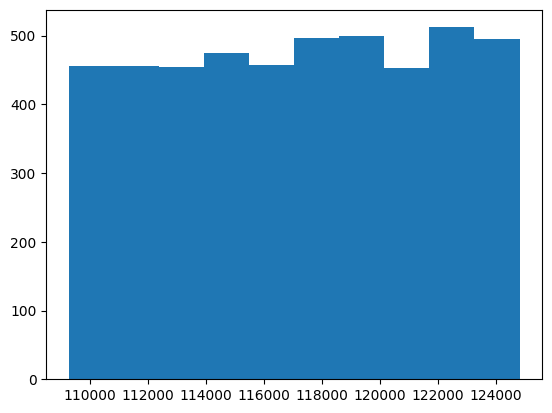

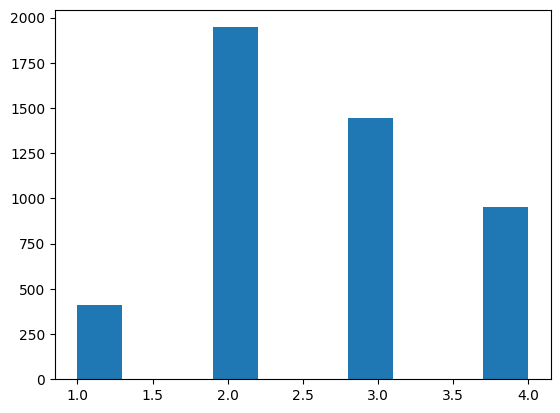

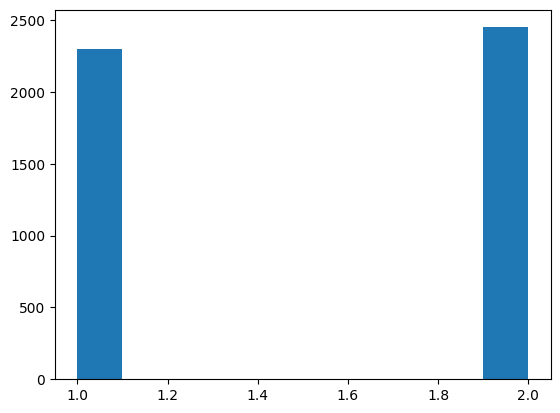

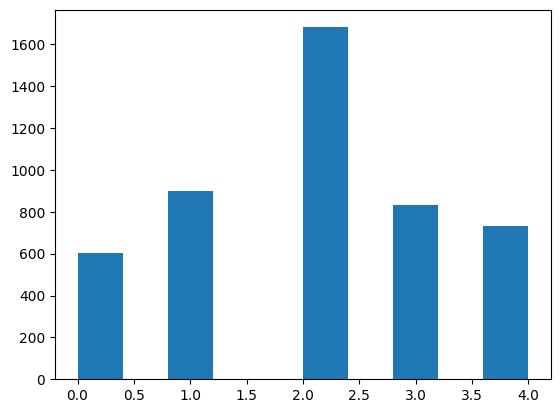

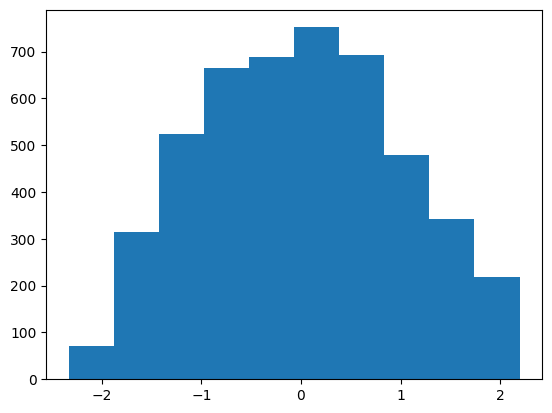

In [30]:
for columna in limpio.columns:
    plt.hist(limpio[columna])
    plt.show()

In [27]:
insulina_imp.describe()

ID    Edad    Sexo  Nivel Pobreza  Nivel Insulina
count   5090.00 5090.00 5090.00        5090.00         5090.00
mean  117177.33    2.62    1.52           2.02           14.98
std     4487.34    0.90    0.50           1.22           21.89
min   109264.00    1.00    1.00           0.00            0.71
25%   113303.50    2.00    1.00           1.00            6.61
50%   117265.50    3.00    2.00           2.00           10.70
75%   121046.50    3.00    2.00           3.00           16.55
max   124822.00    4.00    2.00           4.00          512.50

In [16]:
knn_imputer = KNNImputer(n_neighbors=10, weights='uniform')
insulina_imp = pd.DataFrame(knn_imputer.fit_transform(limpio), columns=limpio.columns)

In [18]:
insulina_imp.describe()

ID  Nivel Pobreza   Edad   Sexo  Peso de Submuestra en Ayunas  \
count    310.00         310.00 310.00 310.00                        310.00   
mean  116908.05           1.84   2.61   1.51                      44972.81   
std     4538.03           1.15   0.86   0.50                      50122.41   
min   109340.00           0.00   1.00   1.00                          0.00   
25%   112853.75           1.00   2.00   1.00                      14298.39   
50%   116690.00           2.00   3.00   2.00                      30052.07   
75%   120934.50           2.00   3.00   2.00                      61118.40   
max   124616.00           4.00   4.00   2.00                     394175.28   

       Insulina (μU/mL)  Insulina (pmol/L)  Código de Comentario de Insulina  
count            310.00             310.00                            310.00  
mean              67.23             403.38                              0.00  
std               65.11             390.68                              0.00  
min               32.13             192.78                              0.00  
25%               37.63             225.78                              0.00  
50%               44.89             269.37                              0.00  
75%               66.60             399.59                              0.00  
max              512.50            3075.00                              0.00

In [ ]:
escalado = scaler.fit_transform(insulina_imp[["Insulina (μU/mL)"]])
escalado["Insulina (μU/mL)"] = pt.fit_transform(escalado[["Insulina (μU/mL)"]])
insulina = pd.DataFrame()
insulina['ID'] = escalado['ID']
insulina['Nivel Pobreza'] = escalado['Nivel Pobreza']
insulina['Edad'] = escalado['Edad']
insulina['Sexo'] = escalado['Sexo']
insulina['NivelInsulina'] = escalado['Insulina (μU/mL)']
insulina

# Perfil Bioquímico

In [32]:
perfilB.columns


Index(['ID', 'Alanina Aminotransferasa (ALT) (U/L)',
       'Código de comentario de ALT', 'Albúmina, suero refrigerado (g/dL)',
       'Albúmina, suero refrigerado (g/L)', 'Fosfatasa Alcalina (ALP) (U/L)',
       'Aspartato Aminotransferasa (AST) (U/L)', 'Bicarbonato (mmol/L)',
       'Nitrógeno Ureico en Sangre (mg/dL)',
       'Nitrógeno Ureico en Sangre (mmol/L)', 'Cloruro (mmol/L)',
       'Fosfoquinasa de Creatina (CPK) (IU/L)',
       'Creatinina, suero refrigerado (mg/dL)',
       'Creatinina, suero refrigerado (umol/L)', 'Globulina (g/dL)',
       'Globulina (g/L)', 'Glucosa, suero refrigerado (mg/dL)',
       'Glucosa, suero refrigerado (mmol/L)',
       'Gamma Glutamil Transferasa (GGT) (U/L)', 'Código de comentario de GGT',
       'Hierro, suero refrigerado (ug/dL)',
       'Hierro, suero refrigerado (umol/L)',
       'Deshidrogenasa de Lactato (LDH) (U/L)', 'Osmolalidad (mmol/Kg)',
       'Fósforo (mg/dL)', 'Fósforo (mmol/L)', 'Potasio (mmol/L)',
       'Sodio (mmol/L)', 

In [41]:
combinacion = pd.merge(clean, perfilB, on='ID', how='inner')
perfilBioquimico = pd.DataFrame()
perfilBioquimico['ID'] = combinacion['ID']
perfilBioquimico['Edad'] = combinacion['Edad']
perfilBioquimico['Sexo'] = combinacion['Sexo']
perfilBioquimico['Nivel Pobreza'] = combinacion['Nivel Pobreza']
perfilBioquimico['Alanina ALT (U/L)'] = combinacion['Alanina Aminotransferasa (ALT) (U/L)']
perfilBioquimico['Albúmina suero (g/L)'] = combinacion['Albúmina, suero refrigerado (g/L)']
perfilBioquimico['Fosfata ALP (U/L)'] = combinacion['Fosfatasa Alcalina (ALP) (U/L)']
perfilBioquimico['Aspartato AST(U/L)'] = combinacion['Aspartato Aminotransferasa (AST) (U/L)']
perfilBioquimico['Alanina ALT(U/L)'] = combinacion['Alanina Aminotransferasa (ALT) (U/L)']
perfilBioquimico['Bicarbonato (mmol/L)'] = combinacion['Bicarbonato (mmol/L)']
perfilBioquimico['Nitrógeno Ureico en Sangre (mmol/L)'] = combinacion['Nitrógeno Ureico en Sangre (mmol/L)']
perfilBioquimico['Cloruro (mmol/L)'] = combinacion['Cloruro (mmol/L)']
perfilBioquimico['Fosfoquinasa Creatina (IU/L)'] = combinacion['Fosfoquinasa de Creatina (CPK) (IU/L)']
perfilBioquimico['Creatinina, suero refrigerado (umol/L)'] = combinacion['Creatinina, suero refrigerado (umol/L)']
perfilBioquimico['Globulina (g/L)'] = combinacion['Globulina (g/L)']
perfilBioquimico['Glucosa (mmol/L)'] = combinacion['Glucosa, suero refrigerado (mmol/L)']
perfilBioquimico['Gamma Glutamil Transferasa (U/L)'] = combinacion['Gamma Glutamil Transferasa (GGT) (U/L)']
perfilBioquimico['Hierro (umol/L)'] = combinacion['Hierro, suero refrigerado (umol/L)']
perfilBioquimico['Deshidrogenasa de Lactato (U/L)'] = combinacion['Deshidrogenasa de Lactato (LDH) (U/L)']
perfilBioquimico['Osmolalidad (mmol/Kg)'] = combinacion['Osmolalidad (mmol/Kg)']
perfilBioquimico['Fósforo (mmol/L)'] = combinacion['Fósforo (mmol/L)']
perfilBioquimico['Potasio (mmol/L)'] = combinacion['Potasio (mmol/L)']
perfilBioquimico['Sodio (mmol/L)'] = combinacion['Sodio (mmol/L)']
perfilBioquimico['Bilirrubina Total (umol/L)'] = combinacion['Bilirrubina Total (umol/L)']
perfilBioquimico['Calcio Total (mmol/L)'] = combinacion['Calcio Total (mmol/L)']
perfilBioquimico['Colesterol Total (mmol/L)'] = combinacion['Colesterol Total, suero refrigerado (mmol/L)']
perfilBioquimico['Proteína Total (g/L)'] = combinacion['Proteína Total (g/L)']
perfilBioquimico['Triglicéridos (mmol/L)'] = combinacion['Triglicéridos, suero refrigerado (mmol/L)']
perfilBioquimico['Ácido Úrico (umol/L)'] = combinacion['Ácido Úrico (umol/L)']
perfilBioquimico

ID  Edad  Sexo  Nivel Pobreza  Alanina ALT (U/L)  \
0     109264.00  1.00  2.00           1.00               8.00   
1     109266.00  2.00  2.00           4.00              15.00   
2     109271.00  3.00  1.00           2.00               8.00   
3     109273.00  2.00  1.00           1.00              35.00   
4     109274.00  4.00  1.00           1.00              19.00   
...         ...   ...   ...            ...                ...   
10404 124815.00  3.00  1.00           4.00              25.00   
10405 124817.00  4.00  2.00           2.00              29.00   
10406 124818.00  2.00  1.00           3.00              19.00   
10407 124821.00  3.00  1.00           3.00              13.00   
10408 124822.00  4.00  1.00           2.00              17.00   

       Albúmina suero (g/L)  Fosfata ALP (U/L)  Aspartato AST(U/L)  \
0                     43.00             172.00               18.00   
1                     38.00              74.00               14.00   
2                     38.00              88.00               14.00   
3                     46.00              70.00               27.00   
4                     40.00              49.00               20.00   
...                     ...                ...                 ...   
10404                 40.00              52.00               23.00   
10405                 37.00              53.00               19.00   
10406                 39.00              75.00               21.00   
10407                 36.00              70.00               17.00   
10408                 38.00              80.00               20.00   

       Alanina ALT(U/L)  Bicarbonato (mmol/L)  ...  Osmolalidad (mmol/Kg)  \
0                  8.00                 26.00  ...                 276.00   
1                 15.00                 25.00  ...                 277.00   
2                  8.00                 30.00  ...                 279.00   
3                 35.00                 27.00  ...                 276.00   
4                 19.00                 28.00  ...                 278.00   
...                 ...                   ...  ...                    ...   
10404             25.00                 30.00  ...                 282.00   
10405             29.00                 21.00  ...                 276.00   
10406             19.00                 22.00  ...                 278.00   
10407             13.00                 23.00  ...                 284.00   
10408             17.00                 25.00  ...                 291.00   

       Fósforo (mmol/L)  Potasio (mmol/L)  Sodio (mmol/L)  \
0                  1.45              4.00          139.00   
1                  1.03              3.60          140.00   
2                  1.29              4.30          141.00   
3                  0.87              4.30          139.00   
4                  0.87              3.90          138.00   
...                 ...               ...             ...   
10404              1.07              4.40          141.00   
10405              0.97              3.50          139.00   
10406              1.00              3.60          140.00   
10407              0.78              3.90          142.00   
10408              0.97              4.30          145.00   

       Bilirrubina Total (umol/L)  Calcio Total (mmol/L)  \
0                            8.55                   2.35   
1                            8.55                   2.20   
2                            8.55                   2.23   
3                           10.26                   2.42   
4                           10.26                   2.27   
...                           ...                    ...   
10404                        5.13                   2.40   
10405                        8.55                   2.20   
10406                        3.42                   2.20   
10407                       10.26                   2.15   
10408                        8.55                   2.30   

       Coles

In [42]:
knn_imputer = KNNImputer(n_neighbors=10, weights='uniform')
perfil_limpio = pd.DataFrame(knn_imputer.fit_transform(perfilBioquimico), columns=perfilBioquimico.columns)

In [44]:
perfilBioquimico.describe()

ID     Edad     Sexo  Nivel Pobreza  Alanina ALT (U/L)  \
count  10409.00 10409.00 10409.00       10409.00            9473.00   
mean  117094.51     2.60     1.51           2.03              21.27   
std     4500.41     0.90     0.50           1.23              18.26   
min   109264.00     1.00     1.00           0.00               2.00   
25%   113190.00     2.00     1.00           1.00              12.00   
50%   117114.00     2.00     2.00           2.00              17.00   
75%   120999.00     3.00     2.00           3.00              24.00   
max   124822.00     4.00     2.00           4.00             682.00   

       Albúmina suero (g/L)  Fosfata ALP (U/L)  Aspartato AST(U/L)  \
count               9477.00            9474.00             9435.00   
mean                  40.84              89.26               21.58   
std                    3.53              51.38               13.97   
min                   21.00              16.00                6.00   
25%                   39.00              63.00               16.00   
50%                   41.00              77.00               19.00   
75%                   43.00              96.00               23.00   
max                   54.00             638.00              489.00   

       Alanina ALT(U/L)  Bicarbonato (mmol/L)  ...  Osmolalidad (mmol/Kg)  \
count           9473.00               9473.00  ...                9473.00   
mean              21.27                 25.36  ...                 281.20   
std               18.26                  2.41  ...                   5.53   
min                2.00                 14.00  ...                 246.00   
25%               12.00                 24.00  ...                 278.00   
50%               17.00                 25.00  ...                 281.00   
75%               24.00                 27.00  ...                 285.00   
max              682.00                 38.00  ...                 314.00   

       Fósforo (mmol/L)  Potasio (mmol/L)  Sodio (mmol/L)  \
count           9473.00           9466.00         9476.00   
mean               1.18              4.10          140.57   
std                0.19              0.35            2.59   
min                0.52              2.60          121.00   
25%                1.07              3.90          139.00   
50%                1.16              4.10          141.00   
75%                1.29              4.30          142.00   
max                3.10              7.10          151.00   

       Bilirrubina Total (umol/L)  Calcio Total (mmol/L)  \
count                     9474.00                9473.00   
mean                         7.81                   2.33   
std                          4.83                   0.09   
min                          1.71                   1.60   
25%                          5.13                   2.27   
50%                          6.84                   2.33   
75%                         10.26                   2.38   
max                         64.98                   3.08   

       Colesterol Total (mmol/L)  Proteína Total (g/L)  \
count                    9475.00               9473.00   
mean                        4.67                 71.70   
std                         1.06                  4.47   
min                         1.86                 44.00   
25%                         3.90                 69.00   
50%                         4.58                 72.00   
75%                         5.30                 75.00   
max                        11.33                100.00   

       Triglicéridos (mmol/L)  Ácido Úrico (umol/L)  
count                 9473.00               9473.00  
mean                     1.48                317.82  
std                      1.15                 86.83  
min                      0.28                 47.60  
25%                      0.83                255.80  
50%                      1.20                309.30  
75%                      1.77                368.80  
ma

In [45]:
perfil_limpio.describe()

ID     Edad     Sexo  Nivel Pobreza  Alanina ALT (U/L)  \
count  10409.00 10409.00 10409.00       10409.00           10409.00   
mean  117094.51     2.60     1.51           2.03              21.29   
std     4500.41     0.90     0.50           1.23              17.50   
min   109264.00     1.00     1.00           0.00               2.00   
25%   113190.00     2.00     1.00           1.00              13.00   
50%   117114.00     2.00     2.00           2.00              17.00   
75%   120999.00     3.00     2.00           3.00              24.00   
max   124822.00     4.00     2.00           4.00             682.00   

       Albúmina suero (g/L)  Fosfata ALP (U/L)  Aspartato AST(U/L)  \
count              10409.00           10409.00            10409.00   
mean                  40.84              89.19               21.58   
std                    3.38              49.24               13.36   
min                   21.00              16.00                6.00   
25%                   39.00              64.00               16.00   
50%                   41.00              79.00               19.00   
75%                   43.00              96.00               23.00   
max                   54.00             638.00              489.00   

       Alanina ALT(U/L)  Bicarbonato (mmol/L)  ...  Osmolalidad (mmol/Kg)  \
count          10409.00              10409.00  ...               10409.00   
mean              21.29                 25.36  ...                 281.20   
std               17.50                  2.31  ...                   5.30   
min                2.00                 14.00  ...                 246.00   
25%               13.00                 24.00  ...                 278.00   
50%               17.00                 25.00  ...                 281.00   
75%               24.00                 27.00  ...                 284.00   
max              682.00                 38.00  ...                 314.00   

       Fósforo (mmol/L)  Potasio (mmol/L)  Sodio (mmol/L)  \
count          10409.00          10409.00        10409.00   
mean               1.18              4.10          140.57   
std                0.18              0.34            2.48   
min                0.52              2.60          121.00   
25%                1.07              3.90          139.00   
50%                1.16              4.10          141.00   
75%                1.29              4.30          142.00   
max                3.10              7.10          151.00   

       Bilirrubina Total (umol/L)  Calcio Total (mmol/L)  \
count                    10409.00               10409.00   
mean                         7.81                   2.33   
std                          4.63                   0.09   
min                          1.71                   1.60   
25%                          5.13                   2.27   
50%                          6.84                   2.33   
75%                          8.72                   2.38   
max                         64.98                   3.08   

       Colesterol Total (mmol/L)  Proteína Total (g/L)  \
count                   10409.00              10409.00   
mean                        4.68                 71.70   
std                         1.02                  4.29   
min                         1.86                 44.00   
25%                         3.98                 69.00   
50%                         4.60                 72.00   
75%                         5.25                 74.00   
max                        11.33                100.00   

       Triglicéridos (mmol/L)  Ácido Úrico (umol/L)  
count                10409.00              10409.00  
mean                     1.49                317.85  
std                      1.10                 83.24  
min                      0.28                 47.60  
25%                      0.87                261.70  
50%                      1.24                309.30  
75%                      1.75                362.80  
ma

In [60]:
dato = pd.DataFrame()
for columna in perfil_limpio.columns[4:]:
    Q1 = perfil_limpio[columna].quantile(0.25)
    Q3 = perfil_limpio[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    col_limpia = perfil_limpio[~((perfil_limpio[columna] < lower_bound) | (perfil_limpio[columna] > upper_bound))]

ID     Edad     Sexo  Nivel Pobreza  Alanina ALT (U/L)  \
count  10200.00 10200.00 10200.00       10200.00           10200.00   
mean  117104.16     2.59     1.52           2.04              21.20   
std     4497.80     0.90     0.50           1.23              17.45   
min   109264.00     1.00     1.00           0.00               2.00   
25%   113207.75     2.00     1.00           1.00              13.00   
50%   117130.50     2.00     2.00           2.00              17.00   
75%   121011.25     3.00     2.00           3.00              24.00   
max   124822.00     4.00     2.00           4.00             682.00   

       Albúmina suero (g/L)  Fosfata ALP (U/L)  Aspartato AST(U/L)  \
count              10200.00           10200.00            10200.00   
mean                  40.87              89.27               21.52   
std                    3.37              49.48               13.38   
min                   21.00              16.00                6.00   
25%                   39.00              64.00               16.00   
50%                   41.00              79.00               19.00   
75%                   43.00              96.00               23.00   
max                   54.00             638.00              489.00   

       Alanina ALT(U/L)  Bicarbonato (mmol/L)  ...  Osmolalidad (mmol/Kg)  \
count          10200.00              10200.00  ...               10200.00   
mean              21.20                 25.36  ...                 281.12   
std               17.45                  2.30  ...                   5.22   
min                2.00                 14.00  ...                 246.00   
25%               13.00                 24.00  ...                 278.00   
50%               17.00                 25.00  ...                 281.00   
75%               24.00                 27.00  ...                 284.00   
max              682.00                 38.00  ...                 314.00   

       Fósforo (mmol/L)  Potasio (mmol/L)  Sodio (mmol/L)  \
count          10200.00          10200.00        10200.00   
mean               1.18              4.10          140.56   
std                0.18              0.34            2.47   
min                0.52              2.60          121.00   
25%                1.07              3.90          139.00   
50%                1.16              4.10          141.00   
75%                1.29              4.30          142.00   
max                3.10              7.10          150.00   

       Bilirrubina Total (umol/L)  Calcio Total (mmol/L)  \
count                    10200.00               10200.00   
mean                         7.80                   2.33   
std                          4.64                   0.09   
min                          1.71                   1.60   
25%                          5.13                   2.27   
50%                          6.84                   2.33   
75%                          8.72                   2.38   
max                         64.98                   3.08   

       Colesterol Total (mmol/L)  Proteína Total (g/L)  \
count                   10200.00              10200.00   
mean                        4.68                 71.68   
std                         1.02                  4.28   
min                         1.86                 44.00   
25%                         3.98                 69.00   
50%                         4.60                 72.00   
75%                         5.25                 74.00   
max                        11.33                100.00   

       Triglicéridos (mmol/L)  Ácido Úrico (umol/L)  
count                10200.00              10200.00  
mean                     1.47                313.19  
std                      1.08                 75.67  
min                      0.28                113.00  
25%                      0.87                261.70  
50%                      1.24                309.30  
75%                      1.74                362.80  
ma

In [64]:
dato = perfil_limpio[['ID','Edad','Sexo','Nivel Pobreza']].copy()  # Copy the ID column to 'dato'

# Iterate through the columns from index 4 onwards
for columna in perfil_limpio.columns[4:]:
    Q1 = perfil_limpio[columna].quantile(0.25)
    Q3 = perfil_limpio[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outliers for the current column only
    col_limpia = perfil_limpio[~((perfil_limpio[columna] < lower_bound) | (perfil_limpio[columna] > upper_bound))][['ID', columna]]
    
    # Merge filtered column back into the 'dato' DataFrame on the 'ID' column
    dato = dato.merge(col_limpia, on='ID', how='left')
dato.isna().sum()


ID                                          0
Edad                                        0
Sexo                                        0
Nivel Pobreza                               0
Alanina ALT (U/L)                         747
Albúmina suero (g/L)                      203
Fosfata ALP (U/L)                         703
Aspartato AST(U/L)                        681
Alanina ALT(U/L)                          747
Bicarbonato (mmol/L)                      152
Nitrógeno Ureico en Sangre (mmol/L)       320
Cloruro (mmol/L)                          358
Fosfoquinasa Creatina (IU/L)              785
Creatinina, suero refrigerado (umol/L)    356
Globulina (g/L)                           241
Glucosa (mmol/L)                          926
Gamma Glutamil Transferasa (U/L)          892
Hierro (umol/L)                           270
Deshidrogenasa de Lactato (U/L)           383
Osmolalidad (mmol/Kg)                     271
Fósforo (mmol/L)                          221
Potasio (mmol/L)                 

In [65]:
knn_imputer = KNNImputer(n_neighbors=10, weights='uniform')
perfil_imputado = pd.DataFrame(knn_imputer.fit_transform(dato), columns=dato.columns)
perfil_imputado.describe()

ID     Edad     Sexo  Nivel Pobreza  Alanina ALT (U/L)  \
count  10409.00 10409.00 10409.00       10409.00           10409.00   
mean  117094.51     2.60     1.51           2.03              18.10   
std     4500.41     0.90     0.50           1.23               7.25   
min   109264.00     1.00     1.00           0.00               2.00   
25%   113190.00     2.00     1.00           1.00              13.00   
50%   117114.00     2.00     2.00           2.00              17.00   
75%   120999.00     3.00     2.00           3.00              22.00   
max   124822.00     4.00     2.00           4.00              40.20   

       Albúmina suero (g/L)  Fosfata ALP (U/L)  Aspartato AST(U/L)  \
count              10409.00           10409.00            10409.00   
mean                  40.95              78.73               19.43   
std                    3.02              21.01                4.72   
min                   33.00              16.00                6.00   
25%                   39.00              64.00               16.00   
50%                   41.00              77.00               19.00   
75%                   43.00              90.70               22.00   
max                   49.00             144.00               33.10   

       Alanina ALT(U/L)  Bicarbonato (mmol/L)  ...  Osmolalidad (mmol/Kg)  \
count          10409.00              10409.00  ...               10409.00   
mean              18.10                 25.38  ...                 281.09   
std                7.25                  2.14  ...                   4.60   
min                2.00                 20.00  ...                 269.00   
25%               13.00                 24.00  ...                 278.00   
50%               17.00                 25.08  ...                 281.00   
75%               22.00                 27.00  ...                 284.00   
max               40.20                 31.00  ...                 293.00   

       Fósforo (mmol/L)  Potasio (mmol/L)  Sodio (mmol/L)  \
count          10409.00          10409.00        10409.00   
mean               1.17              4.08          140.61   
std                0.16              0.29            2.23   
min                0.74              3.30          135.00   
25%                1.07              3.90          139.00   
50%                1.16              4.10          141.00   
75%                1.26              4.30          142.00   
max                1.61              4.80          146.00   

       Bilirrubina Total (umol/L)  Calcio Total (mmol/L)  \
count                    10409.00               10409.00   
mean                         6.91                   2.32   
std                          2.73                   0.08   
min                          1.71                   2.12   
25%                          5.13                   2.27   
50%                          6.84                   2.33   
75%                          8.55                   2.38   
max                         14.02                   2.52   

       Colesterol Total (mmol/L)  Proteína Total (g/L)  \
count                   10409.00              10409.00   
mean                        4.62                 71.66   
std                         0.91                  3.77   
min                         2.10                 62.00   
25%                         3.98                 69.00   
50%                         4.58                 72.00   
75%                         5.19                 74.00   
max                         7.14                 81.00   

       Triglicéridos (mmol/L)  Ácido Úrico (umol/L)  
count                10409.00              10409.00  
mean                     1.30                313.46  
std                      0.56                 75.03  
min                      0.28                113.00  
25%                      0.87                261.70  
50%                      1.22                309.30  
75%                      1.61                358.67  
ma

In [66]:
datos = perfil_imputado[['ID','Edad','Sexo','Nivel Pobreza']].copy()  # Copy the ID column to 'dato'

# Iterate through the columns from index 4 onwards
for columna in perfil_imputado.columns[4:]:
    Q1 = perfil_imputado[columna].quantile(0.25)
    Q3 = perfil_imputado[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outliers for the current column only
    col_limpia = perfil_imputado[~((perfil_imputado[columna] < lower_bound) | (perfil_imputado[columna] > upper_bound))][['ID', columna]]
    
    # Merge filtered column back into the 'dato' DataFrame on the 'ID' column
    datos = datos.merge(col_limpia, on='ID', how='left')
datos.isna().sum()


ID                                          0
Edad                                        0
Sexo                                        0
Nivel Pobreza                               0
Alanina ALT (U/L)                         297
Albúmina suero (g/L)                        0
Fosfata ALP (U/L)                         219
Aspartato AST(U/L)                        138
Alanina ALT(U/L)                          297
Bicarbonato (mmol/L)                        0
Nitrógeno Ureico en Sangre (mmol/L)       235
Cloruro (mmol/L)                            0
Fosfoquinasa Creatina (IU/L)              272
Creatinina, suero refrigerado (umol/L)     72
Globulina (g/L)                             0
Glucosa (mmol/L)                          418
Gamma Glutamil Transferasa (U/L)          306
Hierro (umol/L)                            51
Deshidrogenasa de Lactato (U/L)            99
Osmolalidad (mmol/Kg)                       0
Fósforo (mmol/L)                          281
Potasio (mmol/L)                 

In [67]:
knn_imputer = KNNImputer(n_neighbors=10, weights='uniform')
perfil_final = pd.DataFrame(knn_imputer.fit_transform(datos), columns=datos.columns)
perfil_final.describe()

ID     Edad     Sexo  Nivel Pobreza  Alanina ALT (U/L)  \
count  10409.00 10409.00 10409.00       10409.00           10409.00   
mean  117094.51     2.60     1.51           2.03              17.55   
std     4500.41     0.90     0.50           1.23               6.43   
min   109264.00     1.00     1.00           0.00               2.00   
25%   113190.00     2.00     1.00           1.00              13.00   
50%   117114.00     2.00     2.00           2.00              17.00   
75%   120999.00     3.00     2.00           3.00              21.66   
max   124822.00     4.00     2.00           4.00              35.30   

       Albúmina suero (g/L)  Fosfata ALP (U/L)  Aspartato AST(U/L)  \
count              10409.00           10409.00            10409.00   
mean                  40.95              77.58               19.27   
std                    3.02              19.27                4.48   
min                   33.00              25.00                7.00   
25%                   39.00              64.00               16.00   
50%                   41.00              76.30               19.00   
75%                   43.00              89.00               22.00   
max                   49.00             130.30               31.00   

       Alanina ALT(U/L)  Bicarbonato (mmol/L)  ...  Osmolalidad (mmol/Kg)  \
count          10409.00              10409.00  ...               10409.00   
mean              17.55                 25.38  ...                 281.09   
std                6.43                  2.14  ...                   4.60   
min                2.00                 20.00  ...                 269.00   
25%               13.00                 24.00  ...                 278.00   
50%               17.00                 25.08  ...                 281.00   
75%               21.66                 27.00  ...                 284.00   
max               35.30                 31.00  ...                 293.00   

       Fósforo (mmol/L)  Potasio (mmol/L)  Sodio (mmol/L)  \
count          10409.00          10409.00        10409.00   
mean               1.17              4.08          140.61   
std                0.15              0.29            2.23   
min                0.81              3.30          135.00   
25%                1.07              3.90          139.00   
50%                1.16              4.10          141.00   
75%                1.26              4.30          142.00   
max                1.52              4.80          146.00   

       Bilirrubina Total (umol/L)  Calcio Total (mmol/L)  \
count                    10409.00               10409.00   
mean                         6.91                   2.32   
std                          2.73                   0.08   
min                          1.71                   2.12   
25%                          5.13                   2.27   
50%                          6.84                   2.33   
75%                          8.55                   2.38   
max                         13.68                   2.52   

       Colesterol Total (mmol/L)  Proteína Total (g/L)  \
count                   10409.00              10409.00   
mean                        4.61                 71.66   
std                         0.90                  3.77   
min                         2.17                 62.00   
25%                         3.98                 69.00   
50%                         4.58                 72.00   
75%                         5.17                 74.00   
max                         7.01                 81.00   

       Triglicéridos (mmol/L)  Ácido Úrico (umol/L)  
count                10409.00              10409.00  
mean                     1.27                312.63  
std                      0.51                 73.51  
min                      0.28                119.00  
25%                      0.87                261.70  
50%                      1.21                309.30  
75%                      1.57                356.90  
ma

# Medidas

In [68]:
medidas.columns


Index(['ID', 'Código de estado del componente de medidas corporales',
       'Peso (kg)', 'Comentario sobre el peso', 'Longitud recumbente (cm)',
       'Comentario sobre la longitud recumbente',
       'Circunferencia de la cabeza (cm)',
       'Comentario sobre la circunferencia de la cabeza', 'Altura de pie (cm)',
       'Comentario sobre la altura de pie', 'Índice de masa corporal (kg/m²)',
       'Categoría de IMC - Niños/Jóvenes', 'Longitud del muslo (cm)',
       'Comentario sobre la longitud del muslo',
       'Longitud del brazo superior (cm)',
       'Comentario sobre la longitud del brazo superior',
       'Circunferencia del brazo (cm)',
       'Comentario sobre la circunferencia del brazo',
       'Circunferencia de la cintura (cm)',
       'Comentario sobre la circunferencia de la cintura',
       'Circunferencia de la cadera (cm)',
       'Comentario sobre la circunferencia de la cadera'],
      dtype='object')

In [72]:
body_measures.isna().sum()


ID                                                           0
Nivel Pobreza                                                0
Edad                                                         0
Sexo                                                         0
Código de estado del componente de medidas corporales        0
Peso (kg)                                                  225
Comentario sobre el peso                                 13712
Longitud recumbente (cm)                                 12830
Comentario sobre la longitud recumbente                  14257
Circunferencia de la cabeza (cm)                         13990
Comentario sobre la circunferencia de la cabeza          14300
Altura de pie (cm)                                        1143
Comentario sobre la altura de pie                        14129
Índice de masa corporal (kg/m²)                           1163
Categoría de IMC - Niños/Jóvenes                          9551
Longitud del muslo (cm)                               

In [73]:
body_measures.describe()

ID  Nivel Pobreza     Edad     Sexo  \
count  14300.00       14300.00 14300.00 14300.00   
mean  117068.67           1.93     2.01     1.50   
std     4501.64           1.25     1.25     0.50   
min   109263.00           0.00     0.00     1.00   
25%   113170.75           1.00     1.00     1.00   
50%   117081.50           2.00     2.00     2.00   
75%   120974.25           3.00     3.00     2.00   
max   124822.00           4.00     4.00     2.00   

       Código de estado del componente de medidas corporales  Peso (kg)  \
count                                           14300.00       14075.00   
mean                                                1.13          65.43   
std                                                 0.51          33.33   
min                                                 1.00           3.20   
25%                                                 1.00          42.30   
50%                                                 1.00          68.10   
75%                                                 1.00          86.30   
max                                                 4.00         254.30   

       Comentario sobre el peso  Longitud recumbente (cm)  \
count                    588.00                   1470.00   
mean                       2.99                     81.51   
std                        0.48                     14.33   
min                        1.00                     49.10   
25%                        3.00                     70.10   
50%                        3.00                     82.95   
75%                        3.00                     92.88   
max                        4.00                    113.90   

       Comentario sobre la longitud recumbente  \
count                                    43.00   
mean                                      1.00   
std                                       0.00   
min                                       1.00   
25%                                       1.00   
50%                                       1.00   
75%                                       1.00   
max                                       1.00   

       Circunferencia de la cabeza (cm)  ...  Longitud del muslo (cm)  \
count                            310.00  ...                 10984.00   
mean                              41.12  ...                    38.75   
std                                2.65  ...                     4.13   
min                               32.40  ...                    24.80   
25%                               39.20  ...                    36.00   
50%                               41.30  ...                    38.90   
75%                               42.98  ...                    41.50   
max                               48.30  ...                    55.00   

       Comentario sobre la longitud del muslo  \
count                                  488.00   
mean                                     1.00   
std                                      0.00   
min                                      1.00   
25%                                      1.00   
50%                                      1.00   
75%                                      1.00   
max                                      1.00   

       Longitud del brazo superior (cm)  \
count                          13490.00   
mean                              33.80   
std                                7.34   
min                                9.40   
25%                               31.90   
50%                               36.00   
75%                               38.60   
max                               49.90   

       Comentario sobre la longitud del brazo superior  \
count                                           487.00   
mean                                              1.00   
std                                               0.00   
min                                               1.00   
25%                                               1.00   
50%                            

In [4]:
def multicolumn_IQR(dataframe:pd.DataFrame) -> pd.DataFrame:
    """
    This function does the following:

    1. Copies the ID, age, sex and Income columns
    2. Calculates the IQR for each column
    3. Filter out the outliers for the current column only
    4. Merge filtered column back into a DataFrame, using an 'ID' column

    Args:
        dataframe (pd.DataFrame): DataFrame to perform IQR

    Returns:
        pd.DataFrame: DataFrame with outliers removed
    """
    dato = dataframe[['ID','Edad','Sexo','Nivel Pobreza']].copy()
    for columna in dataframe.columns[4:]:
        Q1 = dataframe[columna].quantile(0.25)
        Q3 = dataframe[columna].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter out the outliers for the current column only
        col_limpia = dataframe[~((dataframe[columna] < lower_bound) | (dataframe[columna] > upper_bound))][['ID', columna]]
        # Merge filtered column back into the 'dato' DataFrame on the 'ID' column
        dato = dato.merge(col_limpia, on='ID', how='left')
    return dato

In [16]:
def multicolumn_scale(dataframe:pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler()
    dato = dataframe[['ID','Edad','Sexo','Nivel Pobreza']].copy()
    for columna in dataframe.columns[4:]:
        col_limpia = pd.DataFrame()
        col_limpia['ID'] = dataframe[['ID']].copy()
        col_limpia[columna] = scaler.fit_transform(dataframe[[columna]])
        dato = dato.merge(col_limpia, on='ID', how='left')
    return dato

def multicolumn_minmax(dataframe:pd.DataFrame) -> pd.DataFrame:
    minmax = MinMaxScaler()
    dato = dataframe[['ID','Edad','Sexo','Nivel Pobreza']].copy()
    for columna in dataframe.columns[4:]:
        col_limpia = pd.DataFrame()
        col_limpia['ID'] = dataframe[['ID']].copy()
        col_limpia[columna] = minmax.fit_transform(dataframe[[columna]])
        dato = dato.merge(col_limpia, on='ID', how='left')
    return dato

def multicolumn_PowerTransformer(dataframe:pd.DataFrame) -> pd.DataFrame:
    pt = PowerTransformer(method='yeo-johnson')
    dato = dataframe[['ID','Edad','Sexo','Nivel Pobreza']].copy()
    for columna in dataframe.columns[4:]:
        col_limpia = pd.DataFrame()
        col_limpia['ID'] = dataframe[['ID']].copy()
        col_limpia[columna] = pt.fit_transform(dataframe[[columna]])
        dato = dato.merge(col_limpia, on='ID', how='left')
    return dato

In [5]:
body_measures = pd.merge(clean, medidas, on='ID', how='inner')
corporal = pd.DataFrame()
corporal['ID'] = body_measures['ID']
corporal['Edad'] = body_measures['Edad']
corporal['Sexo'] = body_measures['Sexo']
corporal['Nivel Pobreza'] = body_measures['Nivel Pobreza']
corporal['Peso (kg)'] = body_measures['Peso (kg)']
corporal['Altura (cm)'] = body_measures['Altura de pie (cm)']
corporal['IMC (kg/m²)'] = body_measures['Índice de masa corporal (kg/m²)']
corporal['Longitud muslo (cm)'] = body_measures['Longitud del muslo (cm)']
corporal['Longitud brazo superior (cm)'] = body_measures['Longitud del brazo superior (cm)']
corporal['Circunferencia brazo (cm)'] = body_measures['Circunferencia del brazo (cm)']
corporal['Circunferencia cintura (cm)'] = body_measures['Circunferencia de la cintura (cm)']
corporal['Circunferencia cadera (cm)'] = body_measures['Circunferencia de la cadera (cm)']

In [7]:
knn_imputer = KNNImputer(n_neighbors=10, weights='uniform')
medidas_corporales = pd.DataFrame(knn_imputer.fit_transform(corporal), columns=corporal.columns)

In [78]:
medidas_corporales.describe()

ID     Edad     Sexo  Nivel Pobreza  Peso (kg)  Altura (cm)  \
count  14300.00 14300.00 14300.00       14300.00   14300.00     14300.00   
mean  117068.67     2.01     1.50           1.93      65.42       153.91   
std     4501.64     1.25     0.50           1.25      33.11        23.94   
min   109263.00     0.00     1.00           0.00       3.20        78.30   
25%   113170.75     1.00     1.00           1.00      42.98       145.50   
50%   117081.50     2.00     2.00           2.00      68.00       160.80   
75%   120974.25     3.00     2.00           3.00      86.00       170.50   
max   124822.00     4.00     2.00           4.00     254.30       199.60   

       IMC (kg/m²)  Longitud muslo (cm)  Longitud brazo superior (cm)  \
count     14300.00             14300.00                      14300.00   
mean         26.02                37.92                         33.63   
std           8.45                 4.08                          7.36   
min          11.90                24.80                          9.40   
25%          19.00                34.76                         31.50   
50%          25.20                37.80                         36.00   
75%          30.90                40.80                         38.50   
max          92.30                55.00                         49.90   

       Circunferencia brazo (cm)  Circunferencia cintura (cm)  \
count                   14300.00                     14300.00   
mean                       29.15                        87.33   
std                         8.10                        23.70   
min                        11.20                        40.00   
25%                        23.40                        68.40   
50%                        30.10                        88.80   
75%                        34.70                       103.80   
max                        64.50                       187.50   

       Circunferencia cadera (cm)  
count                    14300.00  
mean                       101.74  
std                         14.32  
min                         62.50  
25%                         91.10  
50%                         98.10  
75%                        108.80  
max                        187.50

In [8]:
med = multicolumn_IQR(medidas_corporales)

In [9]:
medida = pd.DataFrame(knn_imputer.fit_transform(med), columns=med.columns)

In [10]:
medida.describe()

ID     Edad     Sexo  Nivel Pobreza  Peso (kg)  Altura (cm)  \
count  14300.00 14300.00 14300.00       14300.00   14300.00     14300.00   
mean  117068.67     2.01     1.50           1.93      64.85       155.66   
std     4501.64     1.25     0.50           1.25      31.83        20.46   
min   109263.00     0.00     1.00           0.00       3.20       108.00   
25%   113170.75     1.00     1.00           1.00      42.98       145.50   
50%   117081.50     2.00     2.00           2.00      67.90       160.80   
75%   120974.25     3.00     2.00           3.00      85.98       170.50   
max   124822.00     4.00     2.00           4.00     149.80       199.60   

       IMC (kg/m²)  Longitud muslo (cm)  Longitud brazo superior (cm)  \
count     14300.00             14300.00                      14300.00   
mean         25.74                37.90                         34.56   
std           7.69                 4.03                          5.52   
min          11.90                25.70                         21.00   
25%          19.00                34.76                         31.50   
50%          25.20                37.80                         36.00   
75%          30.82                40.79                         38.50   
max          48.70                49.80                         49.00   

       Circunferencia brazo (cm)  Circunferencia cintura (cm)  \
count                   14300.00                     14300.00   
mean                       29.12                        87.23   
std                         8.03                        23.50   
min                        11.20                        40.00   
25%                        23.40                        68.40   
50%                        30.10                        88.80   
75%                        34.70                       103.70   
max                        51.60                       156.50   

       Circunferencia cadera (cm)  
count                    14300.00  
mean                       100.84  
std                         12.11  
min                         66.60  
25%                         91.10  
50%                         98.10  
75%                        108.70  
max                        135.34

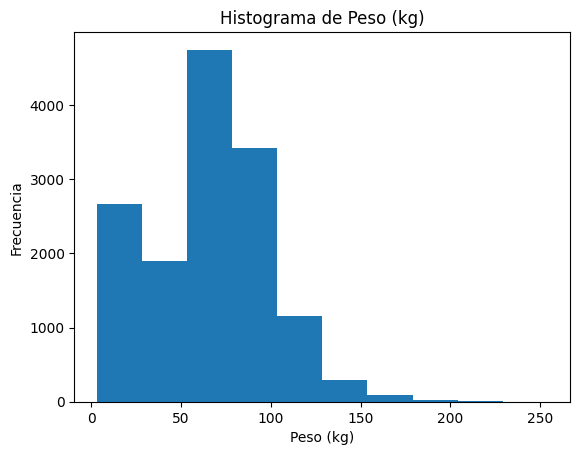

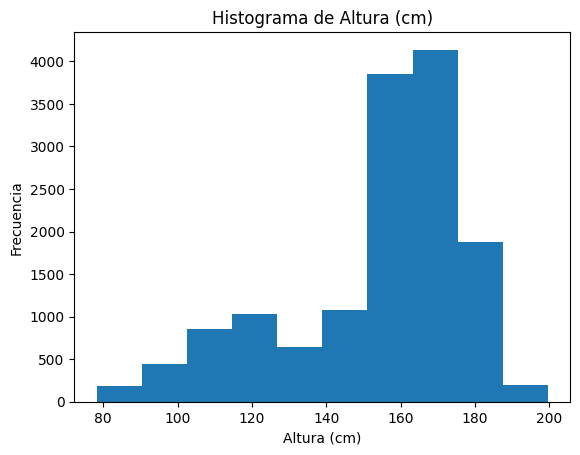

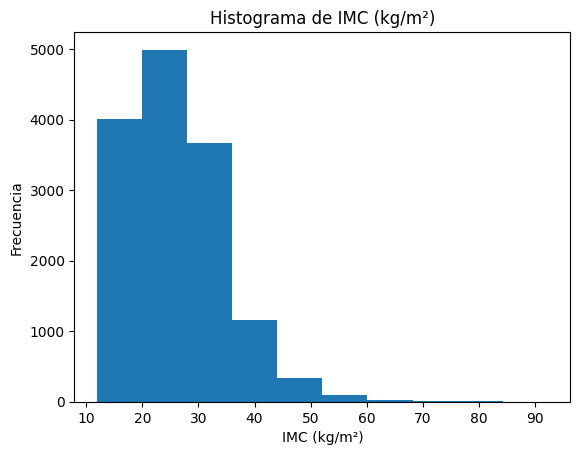

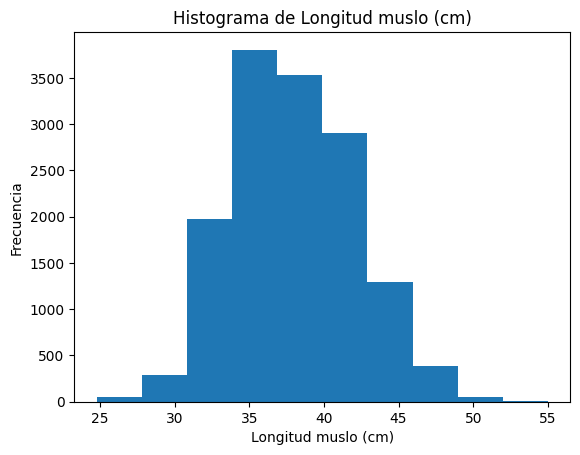

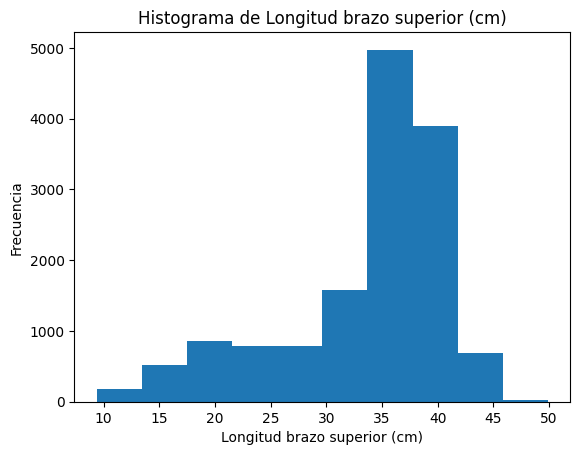

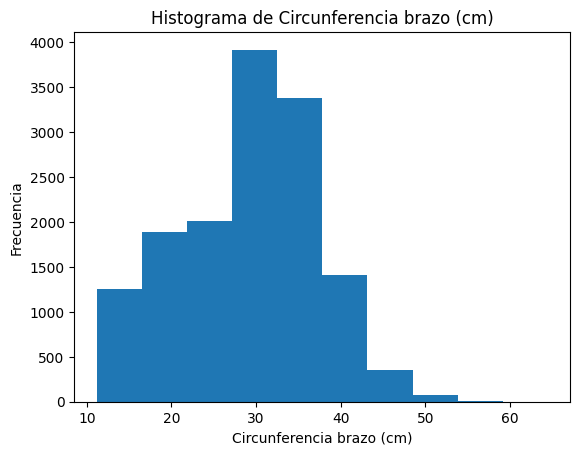

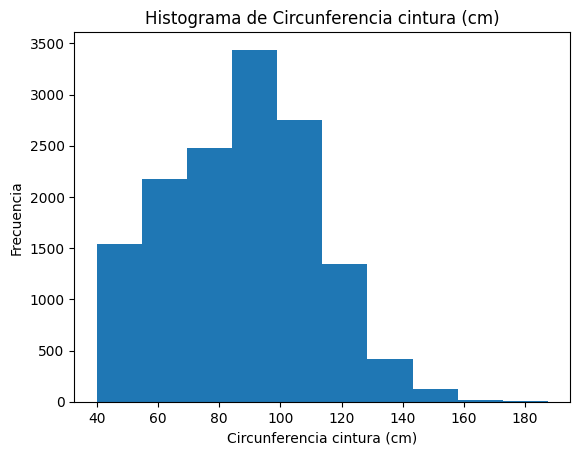

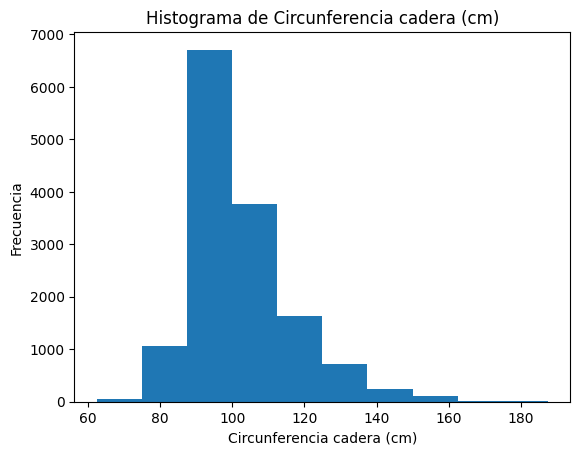

In [15]:
for columna in medidas_corporales.columns[4:]:
    plt.hist(medidas_corporales[columna])
    plt.title(f"Histograma de {columna}")
    plt.xlabel(f"{columna}")
    plt.ylabel("Frecuencia")
    plt.show()

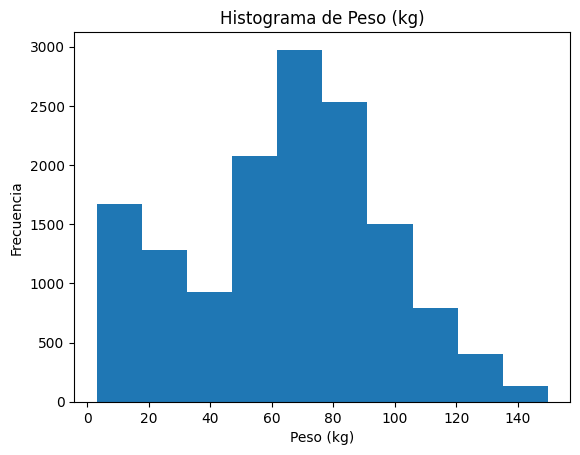

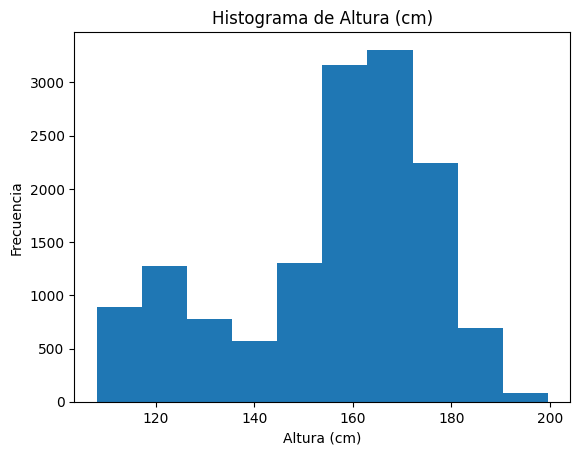

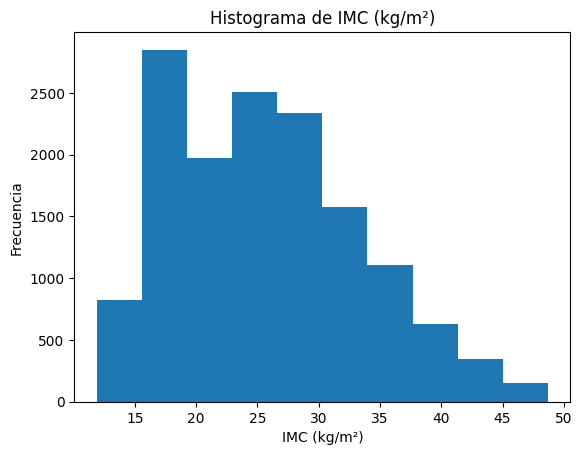

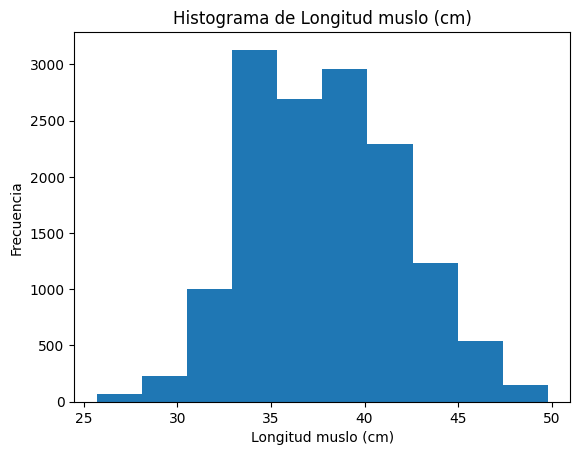

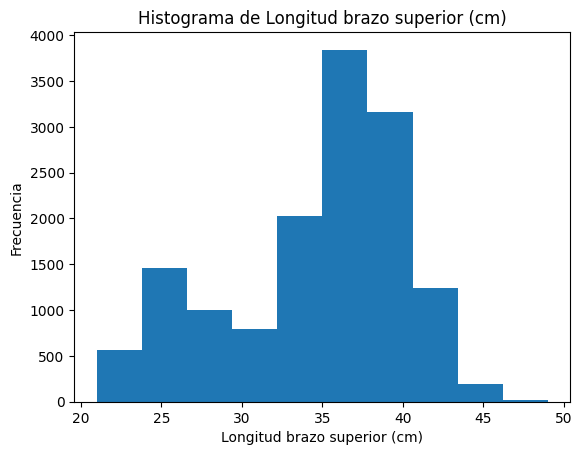

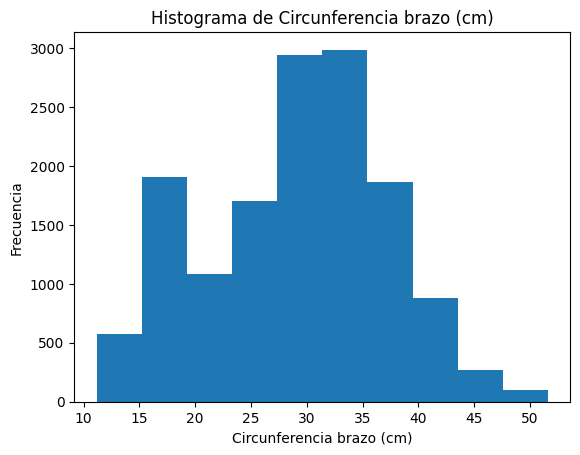

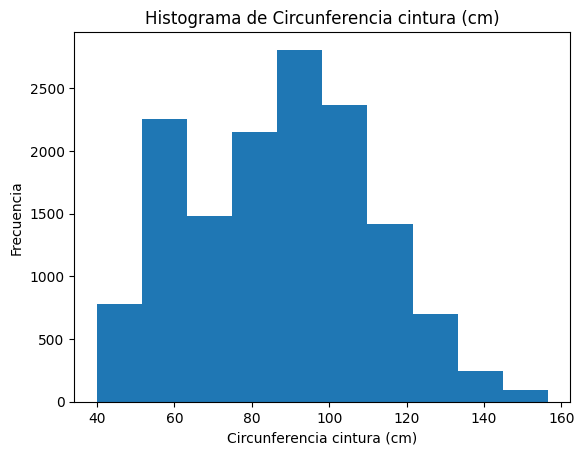

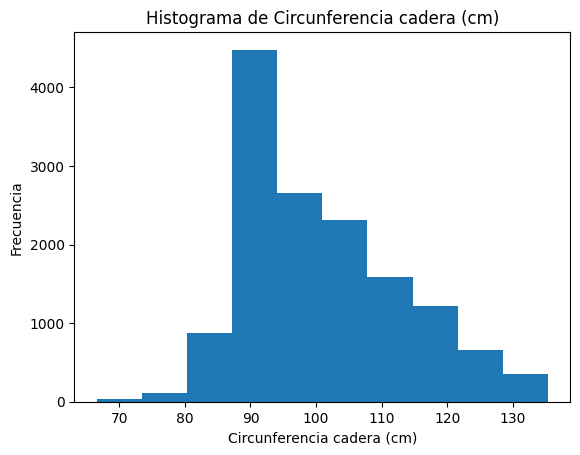

In [13]:
for columna in medida.columns[4:]:
    plt.hist(medida[columna])
    plt.title(f"Histograma de {columna}")
    plt.xlabel(f"{columna}")
    plt.ylabel("Frecuencia")
    plt.show()

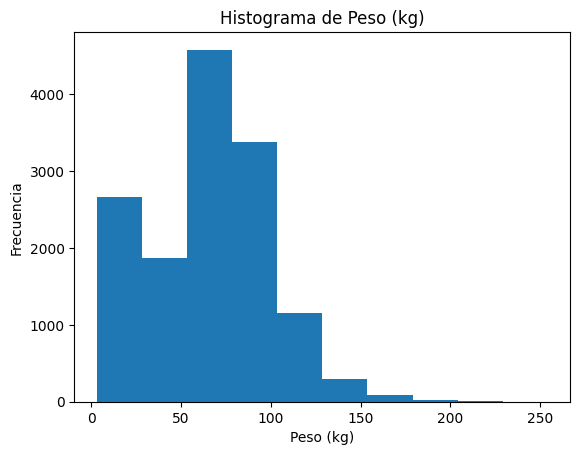

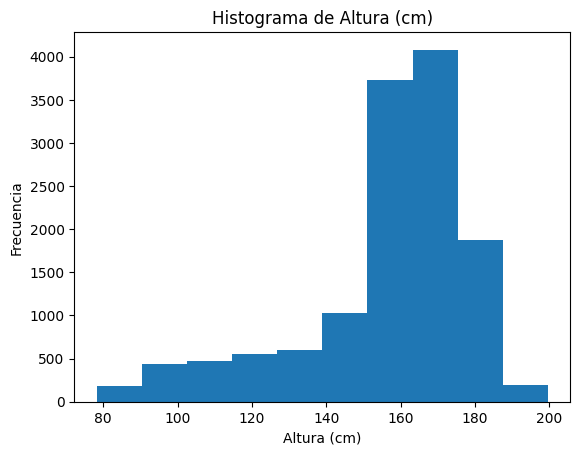

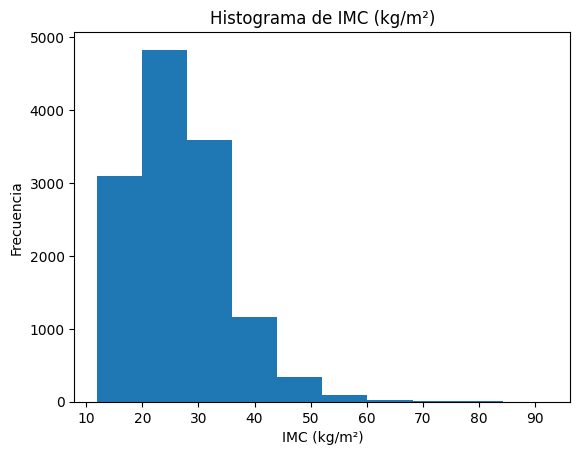

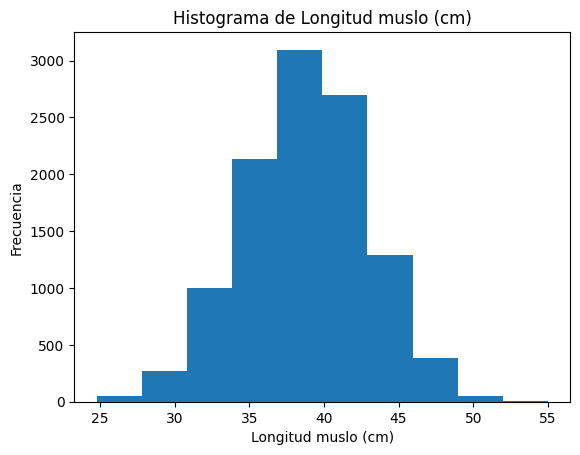

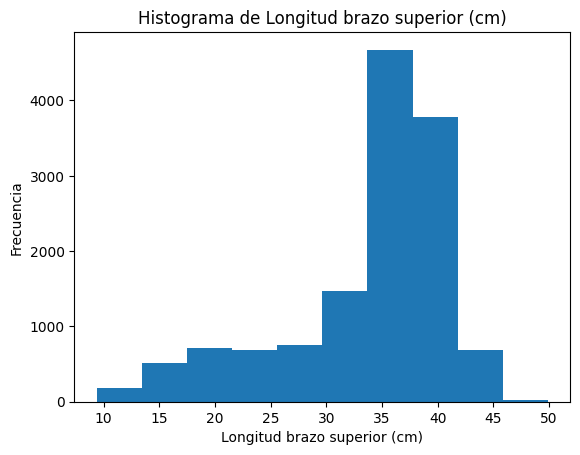

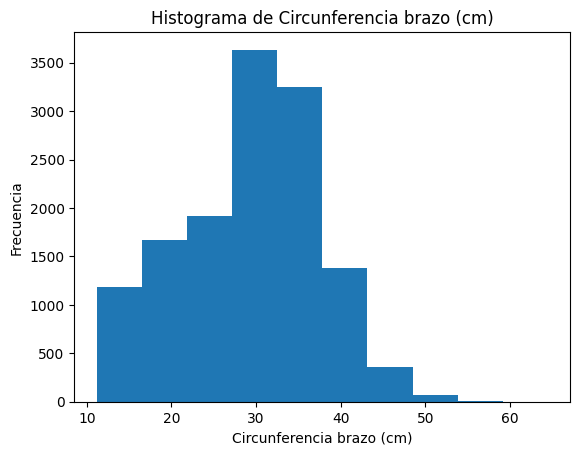

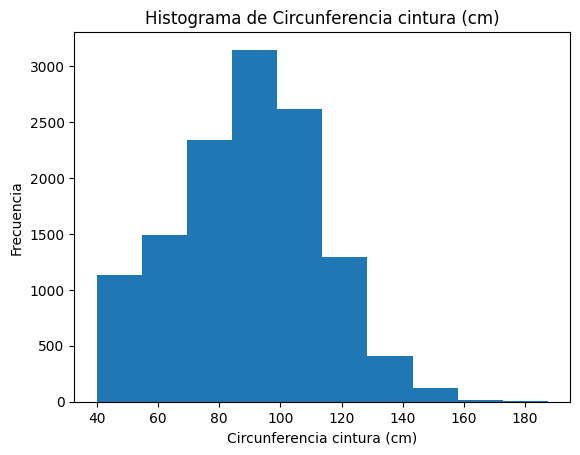

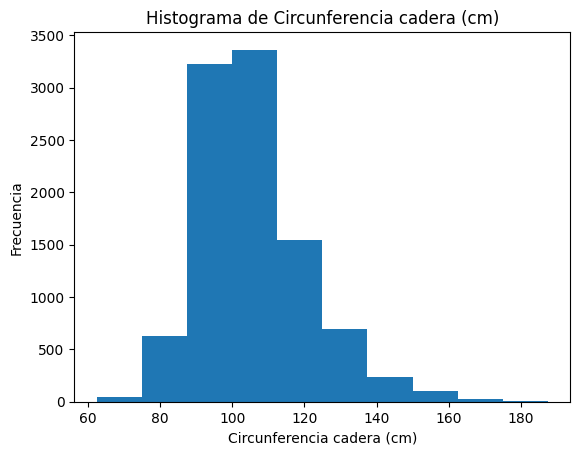

In [14]:
for columna in corporal.columns[4:]:
    plt.hist(corporal[columna])
    plt.title(f"Histograma de {columna}")
    plt.xlabel(f"{columna}")
    plt.ylabel("Frecuencia")
    plt.show()

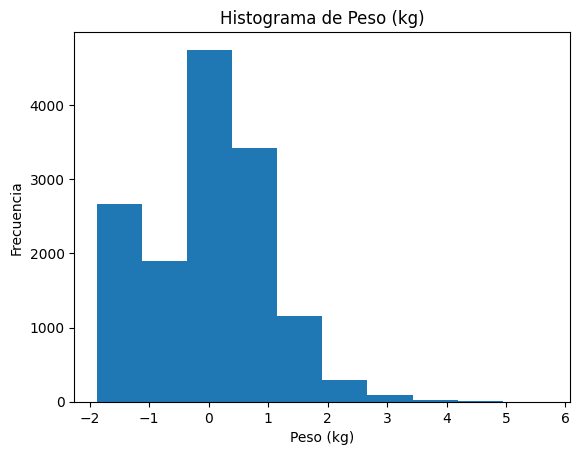

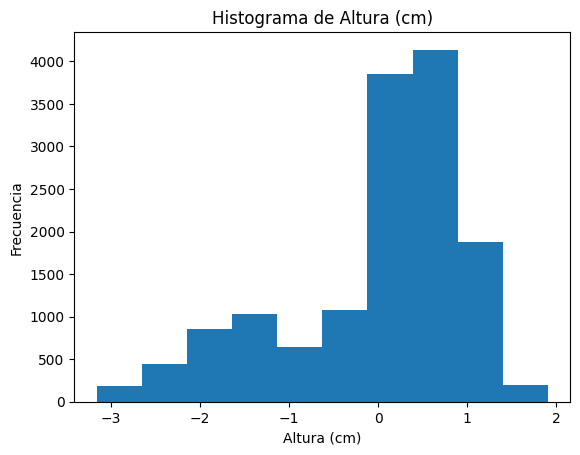

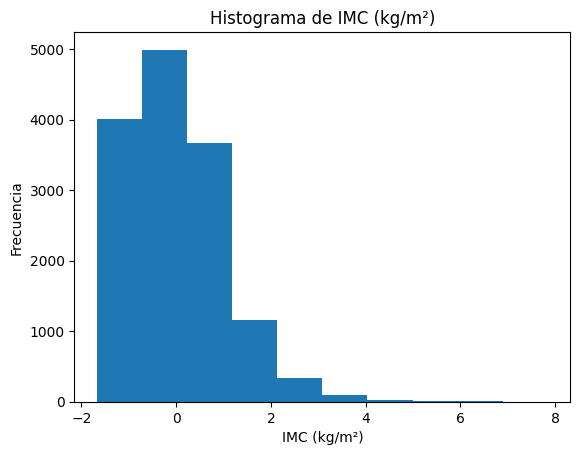

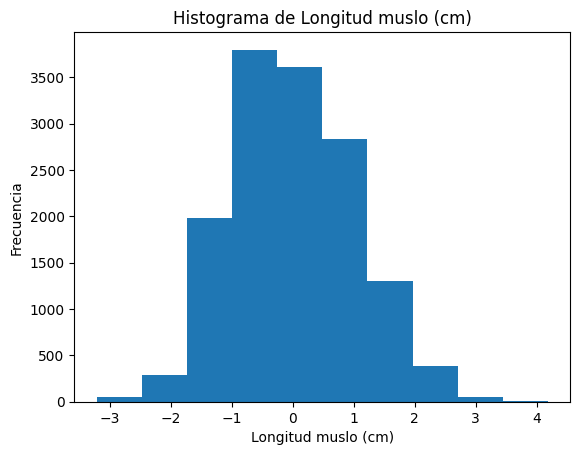

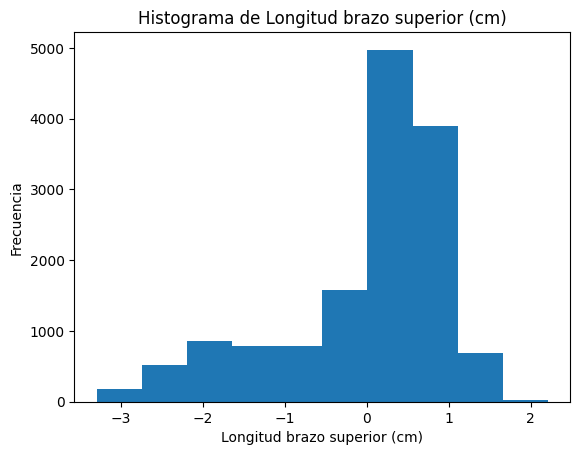

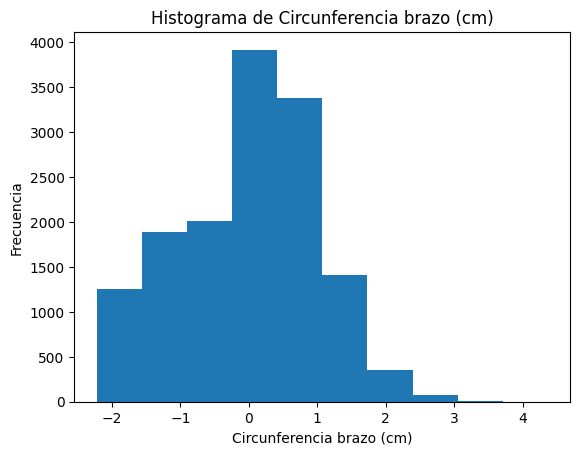

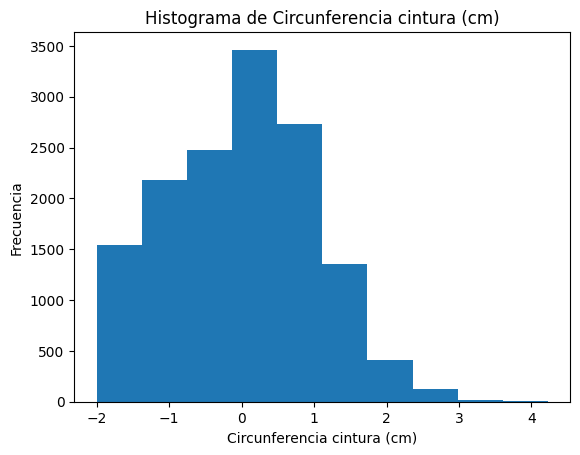

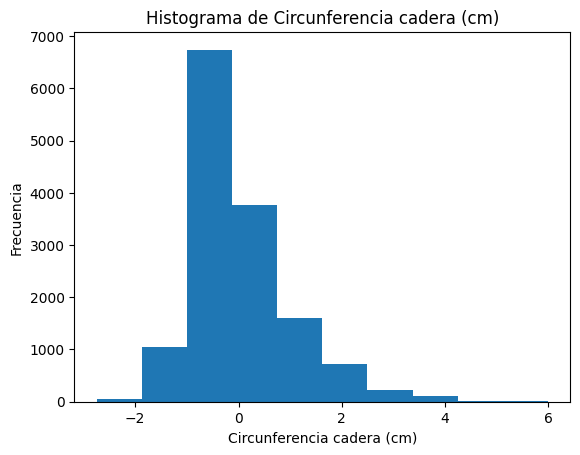

In [19]:
for columna in medida_scal.columns[4:]:
    plt.hist(medida_scal[columna])
    plt.title(f"Histograma de {columna}")
    plt.xlabel(f"{columna}")
    plt.ylabel("Frecuencia")
    plt.show()

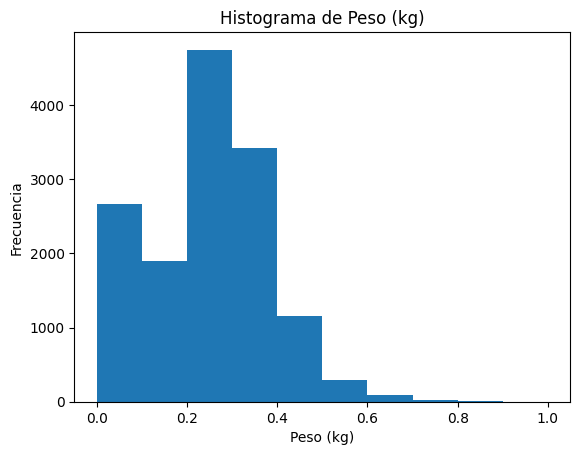

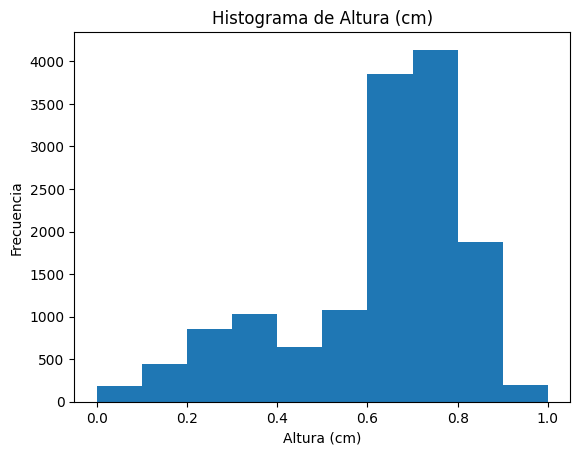

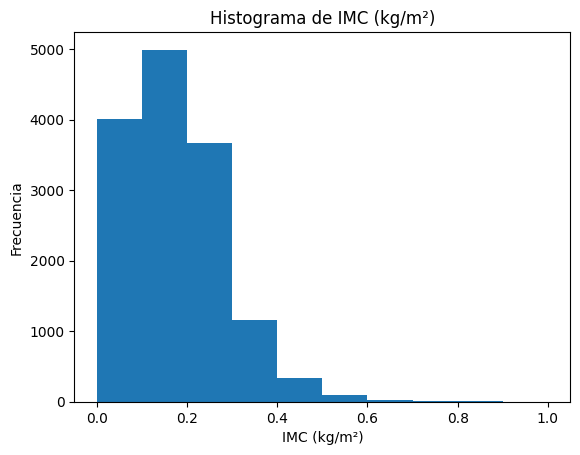

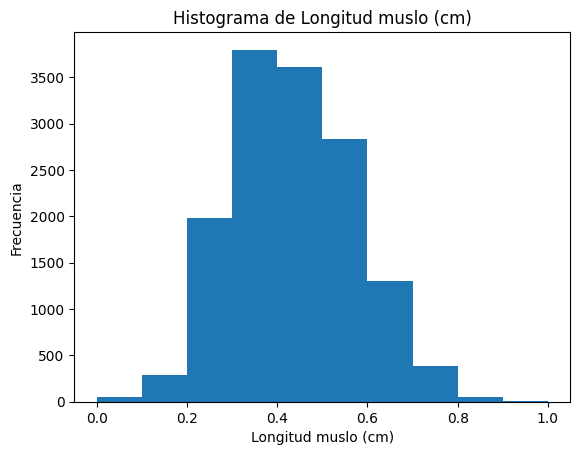

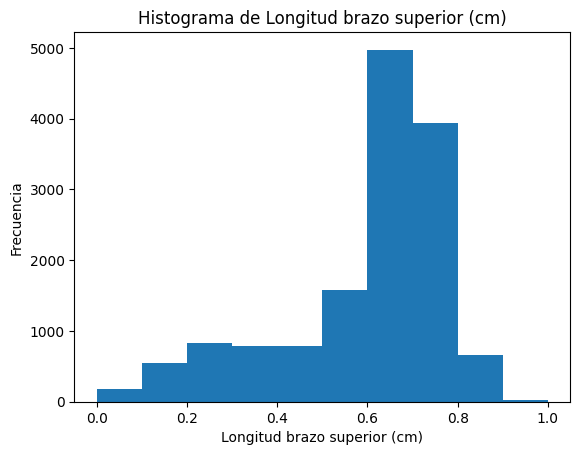

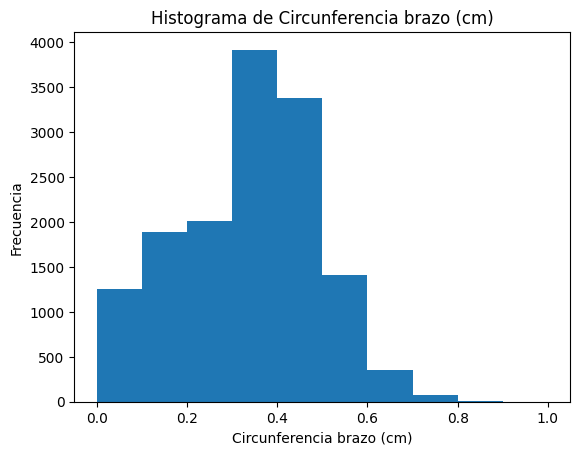

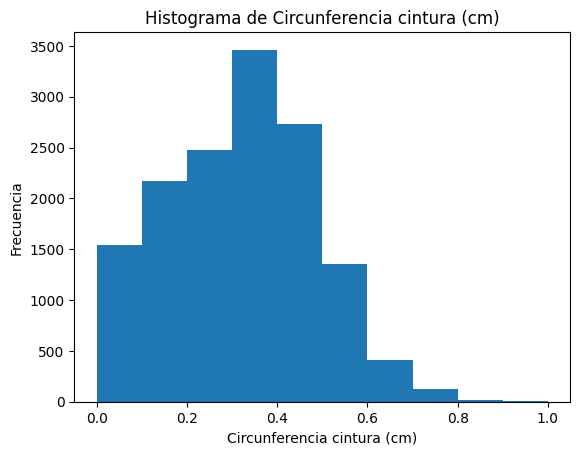

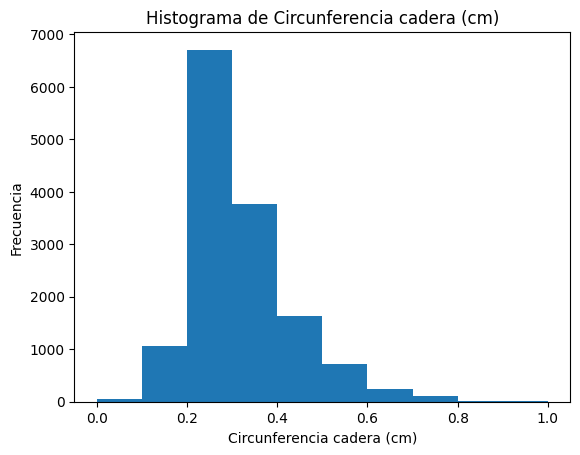

In [20]:
for columna in medida_minmax.columns[4:]:
    plt.hist(medida_minmax[columna])
    plt.title(f"Histograma de {columna}")
    plt.xlabel(f"{columna}")
    plt.ylabel("Frecuencia")
    plt.show()

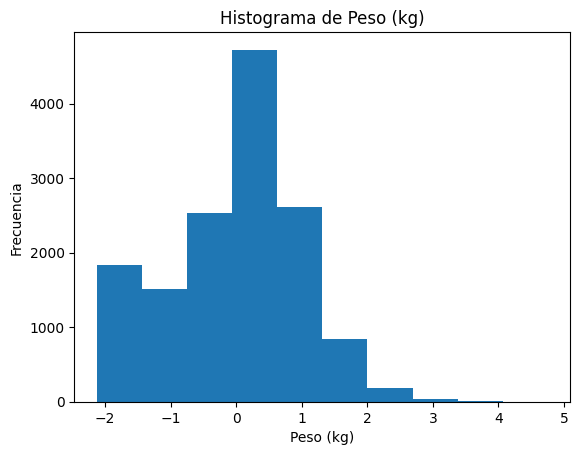

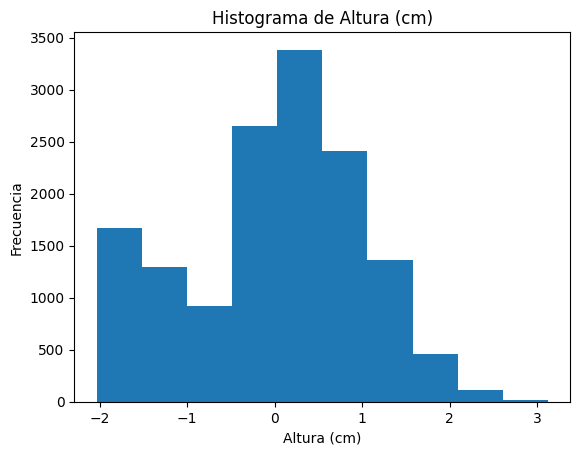

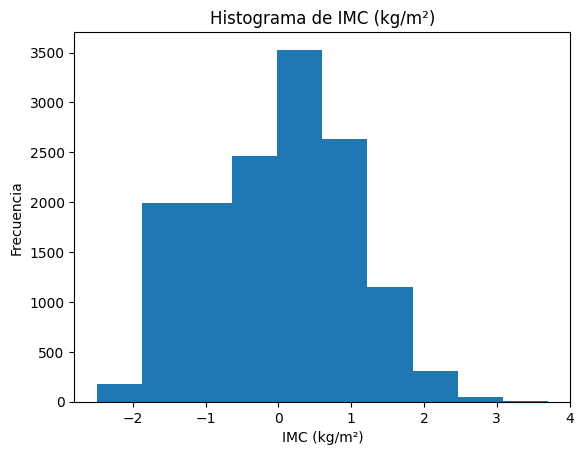

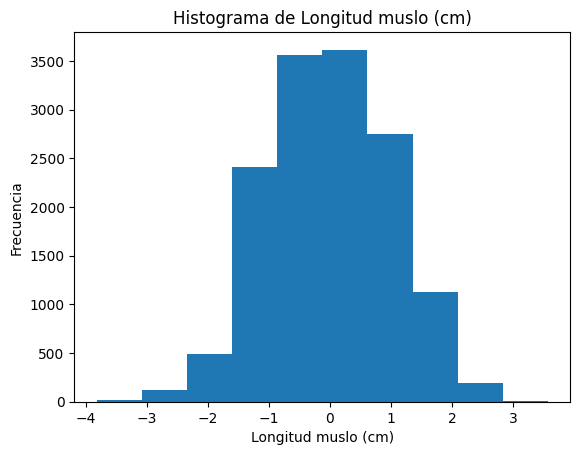

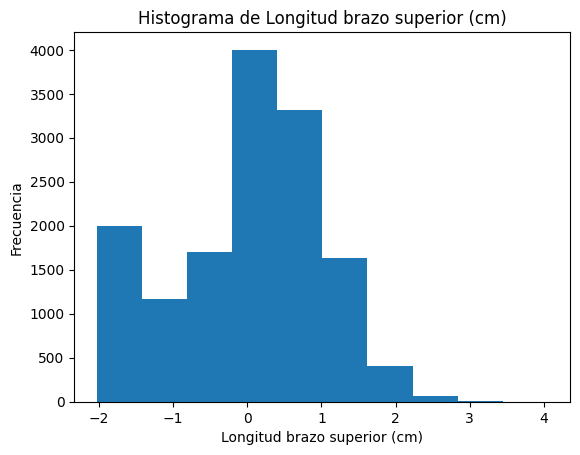

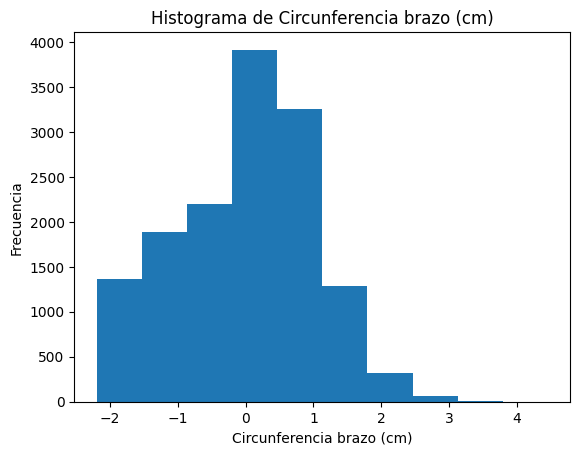

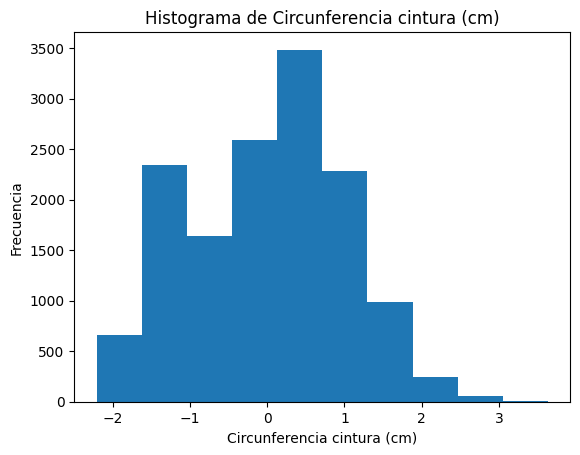

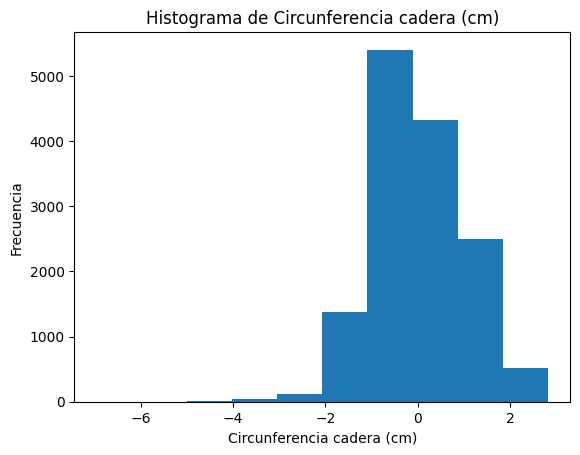

In [18]:
for columna in medida_PowerTransformer.columns[4:]:
    plt.hist(medida_PowerTransformer[columna])
    plt.title(f"Histograma de {columna}")
    plt.xlabel(f"{columna}")
    plt.ylabel("Frecuencia")
    plt.show()

In [17]:
medida_scal = multicolumn_scale(medidas_corporales)
medida_minmax = multicolumn_minmax(medidas_corporales)
medida_PowerTransformer = multicolumn_PowerTransformer(medidas_corporales)

In [79]:
med.describe()

ID     Edad     Sexo  Nivel Pobreza  Peso (kg)  Altura (cm)  \
count  14300.00 14300.00 14300.00       14300.00   14171.00     13381.00   
mean  117068.67     2.01     1.50           1.93      64.49       157.79   
std     4501.64     1.25     0.50           1.25      31.73        19.35   
min   109263.00     0.00     1.00           0.00       3.20       108.00   
25%   113170.75     1.00     1.00           1.00      42.50       151.10   
50%   117081.50     2.00     2.00           2.00      67.70       162.00   
75%   120974.25     3.00     2.00           3.00      85.50       171.20   
max   124822.00     4.00     2.00           4.00     149.80       199.60   

       IMC (kg/m²)  Longitud muslo (cm)  Longitud brazo superior (cm)  \
count     14077.00             14264.00                      12874.00   
mean         25.56                37.90                         35.48   
std           7.62                 4.04                          5.02   
min          11.90                25.70                         21.00   
25%          18.90                34.75                         33.60   
50%          25.10                37.80                         36.50   
75%          30.50                40.70                         38.80   
max          48.70                49.80                         49.00   

       Circunferencia brazo (cm)  Circunferencia cintura (cm)  \
count                   14274.00                     14276.00   
mean                       29.10                        87.20   
std                         8.03                        23.50   
min                        11.20                        40.00   
25%                        23.40                        68.30   
50%                        30.10                        88.80   
75%                        34.70                       103.70   
max                        51.60                       156.50   

       Circunferencia cadera (cm)  
count                    13846.00  
mean                       100.28  
std                         11.87  
min                         66.60  
25%                         91.00  
50%                         97.50  
75%                        107.50  
max                        135.34

# Presión Arterial

In [29]:
def imputacion(dataframe:pd.DataFrame) -> pd.DataFrame:
    """
    This function does the following:

    1. Imputes missing values using KNN
    2. Returns imputed dataframe

    Args:
        dataframe (pd.DataFrame): DataFrame to impute

    Returns:
        pd.DataFrame: Imputed dataframe
    """
    knn_imputer = KNNImputer(n_neighbors=10, weights='uniform')
    imputado = pd.DataFrame(knn_imputer.fit_transform(dataframe), columns=dataframe.columns)
    return imputado


In [5]:
presion = pd.merge(clean, presion, on='ID', how='inner')

In [7]:
presion.columns


Index(['ID', 'Nivel Pobreza', 'Edad', 'Sexo',
       'Brazo seleccionado - oscilométrico',
       'Tamaño del manguito codificado - oscilométrico',
       'Presión sistólica - 1ra lectura oscilométrica',
       'Presión diastólica - 1ra lectura oscilométrica',
       'Presión sistólica - 2da lectura oscilométrica',
       'Presión diastólica - 2da lectura oscilométrica',
       'Presión sistólica - 3ra lectura oscilométrica',
       'Presión diastólica - 3ra lectura oscilométrica',
       'Pulso - 1ra lectura oscilométrica',
       'Pulso - 2da lectura oscilométrica',
       'Pulso - 3ra lectura oscilométrica'],
      dtype='object')

In [6]:
pres = presion.drop(labels="Brazo seleccionado - oscilométrico", axis=1)

In [8]:
pres.columns


Index(['ID', 'Nivel Pobreza', 'Edad', 'Sexo',
       'Tamaño del manguito codificado - oscilométrico',
       'Presión sistólica - 1ra lectura oscilométrica',
       'Presión diastólica - 1ra lectura oscilométrica',
       'Presión sistólica - 2da lectura oscilométrica',
       'Presión diastólica - 2da lectura oscilométrica',
       'Presión sistólica - 3ra lectura oscilométrica',
       'Presión diastólica - 3ra lectura oscilométrica',
       'Pulso - 1ra lectura oscilométrica',
       'Pulso - 2da lectura oscilométrica',
       'Pulso - 3ra lectura oscilométrica'],
      dtype='object')

In [34]:
pres.isna().sum()


ID                                                   0
Nivel Pobreza                                        0
Edad                                                 0
Sexo                                                 0
Tamaño del manguito codificado - oscilométrico    1283
Presión sistólica - 1ra lectura oscilométrica     1304
Presión diastólica - 1ra lectura oscilométrica    1304
Presión sistólica - 2da lectura oscilométrica     1329
Presión diastólica - 2da lectura oscilométrica    1329
Presión sistólica - 3ra lectura oscilométrica     1370
Presión diastólica - 3ra lectura oscilométrica    1370
Pulso - 1ra lectura oscilométrica                 2185
Pulso - 2da lectura oscilométrica                 2208
Pulso - 3ra lectura oscilométrica                 2244
dtype: int64

In [24]:
presion.describe()

ID  Nivel Pobreza     Edad     Sexo  \
count  11656.00       11656.00 11656.00 11656.00   
mean  117095.72           2.00     2.43     1.51   
std     4503.08           1.23     0.99     0.50   
min   109264.00           0.00     1.00     1.00   
25%   113185.75           1.00     2.00     1.00   
50%   117125.50           2.00     2.00     2.00   
75%   121019.25           3.00     3.00     2.00   
max   124822.00           4.00     4.00     2.00   

       Tamaño del manguito codificado - oscilométrico  \
count                                        10373.00   
mean                                             3.50   
std                                              0.70   
min                                              2.00   
25%                                              3.00   
50%                                              3.00   
75%                                              4.00   
max                                              5.00   

       Presión sistólica - 1ra lectura oscilométrica  \
count                                       10352.00   
mean                                          120.00   
std                                            19.95   
min                                            52.00   
25%                                           106.00   
50%                                           117.00   
75%                                           130.00   
max                                           225.00   

       Presión diastólica - 1ra lectura oscilométrica  \
count                                        10352.00   
mean                                            72.04   
std                                             12.42   
min                                             31.00   
25%                                             63.00   
50%                                             71.00   
75%                                             80.00   
max                                            151.00   

       Presión sistólica - 2da lectura oscilométrica  \
count                                       10327.00   
mean                                          119.73   
std                                            19.79   
min                                            54.00   
25%                                           106.00   
50%                                           116.00   
75%                                           130.00   
max                                           222.00   

       Presión diastólica - 2da lectura oscilométrica  \
count                                        10327.00   
mean                                            71.50   
std                                             12.44   
min                                             28.00   
25%                                             63.00   
50%                                             71.00   
75%                                             79.00   
max                                            146.00   

       Presión sistólica - 3ra lectura oscilométrica  \
count                                       10286.00   
mean                                          119.68   
std                                            19.64   
min                                            55.00   
25%                                           106.00   
50%                                           117.00   
75%                                           130.00   
max                                           220.00   

       Presión diastólica - 3ra lectura oscilométrica  \
count                                        10286.00   
mean                                            71.26   
std                                             12.41   
min                                             30.00   
25%                                             63.00   
50%                                             70.00   
75%                                             79.00   
max                            

In [25]:
presion_clean = presion.dropna()

In [35]:
presion_imp = imputacion(pres)

In [26]:
presion_clean.describe()

ID  Nivel Pobreza    Edad    Sexo  \
count   9410.00        9410.00 9410.00 9410.00   
mean  117134.55           2.04    2.43    1.50   
std     4505.63           1.24    0.97    0.50   
min   109264.00           0.00    1.00    1.00   
25%   113206.25           1.00    2.00    1.00   
50%   117177.50           2.00    2.00    2.00   
75%   121064.50           3.00    3.00    2.00   
max   124822.00           4.00    4.00    2.00   

       Tamaño del manguito codificado - oscilométrico  \
count                                         9410.00   
mean                                             3.51   
std                                              0.69   
min                                              2.00   
25%                                              3.00   
50%                                              4.00   
75%                                              4.00   
max                                              5.00   

       Presión sistólica - 1ra lectura oscilométrica  \
count                                        9410.00   
mean                                          119.76   
std                                            19.78   
min                                            52.00   
25%                                           106.00   
50%                                           116.00   
75%                                           130.00   
max                                           224.00   

       Presión diastólica - 1ra lectura oscilométrica  \
count                                         9410.00   
mean                                            71.97   
std                                             12.38   
min                                             31.00   
25%                                             63.00   
50%                                             71.00   
75%                                             80.00   
max                                            141.00   

       Presión sistólica - 2da lectura oscilométrica  \
count                                        9410.00   
mean                                          119.51   
std                                            19.65   
min                                            54.00   
25%                                           106.00   
50%                                           116.00   
75%                                           130.00   
max                                           222.00   

       Presión diastólica - 2da lectura oscilométrica  \
count                                         9410.00   
mean                                            71.44   
std                                             12.44   
min                                             28.00   
25%                                             63.00   
50%                                             71.00   
75%                                             79.00   
max                                            146.00   

       Presión sistólica - 3ra lectura oscilométrica  \
count                                        9410.00   
mean                                          119.47   
std                                            19.57   
min                                            55.00   
25%                                           106.00   
50%                                           116.00   
75%                                           130.00   
max                                           220.00   

       Presión diastólica - 3ra lectura oscilométrica  \
count                                         9410.00   
mean                                            71.17   
std                                             12.41   
min                                             30.00   
25%                                             62.00   
50%                                             70.00   
75%                                             79.00   
max                                            14

In [37]:
presion_IQR = multicolumn_IQR(presion_imp)

In [39]:
presion_clean = presion_IQR.dropna()

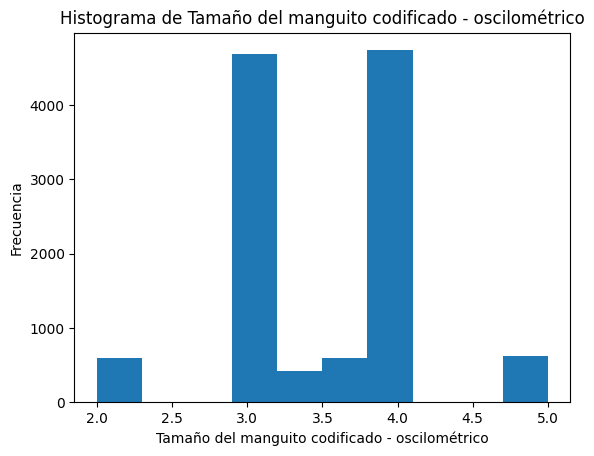

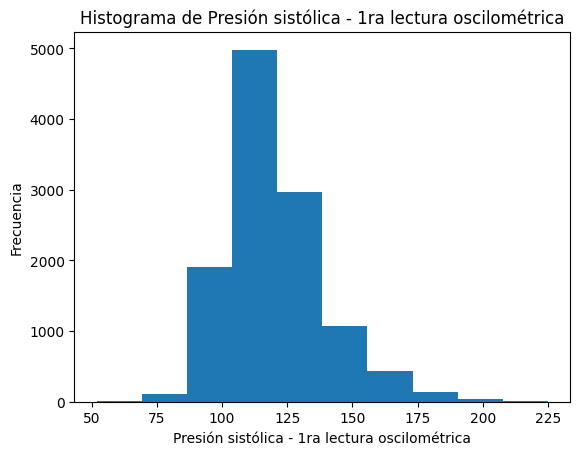

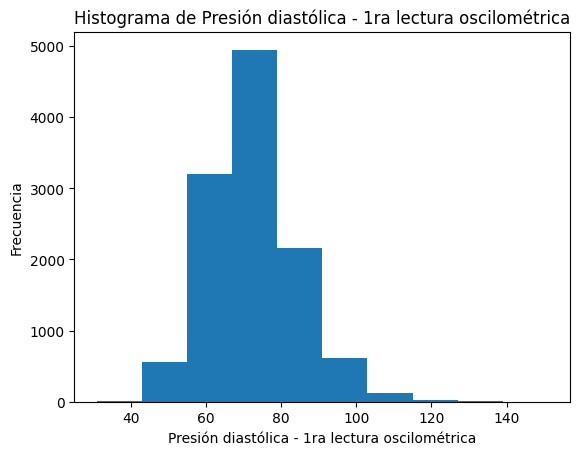

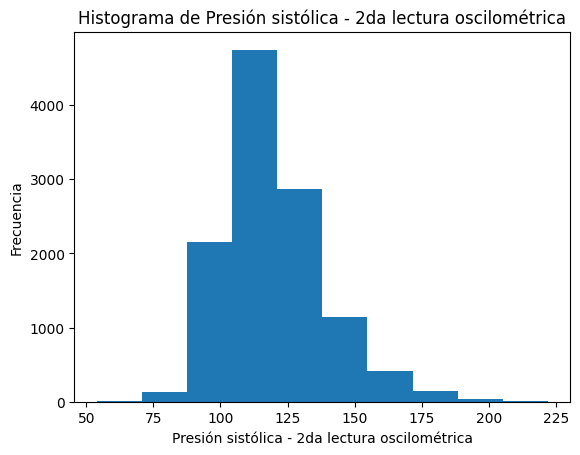

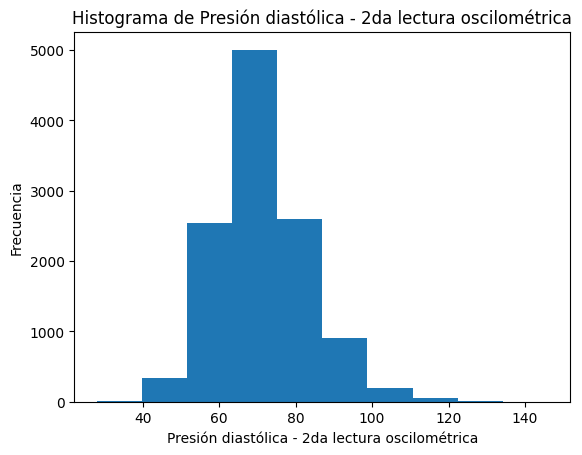

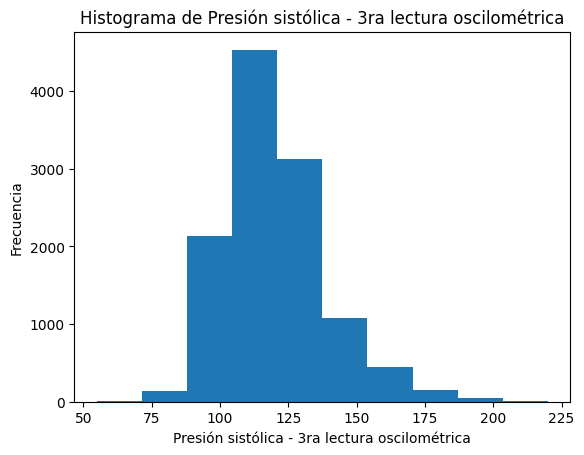

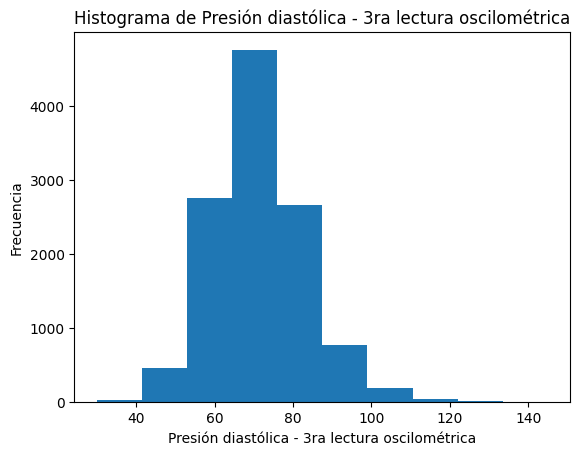

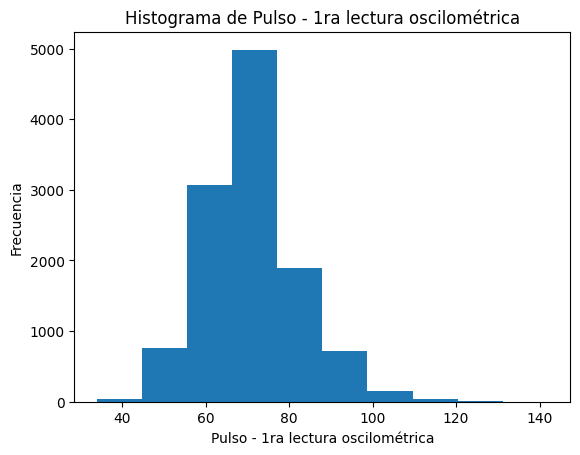

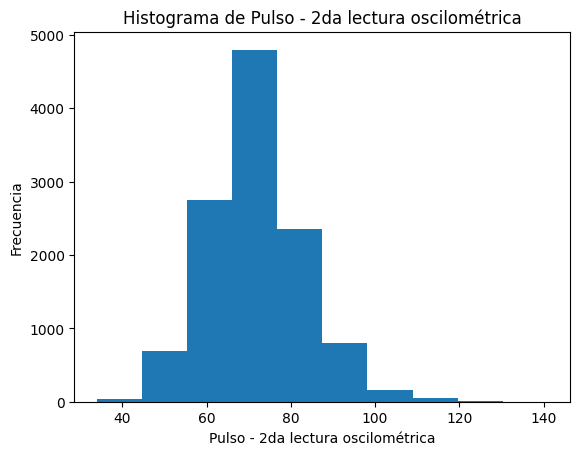

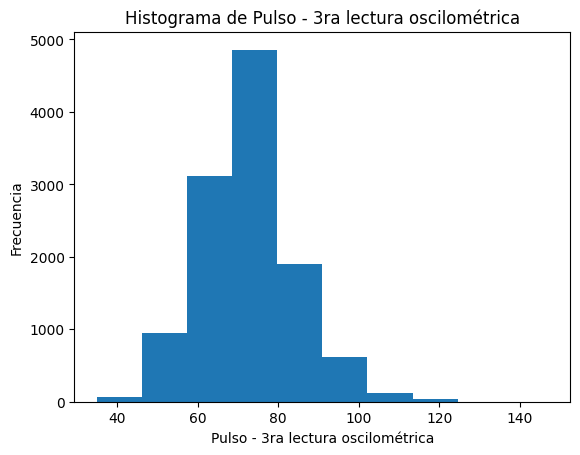

In [42]:
for columna in presion_imp.columns[4:]:
    plt.hist(presion_imp[columna])
    plt.title(f"Histograma de {columna}")
    plt.xlabel(f"{columna}")
    plt.ylabel("Frecuencia")
    plt.show()

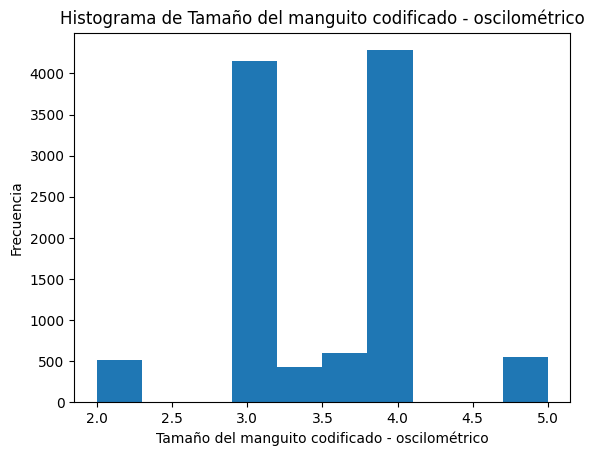

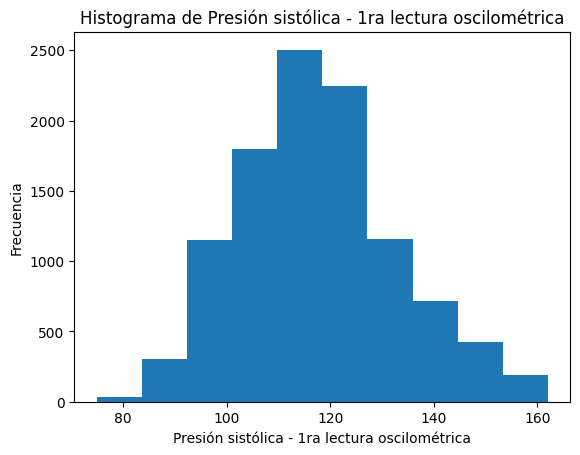

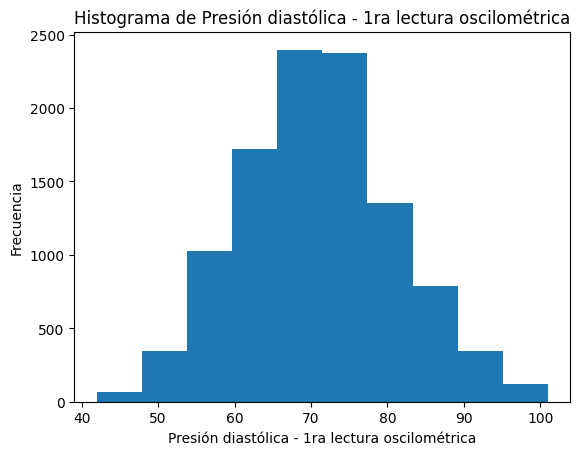

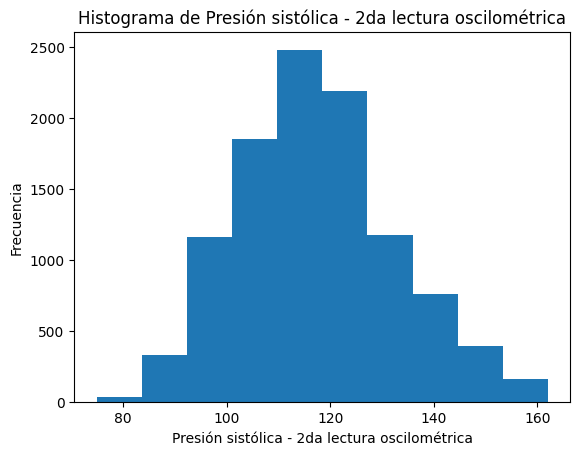

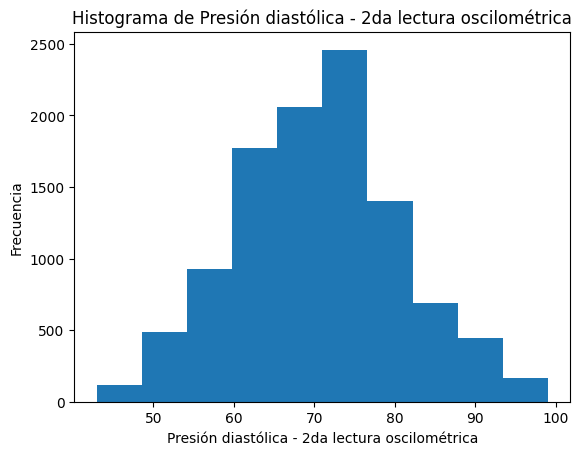

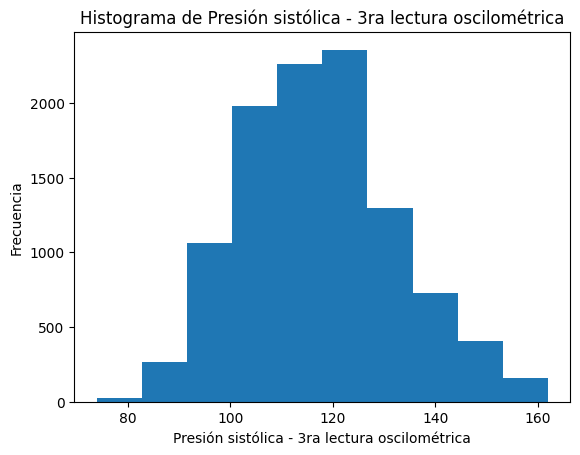

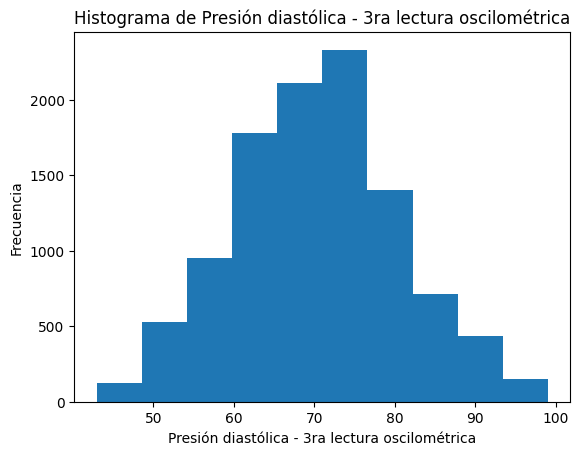

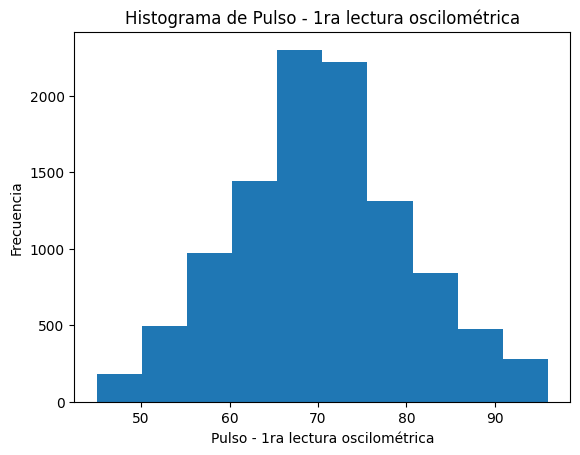

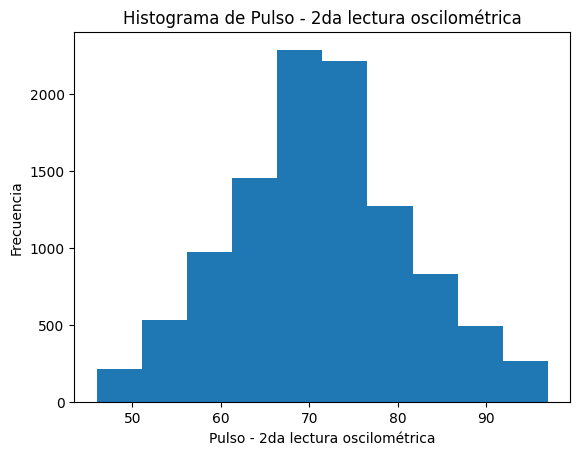

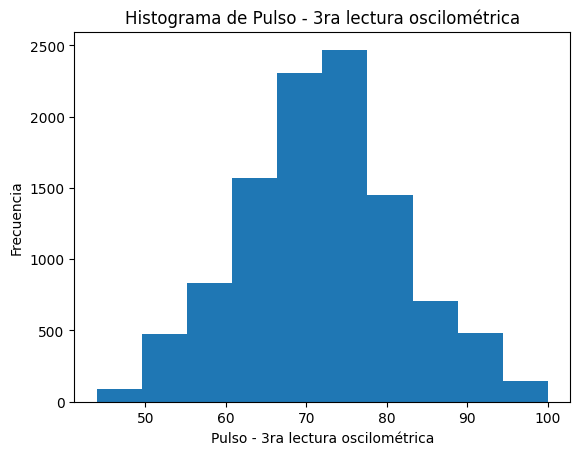

In [41]:
for columna in presion_clean.columns[4:]:
    plt.hist(presion_clean[columna])
    plt.title(f"Histograma de {columna}")
    plt.xlabel(f"{columna}")
    plt.ylabel("Frecuencia")
    plt.show()

In [43]:
presion_pt = multicolumn_PowerTransformer(presion_clean)

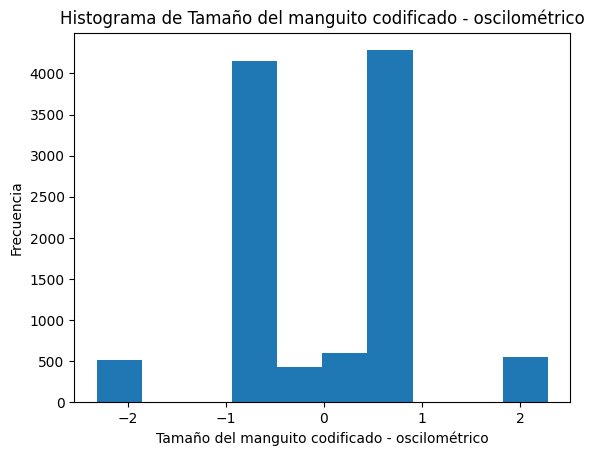

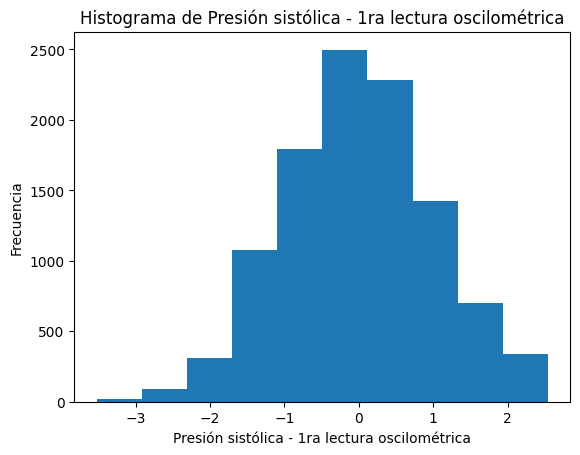

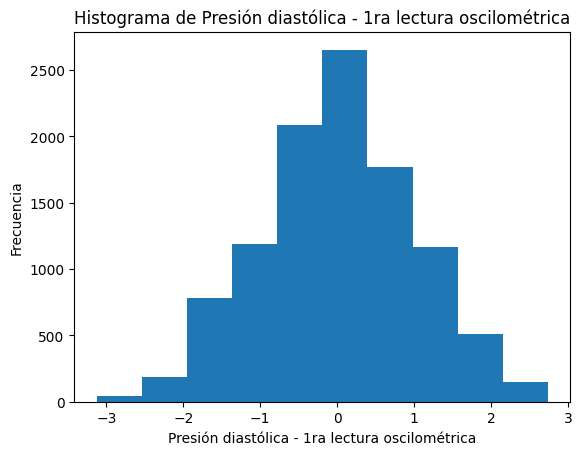

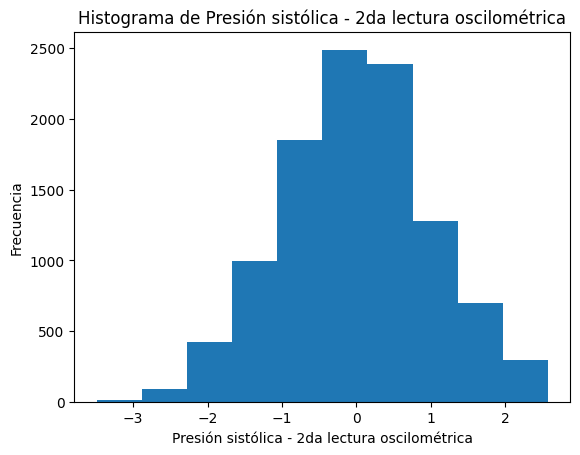

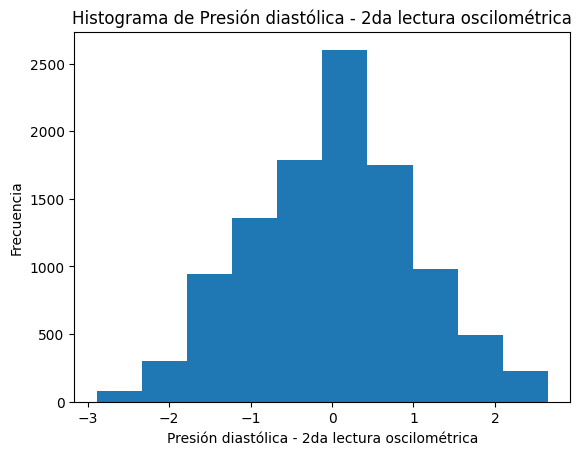

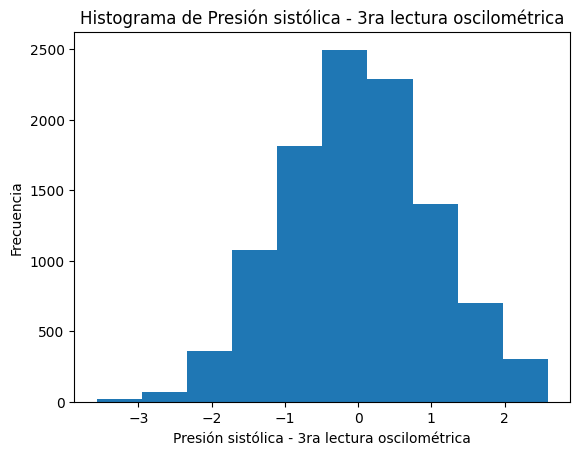

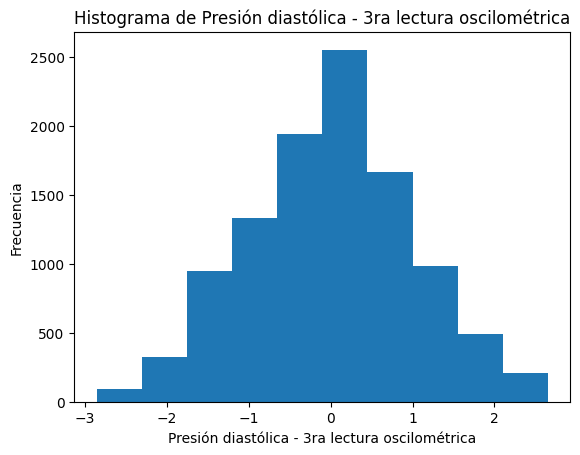

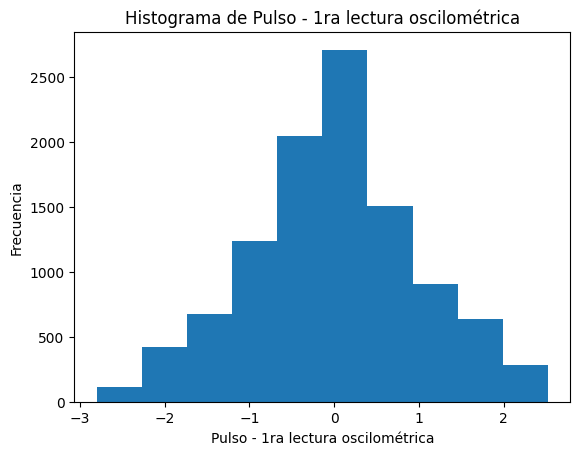

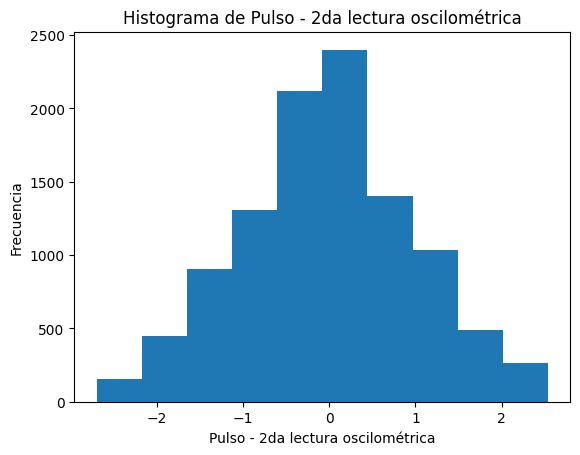

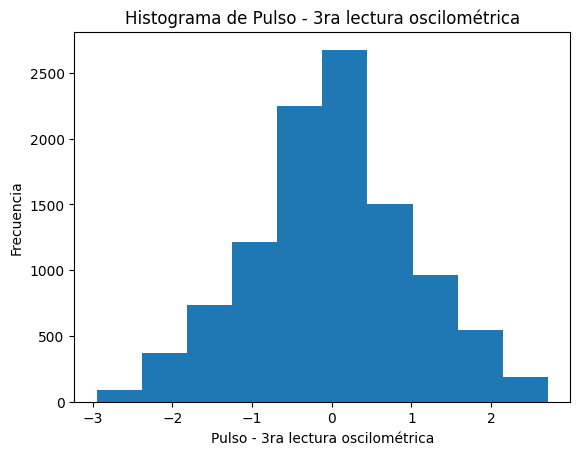

In [44]:
for columna in presion_pt.columns[4:]:
    plt.hist(presion_pt[columna])
    plt.title(f"Histograma de {columna}")
    plt.xlabel(f"{columna}")
    plt.ylabel("Frecuencia")
    plt.show()